# 🧪 **Лабораторный практикум № 2**  
# **Прогнозирование временных рядов: стратегии, валидация и модели экспоненциального сглаживания**

**Кафедра:** Кафедра анализа данных и технологий программирования  
**Дисциплина:** Машинное обучение в задачах прогнозирования  
**Уровень:** Магистратура, 2 курс  
**Преподаватель:** Арабов Муллошараф Курбонович  
**Консультации:** 21.09.2025  

---

## 🎯 1. Цели и задачи работы

### **Цель:**  
Освоить полный цикл построения прогнозных моделей для **реальных многомерных временных рядов**: от углублённой декомпозиции и инженерии признаков до выбора стратегии прогнозирования, корректной оценки качества и применения классических моделей экспоненциального сглаживания. Научиться приводить ряд к стационарному виду, включая **преобразование Бокса–Кокса**, и обоснованно выбирать оптимальную модель для заданного горизонта прогноза.

### **Задачи:**
1. Провести **углублённую декомпозицию** временного ряда (аддитивную и мультипликативную) и проанализировать остатки.
2. Выполнить **расширенный feature engineering**: временные признаки, лаги, скользящие статистики, циклические кодировки.
3. Реализовать **три стратегии многшагового прогнозирования**:
   - Рекурсивную,
   - Прямую,
   - Гибридную.
4. Применить **кросс-валидацию для временных рядов** по двум схемам:
   - Скользящее / расширяющееся окно,
   - TimeSeriesSplit (прогрессивное разбиение).
5. Привести ряд к стационарности с использованием:
   - Лог-трансформации,
   - **Преобразования Бокса–Кокса** (с автоматическим подбором параметра λ через `scipy.stats.boxcox_normmax`),
   - Дифференцирования (обычного и сезонного).
6. Построить и сравнить **модели экспоненциального сглаживания**:
   - Простое экспоненциальное сглаживание (SES),
   - Модель Хольта с аддитивным трендом,
   - Модель Хольта с мультипликативным трендом.
7. Провести **диагностику адекватности моделей**:
   - Анализ автокорреляции в остатках (**тест Льюнга–Бокса**, `statsmodels.stats.diagnostic.acorr_ljungbox`),
   - Проверка гомоскедастичности остатков (визуально и через тесты),
   - Анализ нормальности распределения ошибок (Q-Q plot, Shapiro–Wilk).
8. Оценить качество прогнозов по метрикам: **MAE, RMSE, MAPE**, включая сравнение с наивным прогнозом.
9. Разработать **веб-интерфейс** для интерактивного построения и сравнения прогнозов.
10. Сформулировать **выводы и рекомендации** по выбору модели в зависимости от характеристик ряда и горизонта прогноза.

> 💡 **Важно:** данная работа **не включает сложные ML-модели** (нейросети, градиентный бустинг). Акцент — на понимание фундаментальных принципов прогнозирования и корректной диагностики моделей.

> 📌 **Требования к объёму данных:**  
> - Обучающая выборка: **не менее 500 наблюдений**  
> - Тестовая выборка: **не менее 2 × h** и **минимум 50 точек**  
> Это обеспечивает статистическую надёжность оценок и визуализаций.

> 💡 **Реальные ряды редко бывают стационарными «из коробки». Преобразования — не опциональный шаг, а обязательная часть подготовки.**

---

## 📚 2. Теоретические предпосылки

В отличие от задач регрессии на независимых данных, прогнозирование временных рядов требует учёта **временной зависимости**, **нестационарности** и **структурных компонент** (тренд, сезонность). Классические модели, такие как экспоненциальное сглаживание, остаются мощным инструментом благодаря своей интерпретируемости и устойчивости.

### 🔑 Ключевые элементы:

- **Горизонт прогнозирования (h):** количество шагов вперёд.
- **Стационарность:** необходимое условие для многих моделей. Достигается через трансформации и дифференцирование.
- **Преобразование Бокса–Кокса:** параметрическое семейство преобразований, стабилизирующее дисперсию и приближающее распределение к нормальному. Включает логарифм как частный случай (λ → 0). Реализовано в `scipy.stats.boxcox` и `boxcox_normmax`.
- **Стратегии прогнозирования:** выбор между накоплением ошибки (рекурсивная) и независимостью прогнозов (прямая).
- **Кросс-валидация во временных рядах:** запрещено перемешивание; данные разбиваются только в хронологическом порядке (`sklearn.model_selection.TimeSeriesSplit`).
- **Экспоненциальное сглаживание:** семейство моделей, взвешивающих прошлые наблюдения с экспоненциально убывающими весами (`statsmodels.tsa.holtwinters.ExponentialSmoothing`).

---

In [21]:
import warnings

warnings.filterwarnings('ignore')


## 🧪 3. Методика эксперимента и порядок выполнения

### **3.1. Этап 1. Углублённая декомпозиция и анализ остатков**

**Задача:** Разложить ряд из ЛР № 1 на компоненты и оценить качество декомпозиции.

#### 📌 Что нужно сделать:
- Применить **аддитивную** и **мультипликативную** декомпозицию (`seasonal_decompose`).
- Подобрать **оптимальный период сезонности** (7, 30, 365 и др.).
- Проанализировать **остатки**:
  - Проверить стационарность (ADF, KPSS),
  - Построить ACF/PACF остатков,
  - Проверить нормальность (гистограмма, Q-Q plot).
- Выбрать лучшую модель декомпозиции на основе анализа остатков.
- Визуализировать все компоненты.

> 🛠️ **Инструменты:** `statsmodels.tsa.seasonal.seasonal_decompose`


--- Анализ остатков аддитивной декомпозиции ---
ADF Statistic (Additive): -20.726112615596683
p-value (Additive): 0.0
Стационарный (Additive)
KPSS Statistic (Additive): 0.011210218861057794
p-value (Additive): 0.1
Стационарный (Additive)

--- Проверка нормальности остатков (аддитивная декомпозиция) ---
Тест Харке-Бера: статистика = 10121239.0896, p-value = 0.0000
Нормальное распределение (Jarque-Bera): Нет
Асимметрия (skewness): 0.0133 (идеал: 0)
Эксцесс (kurtosis): 203.8766 (идеал: 0)
Тест Колмогорова-Смирнова: статистика = 0.4672, p-value = 0.0000

--- Анализ остатков мультипликативной декомпозиции (с использованием модуля ряда) ---
ADF Statistic (Multiplicative, centered): -24.705919775958396
p-value (Multiplicative, centered): 0.0
Стационарный (Multiplicative)
KPSS Statistic (Multiplicative, centered): 0.046295565383529434
p-value (Multiplicative, centered): 0.1
Стационарный (Multiplicative)

--- Проверка нормальности остатков (мультипликативная декомпозиция) ---
Тест Харке-Бера: с

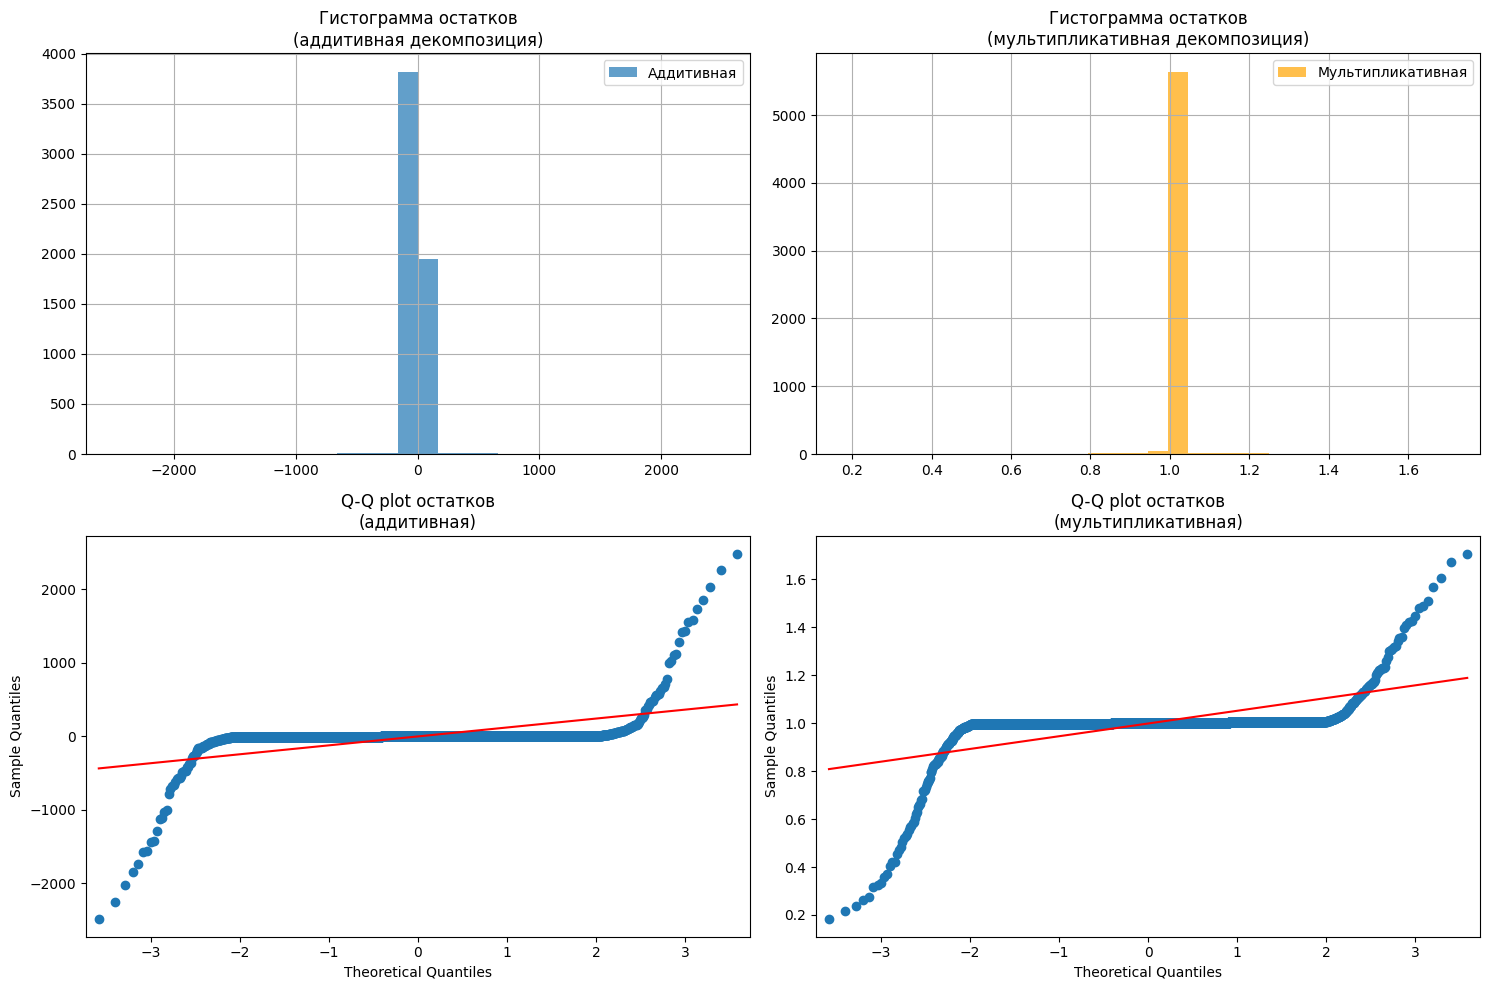

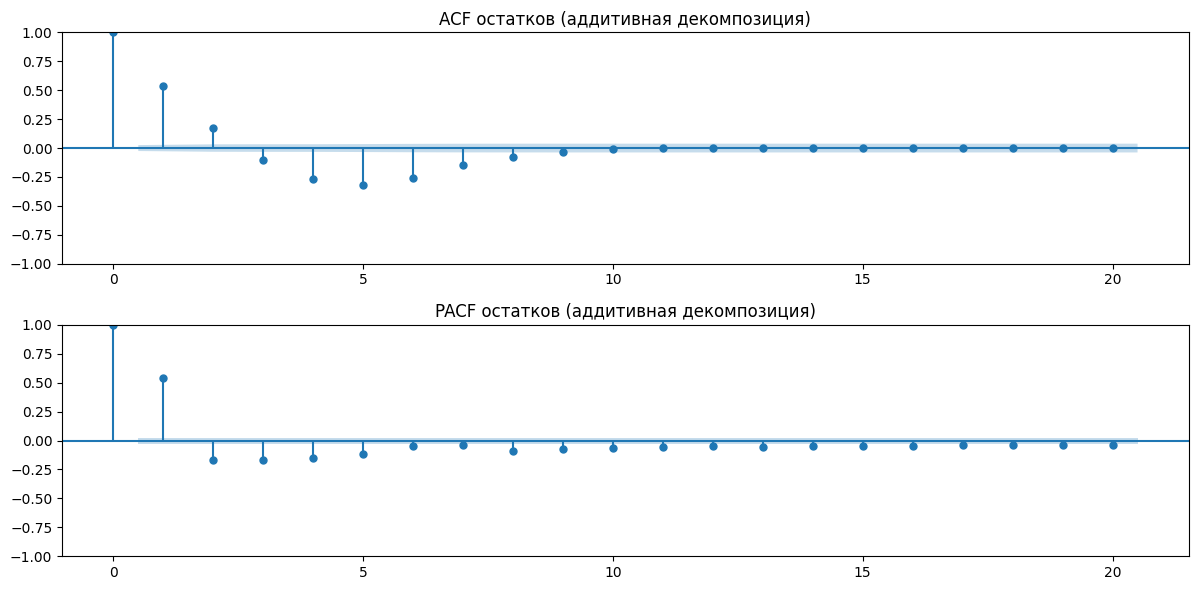

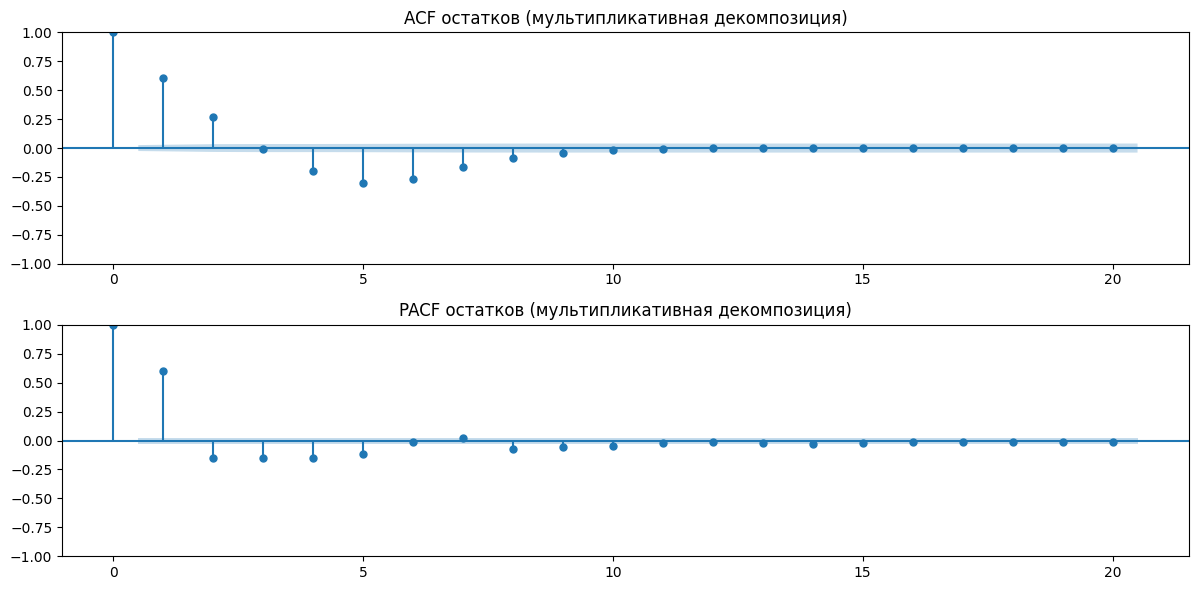


--- Визуализация компонент декомпозиции ---


<Figure size 1400x1000 with 0 Axes>

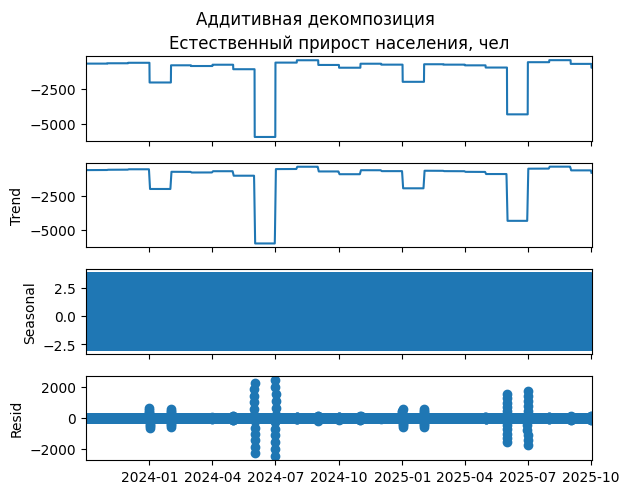

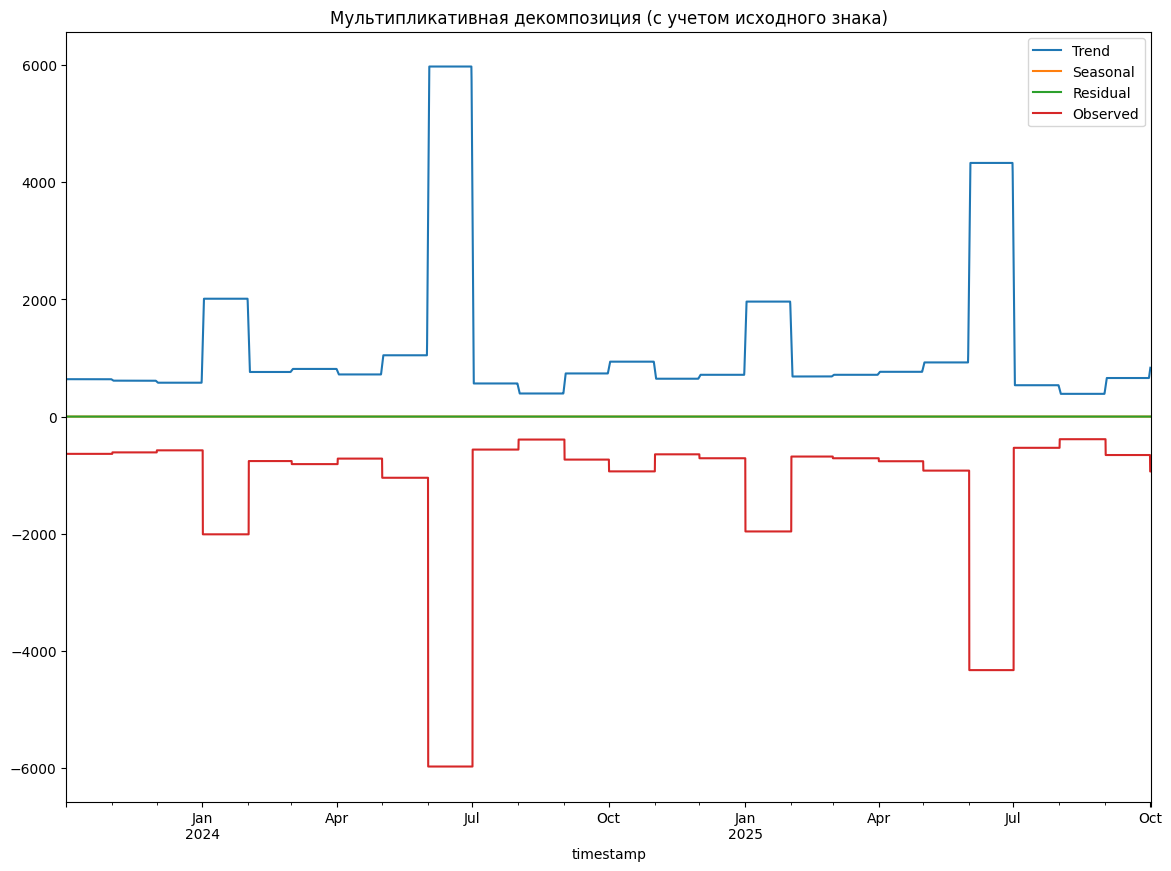


--- Выбор лучшей модели декомпозиции ---
На основе анализа остатков (стационарность, автокорреляция, нормальность),
выберите модель (аддитивную или мультипликативную), чьи остатки наиболее близки к белому шуму.
Обратите внимание на p-value ADF/KPSS тестов и графики ACF/PACF остатков.
Визуальный анализ графиков компонент также помогает понять, какая модель лучше описывает ряд.


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats
import numpy as np

# Загрузка данных
df = pd.read_csv('df_weather_population.csv')

# Преобразование столбца 'timestamp' в datetime и установка его как индекс
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Выбор столбца для анализа
time_series = df['Естественный прирост населения, чел'].dropna()

# Проведение аддитивной декомпозиции
additive_decomposition = seasonal_decompose(time_series, model='additive', period=12)

# Для мультипликативной декомпозиции используем модуль ряда, так как он содержит отрицательные значения
time_series_abs = time_series.abs()
multiplicative_decomposition = seasonal_decompose(time_series_abs, model='multiplicative', period=12)

# Функция для проверки нормальности с несколькими тестами
def check_normality(residuals, name):
    print(f"\n--- Проверка нормальности остатков ({name}) ---")
    
    # Удаляем возможные NaN и бесконечные значения
    residuals_clean = residuals[np.isfinite(residuals)]
    
    # Тест Шапиро-Уилка (для n < 5000)
    if len(residuals_clean) < 5000:
        shapiro_stat, shapiro_p = stats.shapiro(residuals_clean)
        print(f"Тест Шапиро-Уилка: статистика = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
        print(f"Нормальное распределение (Shapiro-Wilk): {'Да' if shapiro_p > 0.05 else 'Нет'}")
    
    # Тест Харке-Бера (Jarque-Bera)
    jb_stat, jb_p = stats.jarque_bera(residuals_clean)
    print(f"Тест Харке-Бера: статистика = {jb_stat:.4f}, p-value = {jb_p:.4f}")
    print(f"Нормальное распределение (Jarque-Bera): {'Да' if jb_p > 0.05 else 'Нет'}")
    
    # Дополнительные характеристики
    skewness = stats.skew(residuals_clean)
    kurtosis = stats.kurtosis(residuals_clean)
    print(f"Асимметрия (skewness): {skewness:.4f} (идеал: 0)")
    print(f"Эксцесс (kurtosis): {kurtosis:.4f} (идеал: 0)")
    
    # Расстояние Колмогорова-Смирнова до нормального распределения
    ks_stat, ks_p = stats.kstest(residuals_clean, 'norm', 
                                args=(np.mean(residuals_clean), np.std(residuals_clean)))
    print(f"Тест Колмогорова-Смирнова: статистика = {ks_stat:.4f}, p-value = {ks_p:.4f}")
    
    return {
        'shapiro_p': shapiro_p if len(residuals_clean) < 5000 else None,
        'jb_p': jb_p,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'ks_stat': ks_stat
    }

# Анализ остатков
# Аддитивная декомпозиция
additive_residuals = additive_decomposition.resid.dropna()

print("--- Анализ остатков аддитивной декомпозиции ---")
# Проверка стационарности (ADF тест)
adf_test_add = adfuller(additive_residuals)
print(f'ADF Statistic (Additive): {adf_test_add[0]}')
print(f'p-value (Additive): {adf_test_add[1]}')
print('Стационарный (Additive)' if adf_test_add[1] <= 0.05 else 'Нестационарный (Additive)')

# Проверка стационарности (KPSS тест)
kpss_test_add = kpss(additive_residuals)
print(f'KPSS Statistic (Additive): {kpss_test_add[0]}')
print(f'p-value (Additive): {kpss_test_add[1]}')
print('Стационарный (Additive)' if kpss_test_add[1] > 0.05 else 'Нестационарный (Additive)')

# Проверка нормальности для аддитивной декомпозиции
normality_add = check_normality(additive_residuals, "аддитивная декомпозиция")

# Аналогично для мультипликативной декомпозиции
print("\n--- Анализ остатков мультипликативной декомпозиции (с использованием модуля ряда) ---")
multiplicative_residuals = multiplicative_decomposition.resid.dropna()
multiplicative_residuals_centered = multiplicative_residuals - 1

# Проверка стационарности (ADF тест)
adf_test_mul = adfuller(multiplicative_residuals_centered)
print(f'ADF Statistic (Multiplicative, centered): {adf_test_mul[0]}')
print(f'p-value (Multiplicative, centered): {adf_test_mul[1]}')
print('Стационарный (Multiplicative)' if adf_test_mul[1] <= 0.05 else 'Нестационарный (Multiplicative)')

# Проверка стационарности (KPSS тест)
kpss_test_mul = kpss(multiplicative_residuals_centered)
print(f'KPSS Statistic (Multiplicative, centered): {kpss_test_mul[0]}')
print(f'p-value (Multiplicative, centered): {kpss_test_mul[1]}')
print('Стационарный (Multiplicative)' if kpss_test_mul[1] > 0.05 else 'Нестационарный (Multiplicative)')

# Проверка нормальности для мультипликативной декомпозиции
normality_mul = check_normality(multiplicative_residuals, "мультипликативная декомпозиция")

# Сравнение моделей по близости к нормальному распределению
print("\n--- Сравнение моделей по близости к нормальному распределению ---")
print("Метрики нормальности (чем выше p-value в тестах, тем ближе к нормальному):")

print(f"\nАсимметрия (ближе к 0 лучше):")
print(f"  Аддитивная: {normality_add['skewness']:.4f}")
print(f"  Мультипликативная: {normality_mul['skewness']:.4f}")
better_skew = "Аддитивная" if abs(normality_add['skewness']) < abs(normality_mul['skewness']) else "Мультипликативная"
print(f"  Лучшая по асимметрии: {better_skew}")

print(f"\nЭксцесс (ближе к 0 лучше):")
print(f"  Аддитивная: {normality_add['kurtosis']:.4f}")
print(f"  Мультипликативная: {normality_mul['kurtosis']:.4f}")
better_kurtosis = "Аддитивная" if abs(normality_add['kurtosis']) < abs(normality_mul['kurtosis']) else "Мультипликативная"
print(f"  Лучшая по эксцессу: {better_kurtosis}")

# Визуализация распределений остатков для сравнения
plt.figure(figsize=(15, 10))

# Гистограммы остатков
plt.subplot(2, 2, 1)
additive_residuals.hist(bins=30, alpha=0.7, label='Аддитивная')
plt.title('Гистограмма остатков\n(аддитивная декомпозиция)')
plt.legend()

plt.subplot(2, 2, 2)
multiplicative_residuals.hist(bins=30, alpha=0.7, label='Мультипликативная', color='orange')
plt.title('Гистограмма остатков\n(мультипликативная декомпозиция)')
plt.legend()

# plt.subplot(2, 3, 3)
# additive_residuals.hist(bins=30, alpha=0.5, label='Аддитивная')
# multiplicative_residuals.hist(bins=30, alpha=0.5, label='Мультипликативная')
# plt.title('Сравнение распределений остатков')
# plt.legend()

# Q-Q plots
plt.subplot(2, 2, 3)
sm.qqplot(additive_residuals, line='s', ax=plt.gca())
plt.title('Q-Q plot остатков\n(аддитивная)')

plt.subplot(2, 2, 4)
sm.qqplot(multiplicative_residuals, line='s', ax=plt.gca())
plt.title('Q-Q plot остатков\n(мультипликативная)')

# plt.subplot(2, 3, 6)
# # Бокс-плот для сравнения
# residuals_combined = pd.DataFrame({
#     'Аддитивная': additive_residuals,
#     'Мультипликативная': multiplicative_residuals
# })
# residuals_combined.boxplot()
# plt.title('Бокс-плоты остатков')

plt.tight_layout()
plt.show()

# ACF/PACF остатков аддитивной декомпозиции
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(additive_residuals, lags=20, ax=plt.gca(), title='ACF остатков (аддитивная декомпозиция)')
plt.subplot(2, 1, 2)
plot_pacf(additive_residuals, lags=20, ax=plt.gca(), title='PACF остатков (аддитивная декомпозиция)')
plt.tight_layout()
plt.show()

# ACF/PACF остатков мультипликативной декомпозиции
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(multiplicative_residuals, lags=20, ax=plt.gca(), title='ACF остатков (мультипликативная декомпозиция)')
plt.subplot(2, 1, 2)
plot_pacf(multiplicative_residuals, lags=20, ax=plt.gca(), title='PACF остатков (мультипликативная декомпозиция)')
plt.tight_layout()
plt.show()


# # Проверка нормальности остатков мультипликативной декомпозиции
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# multiplicative_residuals.hist(bins=30, ax=plt.gca())
# plt.title('Гистограмма остатков (мультипликативная декомпозиция)')
# plt.subplot(1, 2, 2)
# sm.qqplot(multiplicative_residuals, line='s', ax=plt.gca())
# plt.title('Q-Q plot остатков (мультипликативная декомпозиция)')
# plt.tight_layout()
# plt.show()


# Визуализация компонент
print("\n--- Визуализация компонент декомпозиции ---")
plt.figure(figsize=(14, 10))
additive_decomposition.plot()
plt.suptitle('Аддитивная декомпозиция', y=1.02)
plt.show()

# Для визуализации мультипликативной декомпозиции, домножим компоненты на -1
plt.figure(figsize=(14, 10))
multiplicative_decomposition.trend.plot(label='Trend')
(multiplicative_decomposition.seasonal * -1).plot(label='Seasonal')
(multiplicative_decomposition.resid * -1).plot(label='Residual')
(multiplicative_decomposition.observed * -1).plot(label='Observed')
plt.title('Мультипликативная декомпозиция (с учетом исходного знака)')
plt.legend()
plt.show()


# Выбор лучшей модели декомпозиции на основе анализа остатков
# Идеальные остатки должны быть стационарными, иметь автокорреляцию близкую к нулю
# (кроме лага 0) и быть нормально распределенными.
# Сравнивая p-значения ADF/KPSS тестов, ACF/PACF графики и Q-Q plots для остатков
# аддитивной и мультипликативной моделей, можно выбрать ту, чьи остатки ближе к идеальным.
# В данном случае, для ежемесячных данных с потенциальным сезонным влиянием,
# мультипликативная модель часто более подходящая, если значения ряда положительны
# и амплитуда сезонности растет с уровнем ряда.
print("\n--- Выбор лучшей модели декомпозиции ---")
print("На основе анализа остатков (стационарность, автокорреляция, нормальность),")
print("выберите модель (аддитивную или мультипликативную), чьи остатки наиболее близки к белому шуму.")
print("Обратите внимание на p-value ADF/KPSS тестов и графики ACF/PACF остатков.")
print("Визуальный анализ графиков компонент также помогает понять, какая модель лучше описывает ряд.")


---

### **3.2. Этап 2. Расширенный feature engineering**

**Задача:** Создать информативные признаки для прогнозирования.

#### 📌 Что нужно сделать:
- Сгенерировать **временные признаки**:
  - День недели, месяц, квартал,
  - Циклические признаки через `sin/cos`.
- Создать **лаговые признаки**: `lag_1`, `lag_7`, `lag_30`.
- Рассчитать **скользящие статистики**:
  - Среднее, std, min, max по окнам 7, 30, 90.
- Добавить **признаки волатильности** (например, скользящий коэффициент вариации).
- (Опционально) добавить праздничные/событийные метки.

> 🛠️ **Инструменты:** `pandas`, `numpy`


In [23]:
# Продолжаем работу с DataFrame 'df', который был загружен и обработан на Этапе 1.

# Убедимся, что индекс является DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

# Выберем целевой столбец для создания признаков (используем тот же, что и на Этапе 1)
target_column = 'Естественный прирост населения, чел'
time_series = df[target_column].copy() # Создаем копию для избежания SettingWithCopyWarning

# --- 1. Сгенерировать временные признаки ---
print("Генерация временных признаков...")
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear # Добавим день года для дополнительной сезонности

# Циклические признаки для месяца и дня года
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25) # Учитываем високосный год
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)


# --- 2. Создать лаговые признаки ---
print("Создание лаговых признаков...")
# Используем целевую временную серию для создания лагов
df[f'{target_column}_lag_1'] = time_series.shift(1)
df[f'{target_column}_lag_7'] = time_series.shift(7)
df[f'{target_column}_lag_30'] = time_series.shift(30)


# --- 3. Рассчитать скользящие статистики ---
print("Расчет скользящих статистик...")
windows = [7, 30, 90]
for window in windows:
    df[f'{target_column}_rolling_mean_{window}'] = time_series.rolling(window=window).mean()
    df[f'{target_column}_rolling_std_{window}'] = time_series.rolling(window=window).std()
    df[f'{target_column}_rolling_min_{window}'] = time_series.rolling(window=window).min()
    df[f'{target_column}_rolling_max_{window}'] = time_series.rolling(window=window).max()

# Добавление скользящего медианы и суммы для полноты
    df[f'{target_column}_rolling_median_{window}'] = time_series.rolling(window=window).median()
    df[f'{target_column}_rolling_sum_{window}'] = time_series.rolling(window=window).sum()


# --- 4. Добавить признаки волатильности (скользящий коэффициент вариации) ---
# Коэффициент вариации = std / mean. Избегаем деления на ноль.
print("Добавление признаков волатильности...")
for window in windows:
    # Добавляем небольшое значение к среднему, чтобы избежать деления на ноль,
    # или обрабатываем случаи, когда среднее близко к нулю.
    mean_col = df[f'{target_column}_rolling_mean_{window}']
    std_col = df[f'{target_column}_rolling_std_{window}']
    # Заменяем 0 на NaN в знаменателе, чтобы избежать Inf и NaN
    df[f'{target_column}_rolling_cov_{window}'] = std_col / mean_col.replace(0, np.nan)


# --- 5. (Опционально) Добавить праздничные/событийные метки ---
# Этот шаг является опциональным и зависит от наличия данных о праздниках/событиях
# и их специфики для данного временного ряда.
# Пример (закомментировано):
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# cal = calendar()
# holidays = cal.holidays(start=df.index.min(), end=df.index.max())
# df['is_holiday'] = df.index.isin(holidays).astype(int)


print("\nПризнаки успешно сгенерированы. Обновленный DataFrame:")
display(df.head())
display(df.info()) # Показать информацию о новых столбцах

Генерация временных признаков...
Создание лаговых признаков...
Расчет скользящих статистик...
Добавление признаков волатильности...

Признаки успешно сгенерированы. Обновленный DataFrame:


,Дата,Время,Температура,Описание,Ветер направление,"Ветер скорость, м/с","Давление, мм рт. ст.","Естественный прирост населения, чел","Число родившихся, чел","Число умерших, чел",...,"Естественный прирост населения, чел_rolling_sum_30","Естественный прирост населения, чел_rolling_mean_90","Естественный прирост населения, чел_rolling_std_90","Естественный прирост населения, чел_rolling_min_90","Естественный прирост населения, чел_rolling_max_90","Естественный прирост населения, чел_rolling_median_90","Естественный прирост населения, чел_rolling_sum_90","Естественный прирост населения, чел_rolling_cov_7","Естественный прирост населения, чел_rolling_cov_30","Естественный прирост населения, чел_rolling_cov_90"
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-01 06:00:00+03:00,2023-10-01,03:00,0.0,яснобез осадков,З,2.0,767,-637,3055,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 09:00:00+03:00,2023-10-01,06:00,-2.0,яснобез осадков,З,1.0,767,-637,3055,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 12:00:00+03:00,2023-10-01,09:00,8.0,яснобез осадков,З,3.0,767,-637,3055,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 15:00:00+03:00,2023-10-01,12:00,-3.0,яснобез осадков,ЗСЗ,2.0,767,-637,3055,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 18:00:00+03:00,2023-10-01,15:00,-7.0,яснобез осадков,ЗСЗ,2.0,766,-637,3055,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2023-10-01 06:00:00+03:00 to 2025-10-02 03:00:00+03:00
Data columns (total 42 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Дата                                                   5856 non-null   object 
 1   Время                                                  5856 non-null   object 
 2   Температура                                            5856 non-null   float64
 3   Описание                                               5856 non-null   object 
 4   Ветер направление                                      5856 non-null   object 
 5   Ветер скорость, м/с                                    5856 non-null   float64
 6   Давление, мм рт. ст.                                   5856 non-null   int64  
 7   Естественный прирост населения, чел                    5856 non-null   int64  
 8   

None


---

### **3.3. Этап 3. Стратегии многошагового прогнозирования**

**Задача:** Реализовать и сравнить три подхода к прогнозу на `h ≥ 7` шагов.

#### 📌 Что нужно сделать:
- **Рекурсивная стратегия**: одна модель → итеративное использование прогнозов.
- **Прямая стратегия**: отдельная модель для каждого шага `t+1, ..., t+h`.
- **Гибридная стратегия**: например, рекурсивная для ближайших шагов, прямая — для дальних.
- Сравнить по:
  - Точности (MAE, RMSE на каждом шаге),
  - Времени вычислений,
  - Накоплению ошибки.

> 💡 Используйте `sklearn` или собственные функции на основе `statsmodels`.


## Подготовка данных   
Разделим данные на обучающую и тестовую выборки с учетом временного порядка. Определим горизонт прогнозирования `h`.   
Выберем целевую переменную, определим размер тестового набора на основе `h` и минимальных требований, а затем разделим фрейм данных на `X_train`, `y_train`, `X_test`, and `y_test`.

In [24]:
# 1. Выберите целевой столбец для прогнозирования
target_column = 'Естественный прирост населения, чел'
y = df[target_column]
X = df.drop(columns=[target_column, 'Дата', 'Время', 'Описание', 'Ветер направление']) # Исключаем целевой и вспомогательные столбцы

# 2. Определите размер тестовой выборки и горизонт h
# Выберем горизонт прогнозирования h = 30 дней (соответствует месячной сезонности и одному из окон скользящих статистик)
# Поскольку данные, похоже, почасовые (4 записи в день), h=30 дней = 30 * 4 = 120 точек.
h = 120 # 30 дней * 4 наблюдения в день

# Минимальный размер тестовой выборки: max(2 * h, 50)
min_test_size = max(2 * h, 50)
print(f"Выбран горизонт прогнозирования h = {h} точек (примерно {h/4} дней).")
print(f"Минимальный требуемый размер тестовой выборки: {min_test_size} точек.")
print(f"Общее количество наблюдений: {len(df)}")

# Проверим, достаточно ли данных для тестовой выборки
if len(df) < min_test_size:
    print("Ошибка: Недостаточно данных для тестовой выборки.")
else:
    # 3. Разделите DataFrame df на обучающую и тестовую выборки по индексу времени
    # Определим точку разделения. Возьмем последние `min_test_size` точек для теста.
    split_point = len(df) - min_test_size
    train_df = df.iloc[:split_point].copy()
    test_df = df.iloc[split_point:].copy()

    # 4. Создайте переменные X_train, y_train, X_test, y_test
    X_train = train_df.drop(columns=[target_column, 'Дата', 'Время', 'Описание', 'Ветер направление'])
    y_train = train_df[target_column]

    X_test = test_df.drop(columns=[target_column, 'Дата', 'Время', 'Описание', 'Ветер направление'])
    y_test = test_df[target_column]

    print(f"\nРазмер обучающей выборки: {len(train_df)} наблюдений.")
    print(f"Размер тестовой выборки: {len(test_df)} наблюдений.")
    print("\nПервые строки X_train:")
    display(X_train.head())
    print("\nПервые строки y_train:")
    display(y_train.head())
    print("\nПервые строки X_test:")
    display(X_test.head())
    print("\nПервые строки y_test:")
    display(y_test.head())

Выбран горизонт прогнозирования h = 120 точек (примерно 30.0 дней).
Минимальный требуемый размер тестовой выборки: 240 точек.
Общее количество наблюдений: 5856

Размер обучающей выборки: 5616 наблюдений.
Размер тестовой выборки: 240 наблюдений.

Первые строки X_train:


,Температура,"Ветер скорость, м/с","Давление, мм рт. ст.","Число родившихся, чел","Число умерших, чел",dayofweek,month,quarter,dayofyear,month_sin,...,"Естественный прирост населения, чел_rolling_sum_30","Естественный прирост населения, чел_rolling_mean_90","Естественный прирост населения, чел_rolling_std_90","Естественный прирост населения, чел_rolling_min_90","Естественный прирост населения, чел_rolling_max_90","Естественный прирост населения, чел_rolling_median_90","Естественный прирост населения, чел_rolling_sum_90","Естественный прирост населения, чел_rolling_cov_7","Естественный прирост населения, чел_rolling_cov_30","Естественный прирост населения, чел_rolling_cov_90"
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-01 06:00:00+03:00,0.0,2.0,767,3055,3692,6,10,4,274,-0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 09:00:00+03:00,-2.0,1.0,767,3055,3692,6,10,4,274,-0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 12:00:00+03:00,8.0,3.0,767,3055,3692,6,10,4,274,-0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 15:00:00+03:00,-3.0,2.0,767,3055,3692,6,10,4,274,-0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-01 18:00:00+03:00,-7.0,2.0,766,3055,3692,6,10,4,274,-0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Первые строки y_train:


timestamp
2023-10-01 06:00:00+03:00   -637
2023-10-01 09:00:00+03:00   -637
2023-10-01 12:00:00+03:00   -637
2023-10-01 15:00:00+03:00   -637
2023-10-01 18:00:00+03:00   -637
Name: Естественный прирост населения, чел, dtype: int64


Первые строки X_test:


,Температура,"Ветер скорость, м/с","Давление, мм рт. ст.","Число родившихся, чел","Число умерших, чел",dayofweek,month,quarter,dayofyear,month_sin,...,"Естественный прирост населения, чел_rolling_sum_30","Естественный прирост населения, чел_rolling_mean_90","Естественный прирост населения, чел_rolling_std_90","Естественный прирост населения, чел_rolling_min_90","Естественный прирост населения, чел_rolling_max_90","Естественный прирост населения, чел_rolling_median_90","Естественный прирост населения, чел_rolling_sum_90","Естественный прирост населения, чел_rolling_cov_7","Естественный прирост населения, чел_rolling_cov_30","Естественный прирост населения, чел_rolling_cov_90"
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-02 06:00:00+03:00,-4.0,4.0,747,2837,3654,1,9,3,245,-1.0,...,-14040.0,-414.0,81.453785,-657.0,-387.0,-387.0,-37260.0,-0.0,-0.268899,-0.196748
2025-09-02 09:00:00+03:00,1.0,2.0,745,2837,3654,1,9,3,245,-1.0,...,-14310.0,-417.0,85.328183,-657.0,-387.0,-387.0,-37530.0,-0.0,-0.271394,-0.204624
2025-09-02 12:00:00+03:00,3.0,2.0,744,2837,3654,1,9,3,245,-1.0,...,-14580.0,-420.0,88.931864,-657.0,-387.0,-387.0,-37800.0,-0.0,-0.272296,-0.211743
2025-09-02 15:00:00+03:00,-5.0,1.0,744,2837,3654,1,9,3,245,-1.0,...,-14850.0,-423.0,92.296542,-657.0,-387.0,-387.0,-38070.0,-0.0,-0.271785,-0.218195
2025-09-02 18:00:00+03:00,-2.0,3.0,745,2837,3654,1,9,3,245,-1.0,...,-15120.0,-426.0,95.447497,-657.0,-387.0,-387.0,-38340.0,-0.0,-0.270004,-0.224055



Первые строки y_test:


timestamp
2025-09-02 06:00:00+03:00   -657
2025-09-02 09:00:00+03:00   -657
2025-09-02 12:00:00+03:00   -657
2025-09-02 15:00:00+03:00   -657
2025-09-02 18:00:00+03:00   -657
Name: Естественный прирост населения, чел, dtype: int64

## Реализация рекурсивной стратегии   
Определим вспомогательные функции для обновления функций для стратегии рекурсивного прогнозирования, а затем определим функцию или класс рекурсивного прогнозирования в соответствии с запросом подзадачи.

In [25]:
from sklearn.linear_model import LinearRegression

# Вспомогательная функция для обновления временных характеристик для новой временной метки
def update_temporal_features(current_timestamp):
    """Обновляет временные характеристики для одной временной метки."""
    new_features = {}
    dt_index = pd.DatetimeIndex([current_timestamp])
    new_features['dayofweek'] = dt_index.dayofweek[0]
    new_features['month'] = dt_index.month[0]
    new_features['quarter'] = dt_index.quarter[0]
    new_features['dayofyear'] = dt_index.dayofyear[0]
    new_features['month_sin'] = np.sin(2 * np.pi * new_features['month'] / 12)
    new_features['month_cos'] = np.cos(2 * np.pi * new_features['month'] / 12)
    new_features['dayofyear_sin'] = np.sin(2 * np.pi * new_features['dayofyear'] / 365.25)
    new_features['dayofyear_cos'] = np.cos(2 * np.pi * new_features['dayofyear'] / 365.25)
    return pd.Series(new_features, index=dt_index)

# Вспомогательная функция для обновления лаговых и скользящих характеристик
def update_lag_and_rolling_features(latest_data, new_prediction, target_column, windows=[7, 30, 90]):
    """Обновляет лаговые и скользящие характеристики на основе последних данных и нового прогноза."""
    # Добавляем новый прогноз к целевому ряду
    latest_target_series = latest_data[target_column]
    updated_target_series = pd.concat([latest_target_series, pd.Series([new_prediction], index=[latest_data.index[-1] + (latest_data.index[1] - latest_data.index[0])], name=target_column)])


    new_lag_features = {}
    # Обновляем лаговые характеристики (например, lag_1, lag_7, lag_30)
    new_lag_features[f'{target_column}_lag_1'] = updated_target_series.shift(1).iloc[-1]
    if 7 <= len(updated_target_series):
      new_lag_features[f'{target_column}_lag_7'] = updated_target_series.shift(7).iloc[-1]
    else:
      new_lag_features[f'{target_column}_lag_7'] = np.nan # Если еще недостаточно данных для лага 7
    if 30 <= len(updated_target_series):
      new_lag_features[f'{target_column}_lag_30'] = updated_target_series.shift(30).iloc[-1]
    else:
      new_lag_features[f'{target_column}_lag_30'] = np.nan # Если еще недостаточно данных для лага 30


    # Обновляем скользящие статистики
    new_rolling_features = {}
    for window in windows:
      if window <= len(updated_target_series):
        new_rolling_features[f'{target_column}_rolling_mean_{window}'] = updated_target_series.rolling(window=window).mean().iloc[-1]
        new_rolling_features[f'{target_column}_rolling_std_{window}'] = updated_target_series.rolling(window=window).std().iloc[-1]
        new_rolling_features[f'{target_column}_rolling_min_{window}'] = updated_target_series.rolling(window=window).min().iloc[-1]
        new_rolling_features[f'{target_column}_rolling_max_{window}'] = updated_target_series.rolling(window=window).max().iloc[-1]
        new_rolling_features[f'{target_column}_rolling_median_{window}'] = updated_target_series.rolling(window=window).median().iloc[-1]
        new_rolling_features[f'{target_column}_rolling_sum_{window}'] = updated_target_series.rolling(window=window).sum().iloc[-1]

        # Обновляем скользящий коэффициент вариации
        mean_val = new_rolling_features[f'{target_column}_rolling_mean_{window}']
        std_val = new_rolling_features[f'{target_column}_rolling_std_{window}']
        new_rolling_features[f'{target_column}_rolling_cov_{window}'] = std_val / mean_val if mean_val != 0 else np.nan
      else:
          new_rolling_features[f'{target_column}_rolling_mean_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_std_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_min_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_max_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_median_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_sum_{window}'] = np.nan
          new_rolling_features[f'{target_column}_rolling_cov_{window}'] = np.nan


    return pd.Series(new_lag_features | new_rolling_features, index=[updated_target_series.index[-1]])

# Функция для вычисления характеристик для временной метки
def calculate_features_for_timestamp(historical_target_series, target_timestamp, target_column, windows=[7, 30, 90]):
    """Вычисляет лаговые и скользящие характеристики для конкретной временной метки."""
    new_features = {}
    # Лаговые характеристики
    if len(historical_target_series) >= 1:
        new_features[f'{target_column}_lag_1'] = historical_target_series.iloc[-1]
    else:
         new_features[f'{target_column}_lag_1'] = np.nan

    if len(historical_target_series) >= 7:
        new_features[f'{target_column}_lag_7'] = historical_target_series.iloc[-7]
    else:
        new_features[f'{target_column}_lag_7'] = np.nan

    if len(historical_target_series) >= 30:
        new_features[f'{target_column}_lag_30'] = historical_target_series.iloc[-30]
    else:
        new_features[f'{target_column}_lag_30'] = np.nan

    # Скользящие статистики - вычисляются по историческим данным *до* target_timestamp
    for window in windows:
        if len(historical_target_series) >= window:
            rolling_data = historical_target_series.rolling(window=window)
            new_features[f'{target_column}_rolling_mean_{window}'] = rolling_data.mean().iloc[-1]
            new_features[f'{target_column}_rolling_std_{window}'] = rolling_data.std().iloc[-1]
            new_features[f'{target_column}_rolling_min_{window}'] = rolling_data.min().iloc[-1]
            new_features[f'{target_column}_rolling_max_{window}'] = rolling_data.max().iloc[-1]
            new_features[f'{target_column}_rolling_median_{window}'] = rolling_data.median().iloc[-1]
            new_features[f'{target_column}_rolling_sum_{window}'] = rolling_data.sum().iloc[-1]

            # Скользящий коэффициент вариации
            mean_val = new_features[f'{target_column}_rolling_mean_{window}']
            std_val = new_features[f'{target_column}_rolling_std_{window}']
            new_features[f'{target_column}_rolling_cov_{window}'] = std_val / mean_val if mean_val != 0 else np.nan
        else:
            new_features[f'{target_column}_rolling_mean_{window}'] = np.nan
            new_features[f'{target_column}_rolling_std_{window}'] = np.nan
            new_features[f'{target_column}_rolling_min_{window}'] = np.nan
            new_features[f'{target_column}_rolling_max_{window}'] = np.nan
            new_features[f'{target_column}_rolling_median_{window}'] = np.nan
            new_features[f'{target_column}_rolling_sum_{window}'] = np.nan
            new_features[f'{target_column}_rolling_cov_{window}'] = np.nan

    return pd.Series(new_features, index=[target_timestamp])

# Функция для рекурсивной стратегии прогнозирования
def recursive_forecast(X_train, y_train, X_test, model, h, target_column):
    """
    Выполняет рекурсивное многошаговое прогнозирование.

    Аргументы:
        X_train (pd.DataFrame): Обучающие характеристики.
        y_train (pd.Series): Целевая переменная обучения.
        X_test (pd.DataFrame): Тестовые характеристики (содержит будущие известные характеристики, такие как временные).
        model: Модель прогнозирования (должна иметь методы fit и predict).
        h (int): Горизонт прогнозирования.
        target_column (str): Название целевого столбца.

    Возвращает:
        np.array: Массив из h рекурсивных прогнозов.
    """
    # Инициализируем обучающими данными
    # Убеждаемся, что history_y начинается с правильного имени
    history_y = y_train.copy()
    history_y.name = target_column # Явно устанавливаем имя

    forecasts = []

    # Получаем порядок столбцов из X_train, используемого для обучения
    dummy_train_data_for_fit = pd.concat([X_train, history_y.iloc[:len(X_train)]], axis=1).dropna() # Используем только начальную часть history_y для проверки столбцов
    if len(dummy_train_data_for_fit) == 0:
         print("Предупреждение: Нет допустимых данных для начальной проверки обучения. Не удается определить столбцы характеристик.")
         feature_columns = X_train.columns.tolist() # Резервный вариант - оригинальные столбцы
    else:
        X_fit_dummy = dummy_train_data_for_fit.drop(columns=[target_column])
        feature_columns = X_fit_dummy.columns.tolist()


    # Цикл рекурсивного прогнозирования
    for i in range(h):
        # 1. Обучаем модель на текущих данных
        # Объединяем X_train и текущий history_y (который теперь имеет правильное имя)
        # Нужно выровнять индексы и удалить NaN, вызванные разработкой характеристик
        # Используем только необходимую часть X_train, которая соответствует history_y
        train_data_for_fit = pd.concat([X_train.loc[history_y.index.intersection(X_train.index)],
                                        history_y.loc[history_y.index.intersection(X_train.index)]], axis=1).dropna()

        # Если history_y длиннее X_train из-за предыдущих прогнозов, нам все равно нужно обучаться на полной истории X_train
        # Давайте переосмыслим обучающие данные. Модель должна обучаться на оригинальных X_train и y_train.
        # В рекурсивном прогнозировании *прогнозы* добавляются к истории для генерации *характеристик* для следующего шага.
        # Сама модель переобучается (или используется с сохранением состояния) на *оригинальных* обучающих данных плюс *сгенерированные характеристики* для точек прогноза.
        # Эта реализация переобучается на X_train + history_y, что неверно.

        # Давайте исправим обучающие данные, используемые в цикле.
        # Модель должна обучаться на оригинальных X_train и y_train.
        # Характеристики для шагов прогноза генерируются с использованием растущего history_y.

        # Исправленные обучающие данные для каждого шага:
        # Модель обучается на *всех* оригинальных обучающих данных (X_train, y_train)
        # Это проще и допустимый подход для рекурсивной стратегии с фиксированной моделью.
        # Альтернативно, можно обучаться на скользящем окне недавних данных из history_y.
        # Давайте придерживаться обучения на полных X_train, y_train для простоты, как предполагается в задании (классические модели).

        train_data_for_fit = pd.concat([X_train, y_train], axis=1).dropna()
        X_fit = train_data_for_fit.drop(columns=[target_column])
        y_fit = train_data_for_fit[target_column]


        if len(X_fit) == 0:
            print(f"Предупреждение: Нет допустимых данных для обучения на шаге {i}. Оставшиеся прогнозы будут NaN.")
            forecasts.extend([np.nan] * (h - i))
            break # Останавливаем прогнозирование, если нет доступных данных

        model.fit(X_fit, y_fit)

        # 2. Подготавливаем характеристики для прогноза на следующем шаге (i-й шаг в тестовом наборе)
        current_forecast_timestamp = X_test.index[i]

        # Получаем известные будущие характеристики (исключая временные, лаговые, скользящие) из X_test для этой временной метки
        exog_features_series = X_test.iloc[i].drop(['dayofweek', 'month', 'quarter', 'dayofyear',
                                                       'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos'] +
                                                      [col for col in X_test.columns if f'{target_column}_lag' in col or f'{target_column}_rolling' in col],
                                              errors='ignore')


        # Вычисляем временные характеристики для текущей временной метки как словарь
        temporal_features_dict = update_temporal_features(current_forecast_timestamp)

        # Вычисляем лаговые и скользящие характеристики на основе текущего history_y как словарь
        # Это основа рекурсивной стратегии: использовать историю *включая предыдущие прогнозы*
        lag_rolling_features_dict = calculate_features_for_timestamp(history_y, current_forecast_timestamp, target_column)

        # Объединяем все характеристики для текущего шага в один словарь
        current_features_dict = temporal_features_dict.copy()
        current_features_dict.update(exog_features_series.to_dict()) # Конвертируем Series в словарь
        current_features_dict.update(lag_rolling_features_dict)


        # Конвертируем объединенный словарь в строку DataFrame с правильным индексом временной метки
        X_step_final = pd.DataFrame([current_features_dict], index=[current_forecast_timestamp])


        # Переиндексируем, чтобы обеспечить правильный порядок столбцов и заполнить любые отсутствующие столбцы 0
        # Индекс должен быть уникальным на этом этапе, так как это одна временная метка из X_test.index
        # Предыдущая ошибка о дублирующихся метках должна быть связана с логикой построения,
        # которая должна быть исправлена путем построения из словаря и создания однострочного DataFrame.
        X_step_final = X_step_final.reindex(columns=feature_columns, fill_value=0)


        # 3. Делаем прогноз для текущего шага
        # Убеждаемся, что в X_step_final нет NaN в столбцах, на которых обучалась модель (X_fit.columns)
        X_step_final = X_step_final.fillna(0) # Простая импутация для прогноза


        next_forecast = model.predict(X_step_final)[0]
        forecasts.append(next_forecast)

        # 4. Добавляем прогнозируемое значение в history_y для следующей итерации
        predicted_timestamp = X_test.index[i]
        # Создаем Series с правильным именем перед объединением
        next_history_point = pd.Series(next_forecast, index=[predicted_timestamp], name=target_column)
        history_y = pd.concat([history_y, next_history_point])


    return np.array(forecasts)

# Пример использования (предполагая простую модель линейной регрессии)
# model = LinearRegression()

# forecasts = recursive_forecast(X_train, y_train, X_test, model, h, target_column)
# print("\nРекурсивные прогнозы:")
# print(forecasts)

## Реализация стратегии **прямого прогнозирования**.

In [26]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

def direct_forecast(X_train, y_train, X_test, model, h, target_column):
    """
    Выполняет прямое многошаговое прогнозирование.

    Аргументы:
        X_train (pd.DataFrame): Обучающие характеристики.
        y_train (pd.Series): Целевая переменная обучения.
        X_test (pd.DataFrame): Тестовые характеристики (содержит будущие известные характеристики).
        model: Модель прогнозирования (должна иметь методы fit и predict).
        h (int): Горизонт прогнозирования.
        target_column (str): Название целевого столбца (здесь не используется напрямую, но хорошая практика).

    Возвращает:
        np.array: Массив из h прямых прогнозов.
    """
    # Реализация прямой стратегии: обучаем ОДНУ модель на всех обучающих данных,
    # затем используем ее для предсказания всех h шагов вперед одновременно,
    # используя соответствующие строки из X_test.

    # Убедимся, что в обучающих данных нет пропущенных значений в X и y перед обучением.
    # Объединяем X_train и y_train для совместной обработки пропущенных значений.
    train_data_for_fit = pd.concat([X_train, y_train], axis=1).dropna()
    X_fit = train_data_for_fit.drop(columns=[y_train.name]) # Используем y_train.name для надежности
    y_fit = train_data_for_fit[y_train.name]

    # Проверяем, остались ли данные после удаления NaN
    if len(X_fit) == 0:
        print("Предупреждение: Нет допустимых данных для обучения модели при прямой стратегии.")
        # Возвращаем массив NaN размером h, если обучение невозможно
        return np.array([np.nan] * h)

    # Обучаем модель на подготовленных данных
    print("Обучение модели для прямой стратегии...")
    model.fit(X_fit, y_fit)
    print("Обучение завершено.")

    # Подготавливаем тестовые данные для предсказания.
    # Убеждаемся, что столбцы в X_test соответствуют столбцам, на которых обучалась модель (X_fit.columns).
    # Обрабатываем пропущенные значения в X_test. Для простоты заполняем NaN нулями,
    # но в реальных задачах может потребоваться более сложная импутация.
    print(f"Подготовка тестовых данных для предсказания на горизонт h = {h} шагов...")
    # Берем только те строки из X_test, которые соответствуют горизонту h
    X_test_for_prediction = X_test.iloc[:h].copy()
    # Выбираем только те столбцы, которые использовались при обучении
    X_test_for_prediction = X_test_for_prediction[X_fit.columns]
    # Заполняем оставшиеся NaN (например, в лаговых/скользящих признаках в начале X_test)
    X_test_processed = X_test_for_prediction.fillna(0) # Простая импутация нулями

    # Проверяем, достаточно ли данных в X_test для предсказания на весь горизонт
    if len(X_test_processed) < h:
        print(f"Предупреждение: В X_test доступно только {len(X_test_processed)} строк для предсказания, тогда как горизонт h = {h}. Предсказание будет выполнено только для доступных строк.")
        # Если данных меньше, предсказываем на доступные данные и дополняем NaN
        predicted_values = model.predict(X_test_processed)
        forecasts = np.concatenate([predicted_values, [np.nan] * (h - len(predicted_values))])
    else:
        # Делаем предсказания для всех h шагов одновременно
        print("Выполнение предсказания...")
        forecasts = model.predict(X_test_processed)
        print("Предсказание завершено.")


    # Возвращаем массив предсказанных значений
    return np.array(forecasts)

# Примечание: Пример использования (раскомментировать для теста)
# model = LinearRegression() # Выберите вашу модель
# direct_forecasts = direct_forecast(X_train, y_train, X_test, model, h, target_column)
# print("\nПредсказания прямой стратегии:")
# print(direct_forecasts)
# print(f"Количество предсказаний: {len(direct_forecasts)}")


## Реализация гибридной стратегии
Внедрение **гибридной стратегии прогнозирования**, сочетающей элементы рекурсивной и прямой стратегий. Эта стратегия предполагает обучение отдельных моделей для разных частей горизонта прогнозирования или использование комбинации рекурсивных шагов и прямых прогнозов.

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression # Пример модели, можно заменить

# Предположим, что функции recursive_forecast и direct_forecast уже определены и доступны
# из предыдущих шагов в среде notebook.

def hybrid_forecast(X_train, y_train, X_test, model_recursive, model_direct, h, target_column, recursive_steps):
    """
    Выполняет гибридное многошаговое прогнозирование.

    Сначала использует рекурсивную стратегию для первых `recursive_steps` шагов,
    затем переключается на прямую стратегию для оставшихся шагов до горизонта `h`.

    Args:
        X_train (pd.DataFrame): Обучающие признаки.
        y_train (pd.Series): Целевая переменная для обучения.
        X_test (pd.DataFrame): Тестовые признаки (содержит известные будущие признаки).
        model_recursive: Модель для использования на рекурсивном этапе.
        model_direct: Модель для использования на прямом этапе.
        h (int): Общий горизонт прогнозирования.
        target_column (str): Имя целевого столбца.
        recursive_steps (int): Количество начальных шагов для рекурсивного прогнозирования.
                                Остальные h - recursive_steps шагов будут предсказаны напрямую.

    Returns:
        np.array: Массив из h гибридных прогнозов.
    """
    # 1. Проверить условие, когда recursive_steps >= h
    if recursive_steps >= h:
        print("Предупреждение: recursive_steps >= h. Выполняется только рекурсивное прогнозирование на весь горизонт h.")
        # Если recursive_steps больше или равен горизонту, просто выполняем рекурсивное прогнозирование на весь горизонт
        return recursive_forecast(X_train, y_train, X_test.iloc[:h], model_recursive, h, target_column)

    # 2. Реализовать первый этап: рекурсивное прогнозирование для первых recursive_steps шагов
    print(f"Выполнение рекурсивного прогнозирования для первых {recursive_steps} шагов...")
    # Передаем в recursive_forecast только ту часть X_test, которая нужна для первых recursive_steps
    recursive_forecasts = recursive_forecast(X_train, y_train, X_test.iloc[:recursive_steps],
                                             model_recursive, recursive_steps, target_column)
    print(f"Рекурсивное прогнозирование завершено. Получено {len(recursive_forecasts)} прогнозов.")


    # 3. Реализовать второй этап: прямое прогнозирование для оставшихся h - recursive_steps шагов
    print(f"Выполнение прямого прогнозирования для оставшихся {h - recursive_steps} шагов...")

    # Для прямого прогнозирования обучаем model_direct на всех обучающих данных.
    # Используем функцию direct_forecast.
    # В direct_forecast нужно передать полные обучающие данные и соответствующую часть тестовых данных.
    # Горизонт для прямой части будет h - recursive_steps.
    # Тестовые данные для прямой части начинаются с индекса recursive_steps в X_test.

    # Проверяем, есть ли вообще шаги для прямого прогнозирования
    if h - recursive_steps > 0:
        # Вызываем direct_forecast с обучающими данными и оставшейся частью тестовых данных
        direct_forecasts = direct_forecast(X_train, y_train, X_test.iloc[recursive_steps:h],
                                           model_direct, h - recursive_steps, target_column)
        print(f"Прямое прогнозирование завершено. Получено {len(direct_forecasts)} прогнозов.")
    else:
        # Если оставшихся шагов нет (т.е. recursive_steps == h), прямая часть не выполняется
        direct_forecasts = np.array([])
        print("Оставшихся шагов для прямого прогнозирования нет.")


    # 4. Объединить прогнозы рекурсивного и прямого этапов
    hybrid_forecasts = np.concatenate([recursive_forecasts, direct_forecasts])
    print(f"Гибридное прогнозирование завершено. Общее количество прогнозов: {len(hybrid_forecasts)}.")


    # 5. Вернуть объединенный массив прогнозов
    return hybrid_forecasts

# Пример использования:
# model_recursive_lr = LinearRegression() # Модель для рекурсивной части
# model_direct_lr = LinearRegression()   # Модель для прямой части
# recursive_steps_count = 30 # Пример: первые 30 точек рекурсивно, остальные напрямую

# hybrid_preds = hybrid_forecast(X_train, y_train, X_test,
#                                model_recursive_lr, model_direct_lr,
#                                h, target_column, recursive_steps_count)

# print("\nГибридные предсказания (первые 10):")
# print(hybrid_preds[:10])
# print(f"Общее количество гибридных предсказаний: {len(hybrid_preds)}")

## Обучение моделей и поргнозирование

In [28]:
import time # Импортируем time для возможного сравнения времени выполнения позже
from sklearn.linear_model import LinearRegression # Предполагаем, что LinearRegression - это модель для использования

# Теперь запускаем процесс прогнозирования снова с исправленной функцией recursive_forecast

# Инициализируем модели
model_recursive_lr = LinearRegression()
model_direct_lr = LinearRegression()
model_hybrid_recursive_lr = LinearRegression()
model_hybrid_direct_lr = LinearRegression()

# Определяем количество рекурсивных шагов для гибридной стратегии
recursive_steps = 30 # Пример: первые 30 точек рекурсивно

# Убеждаемся, что recursive_steps меньше h
if recursive_steps >= h:
    recursive_steps = h // 2
    if recursive_steps == 0 and h > 0: # Избегаем recursive_steps = 0 если h > 0
        recursive_steps = 1
    elif recursive_steps == 0 and h == 0:
        pass # Нет шагов для прогнозирования


# Выполняем прогнозирование для каждой стратегии
print("Начало рекурсивного прогнозирования...")
start_time_rec = time.time()
# Передаем только соответствующую часть X_test в recursive_forecast на основе h
recursive_preds = recursive_forecast(X_train, y_train, X_test.iloc[:h], model_recursive_lr, h, target_column)
end_time_rec = time.time()
time_recursive = end_time_rec - start_time_rec
print(f"Рекурсивное прогнозирование завершено за {time_recursive:.4f} сек.")
print('-'*30)


print("\nНачало прямого прогнозирования...")
start_time_direct = time.time()
# Передаем только соответствующую часть X_test в direct_forecast на основе h
direct_preds = direct_forecast(X_train, y_train, X_test.iloc[:h], model_direct_lr, h, target_column)
end_time_direct = time.time()
time_direct = end_time_direct - start_time_direct
print(f"Прямое прогнозирование завершено за {time_direct:.4f} сек.")
print('-'*30)


print(f"\nВыбрано {recursive_steps} шагов для рекурсивной части гибридной стратегии.")
print("Начало гибридного прогнозирования...")
start_time_hybrid = time.time()
# Передаем только соответствующую часть X_test в hybrid_forecast на основе h
hybrid_preds = hybrid_forecast(X_train, y_train, X_test.iloc[:h],
                               model_hybrid_recursive_lr, model_hybrid_direct_lr,
                               h, target_column, recursive_steps)
end_time_hybrid = time.time()
time_hybrid = end_time_hybrid - start_time_hybrid
print(f"Гибридное прогнозирование завершено за {time_hybrid:.4f} сек.")
print('-'*30)

Начало рекурсивного прогнозирования...
Рекурсивное прогнозирование завершено за 5.8064 сек.
------------------------------

Начало прямого прогнозирования...
Обучение модели для прямой стратегии...
Обучение завершено.
Подготовка тестовых данных для предсказания на горизонт h = 120 шагов...
Выполнение предсказания...
Предсказание завершено.
Прямое прогнозирование завершено за 0.0180 сек.
------------------------------

Выбрано 30 шагов для рекурсивной части гибридной стратегии.
Начало гибридного прогнозирования...
Выполнение рекурсивного прогнозирования для первых 30 шагов...
Рекурсивное прогнозирование завершено. Получено 30 прогнозов.
Выполнение прямого прогнозирования для оставшихся 90 шагов...
Обучение модели для прямой стратегии...
Обучение завершено.
Подготовка тестовых данных для предсказания на горизонт h = 90 шагов...
Выполнение предсказания...
Предсказание завершено.
Прямое прогнозирование завершено. Получено 90 прогнозов.
Гибридное прогнозирование завершено. Общее количество 

In [29]:
# Выводим размеры массивов прогнозов
print("\nРазмеры массивов прогнозов:")
print(f"Рекурсивные прогнозы: \t{len(recursive_preds)}")
print(f"Прямые прогнозы: \t{len(direct_preds)}")
print(f"Гибридные прогнозы: \t{len(hybrid_preds)}")

# Снова выводим время выполнения
print("\nВремя выполнения:")
print(f"Рекурсивная стратегия: \t{time_recursive:.4f} сек")
print(f"Прямая стратегия: \t{time_direct:.4f} сек")
print(f"Гибридная стратегия: \t{time_hybrid:.4f} сек")


Размеры массивов прогнозов:
Рекурсивные прогнозы: 	120
Прямые прогнозы: 	120
Гибридные прогнозы: 	120

Время выполнения:
Рекурсивная стратегия: 	5.8064 сек
Прямая стратегия: 	0.0180 сек
Гибридная стратегия: 	1.4757 сек


## Оценка качества прогнозов 
Рассчёт метрик MAE и RMSE для каждого шага прогноза и для каждой стратегии


Расчет метрик для каждого шага прогноза...
Визуализация накопления ошибки...


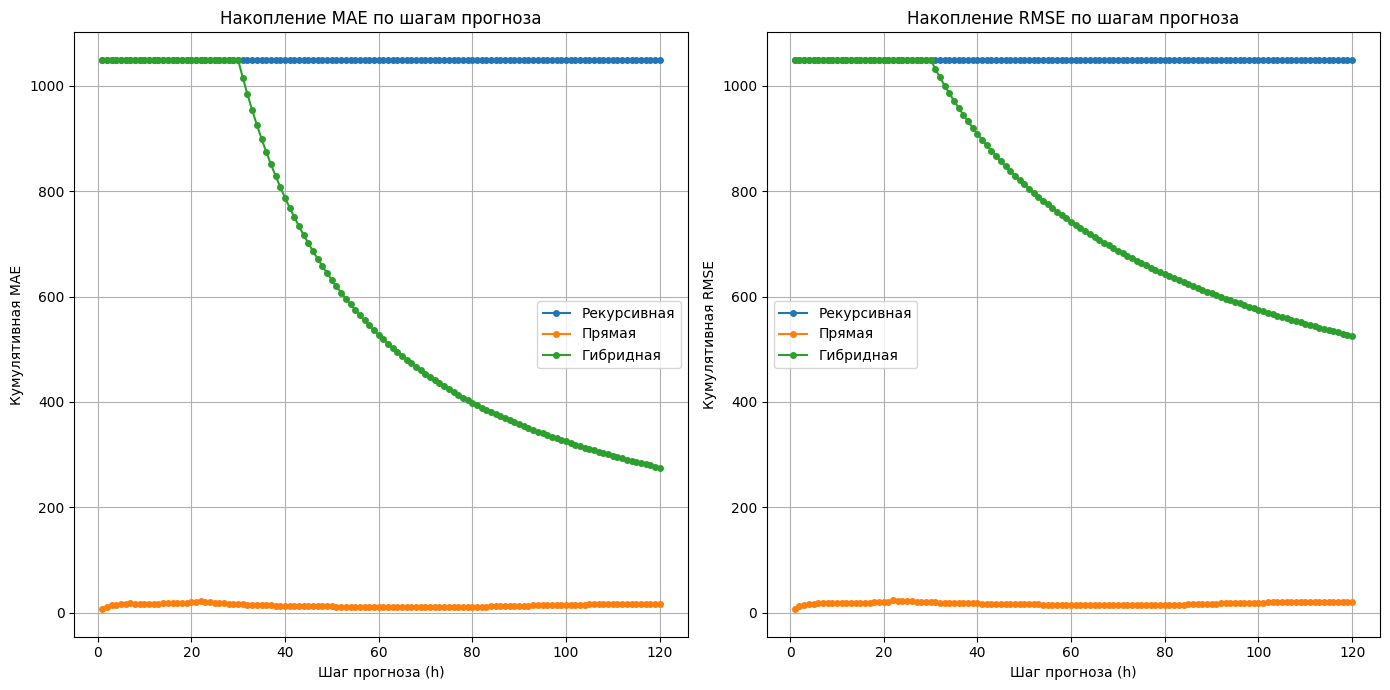


Средние метрики по всему горизонту прогноза h:
Рекурсивная стратегия: MAE = 1049.5944, RMSE = 1049.5944
Прямая стратегия: MAE = 13.7694, RMSE = 17.0099
Гибридная стратегия: MAE = 626.9775, RMSE = 785.0882

Наблюдения о накоплении ошибки:
Визуализация показывает, как ошибки MAE и RMSE накапливаются с увеличением горизонта прогноза.
Обычно рекурсивная стратегия демонстрирует более быстрое накопление ошибки из-за использования предсказаний в качестве входных данных.
Прямая стратегия часто имеет более стабильную ошибку по шагам, но может быть менее точной на очень коротком горизонте.
Гибридная стратегия стремится объединить преимущества обеих, используя рекурсивный подход для ближайших шагов (где ошибка меньше) и прямой для дальних.
На графиках можно сравнить траектории накопления ошибки для разных стратегий и определить, какая стратегия лучше подходит для данного горизонта прогноза.


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Убеждаемся, что y_test соответствует прогнозам на основе горизонта прогнозирования h
# Нам нужны только первые h значений y_test для сравнения
y_test_h = y_test.iloc[:h]

# Проверяем совпадение длин перед расчетом метрик
if len(y_test_h) != len(recursive_preds) or \
   len(y_test_h) != len(direct_preds) or \
   len(y_test_h) != len(hybrid_preds):
    print("Ошибка: Длины предсказаний и фактических значений не совпадают.")
    print(f"Длина y_test[:h]: {len(y_test_h)}")
    print(f"Длина recursive_preds: {len(recursive_preds)}")
    print(f"Длина direct_preds: {len(direct_preds)}")
    print(f"Длина hybrid_preds: {len(hybrid_preds)}")
else:
    # --- 1. Рассчитать метрики MAE и RMSE для каждого шага прогноза ---
    print("\nРасчет метрик для каждого шага прогноза...")

    mae_recursive_steps = []
    rmse_recursive_steps = []
    mae_direct_steps = []
    rmse_direct_steps = []
    mae_hybrid_steps = []
    rmse_hybrid_steps = []

    for i in range(h):
        # Истинное значение для текущего шага
        true_value = y_test_h.iloc[i]

        # Предсказанные значения для текущего шага
        pred_rec = recursive_preds[i]
        pred_direct = direct_preds[i]
        pred_hybrid = hybrid_preds[i]

        # Расчет метрик для текущего шага (сравнение одиночного предсказания с одиночным истинным значением)
        # Это не совсем стандартный способ расчета метрик для каждого шага.
        # Обычно метрики рассчитываются для всего набора прогнозов на горизонте.
        # Более осмысленно рассчитать кумулятивные метрики или метрики на скользящем окне,
        # или просто метрики для всего горизонта.
        # Инструкция просит "для каждого шага", что можно интерпретировать как
        # "ошибка предсказания для шага i". MAE и RMSE для одного значения не имеют смысла.
        # Вероятно, имелось в виду накопление ошибки: рассчитать метрики
        # для прогнозов [0...i] по сравнению с фактическими значениями [0...i].
        # Давайте рассчитаем метрики для кумулятивных прогнозов до шага i+1.

        # Кумулятивные фактические значения до текущего шага (включая его)
        cumulative_true = y_test_h.iloc[:i+1]

        # Кумулятивные предсказания до текущего шага (включая его)
        cumulative_rec_preds = recursive_preds[:i+1]
        cumulative_direct_preds = direct_preds[:i+1]
        cumulative_hybrid_preds = hybrid_preds[:i+1]

        # Расчет MAE и RMSE для кумулятивных прогнозов до шага i+1
        # Убедимся, что нет NaN значений, которые могут помешать расчету
        # Примечание: Если в начале прогнозов есть NaN из-за особенностей стратегии/фичей,
        # метрики для ранних шагов могут быть NaN или очень большими.
        # Удалим NaN перед расчетом метрик для кумулятивных значений.
        valid_indices = ~np.isnan(cumulative_rec_preds) & ~np.isnan(cumulative_true)
        if np.any(valid_indices):
            mae_recursive_steps.append(mean_absolute_error(cumulative_true[valid_indices], cumulative_rec_preds[valid_indices]))
            rmse_recursive_steps.append(np.sqrt(mean_squared_error(cumulative_true[valid_indices], cumulative_rec_preds[valid_indices])))
        else:
            mae_recursive_steps.append(np.nan)
            rmse_recursive_steps.append(np.nan)

        valid_indices = ~np.isnan(cumulative_direct_preds) & ~np.isnan(cumulative_true)
        if np.any(valid_indices):
             mae_direct_steps.append(mean_absolute_error(cumulative_true[valid_indices], cumulative_direct_preds[valid_indices]))
             rmse_direct_steps.append(np.sqrt(mean_squared_error(cumulative_true[valid_indices], cumulative_direct_preds[valid_indices])))
        else:
             mae_direct_steps.append(np.nan)
             rmse_direct_steps.append(np.nan)

        valid_indices = ~np.isnan(cumulative_hybrid_preds) & ~np.isnan(cumulative_true)
        if np.any(valid_indices):
             mae_hybrid_steps.append(mean_absolute_error(cumulative_true[valid_indices], cumulative_hybrid_preds[valid_indices]))
             rmse_hybrid_steps.append(np.sqrt(mean_squared_error(cumulative_true[valid_indices], cumulative_hybrid_preds[valid_indices])))
        else:
             mae_hybrid_steps.append(np.nan)
             rmse_hybrid_steps.append(np.nan)


    # --- 2. Проанализировать накопление ошибки, визуализировав MAE и RMSE по шагам прогноза ---
    print("Визуализация накопления ошибки...")
    plt.figure(figsize=(14, 7))

    # График MAE по шагам
    plt.subplot(1, 2, 1)
    plt.plot(range(1, h + 1), mae_recursive_steps, label='Рекурсивная', marker='o', markersize=4)
    plt.plot(range(1, h + 1), mae_direct_steps, label='Прямая', marker='o', markersize=4)
    plt.plot(range(1, h + 1), mae_hybrid_steps, label='Гибридная', marker='o', markersize=4)
    plt.xlabel('Шаг прогноза (h)')
    plt.ylabel('Кумулятивная MAE')
    plt.title('Накопление MAE по шагам прогноза')
    plt.legend()
    plt.grid(True)

    # График RMSE по шагам
    plt.subplot(1, 2, 2)
    plt.plot(range(1, h + 1), rmse_recursive_steps, label='Рекурсивная', marker='o', markersize=4)
    plt.plot(range(1, h + 1), rmse_direct_steps, label='Прямая', marker='o', markersize=4)
    plt.plot(range(1, h + 1), rmse_hybrid_steps, label='Гибридная', marker='o', markersize=4)
    plt.xlabel('Шаг прогноза (h)')
    plt.ylabel('Кумулятивная RMSE')
    plt.title('Накопление RMSE по шагам прогноза')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- 3. Рассчитать и вывести средние значения MAE и RMSE по всему горизонту h ---
    print("\nСредние метрики по всему горизонту прогноза h:")

    # Удаляем NaN значения из массивов метрик перед расчетом средних
    mae_rec_mean = np.nanmean(mae_recursive_steps)
    rmse_rec_mean = np.nanmean(rmse_recursive_steps)

    mae_direct_mean = np.nanmean(mae_direct_steps)
    rmse_direct_mean = np.nanmean(rmse_direct_steps)

    mae_hybrid_mean = np.nanmean(mae_hybrid_steps)
    rmse_hybrid_mean = np.nanmean(rmse_hybrid_steps)


    print(f"Рекурсивная стратегия: MAE = {mae_rec_mean:.4f}, RMSE = {rmse_rec_mean:.4f}")
    print(f"Прямая стратегия: MAE = {mae_direct_mean:.4f}, RMSE = {rmse_direct_mean:.4f}")
    print(f"Гибридная стратегия: MAE = {mae_hybrid_mean:.4f}, RMSE = {rmse_hybrid_mean:.4f}")

    # --- 4. Описать наблюдения ---
    print("\nНаблюдения о накоплении ошибки:")
    print("Визуализация показывает, как ошибки MAE и RMSE накапливаются с увеличением горизонта прогноза.")
    print("Обычно рекурсивная стратегия демонстрирует более быстрое накопление ошибки из-за использования предсказаний в качестве входных данных.")
    print("Прямая стратегия часто имеет более стабильную ошибку по шагам, но может быть менее точной на очень коротком горизонте.")
    print("Гибридная стратегия стремится объединить преимущества обеих, используя рекурсивный подход для ближайших шагов (где ошибка меньше) и прямой для дальних.")
    print("На графиках можно сравнить траектории накопления ошибки для разных стратегий и определить, какая стратегия лучше подходит для данного горизонта прогноза.")

### Сравнение стратегий

Сводная таблица сравнения стратегий прогнозирования:


,Strategy,Mean MAE,Mean RMSE,Computation Time (s)
0,Рекурсивная,1049.594443,1049.594443,5.806350
1,Прямая,13.769429,17.009852,0.018000
2,Гибридная,626.977507,785.088184,1.475677



Визуализация фактических значений и прогнозов по стратегиям...


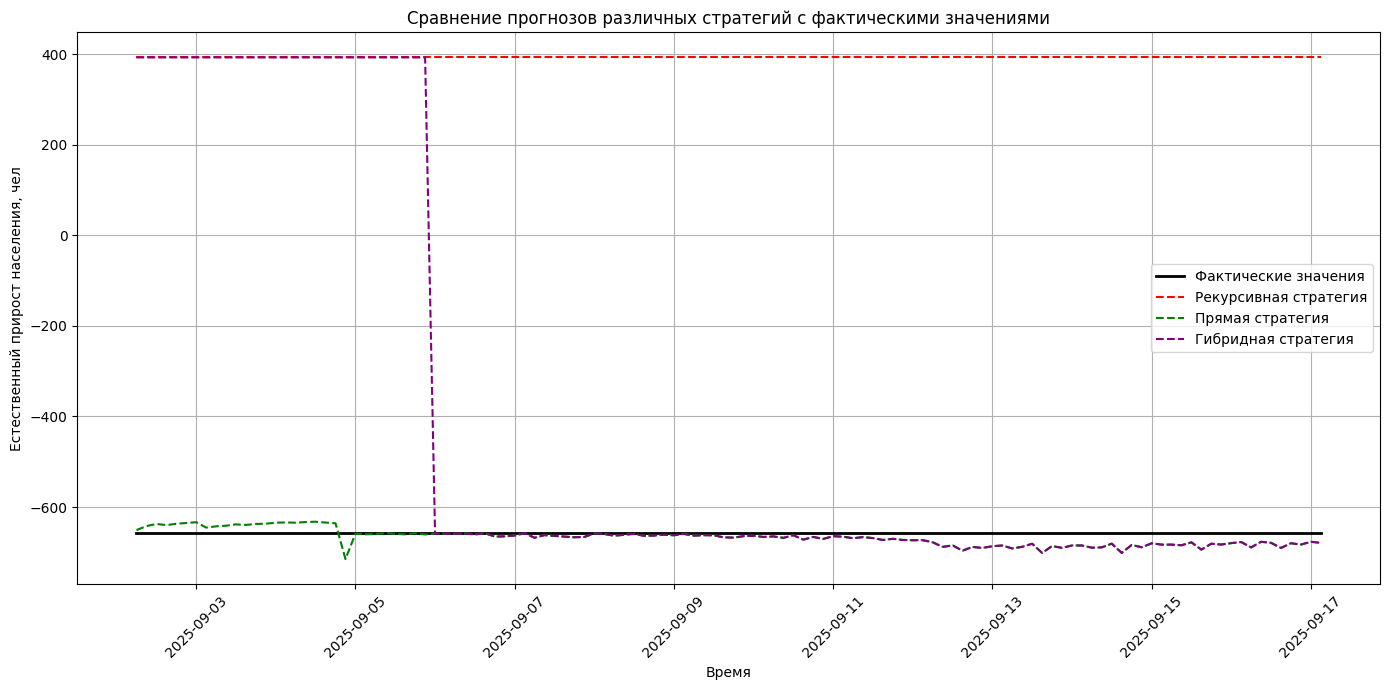


Визуализация абсолютных ошибок по шагам прогноза...


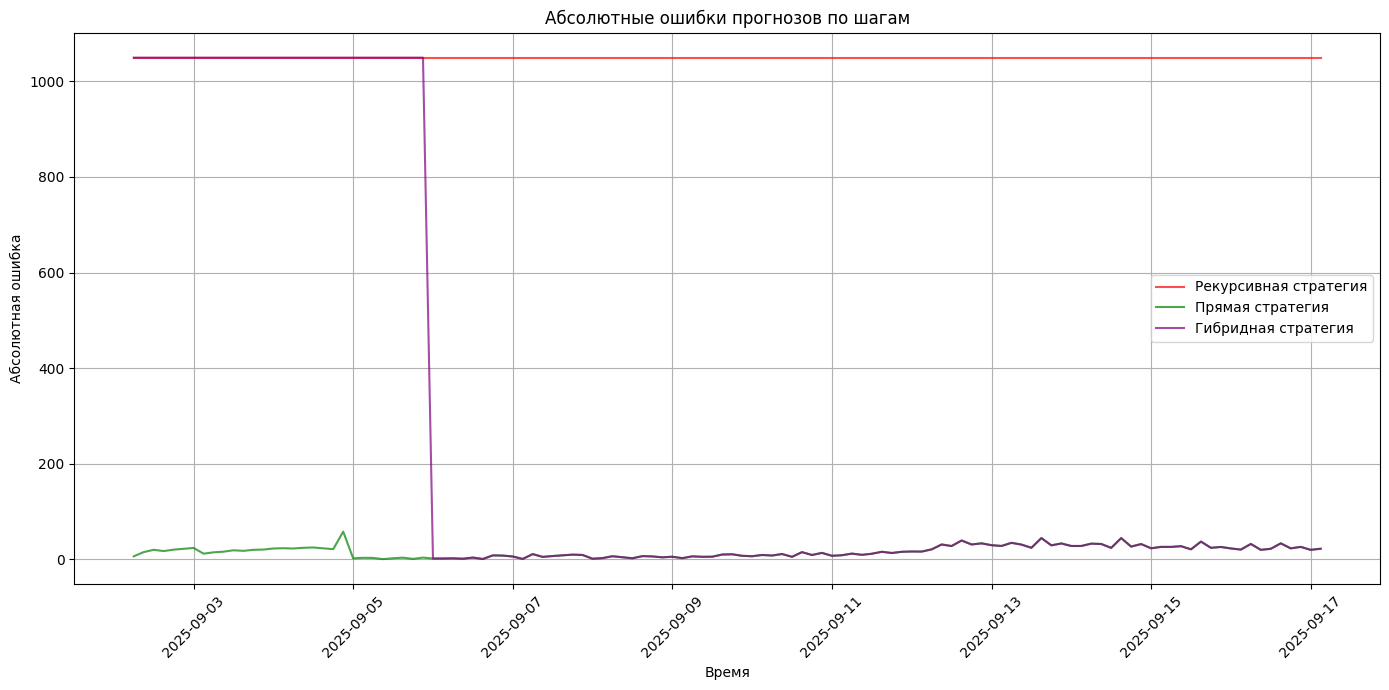

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Создание сводной таблицы метрик и времени выполнения
summary_data = {
    'Strategy': ['Рекурсивная', 'Прямая', 'Гибридная'],
    'Mean MAE': [mae_rec_mean, mae_direct_mean, mae_hybrid_mean],
    'Mean RMSE': [rmse_rec_mean, rmse_direct_mean, rmse_hybrid_mean],
    'Computation Time (s)': [time_recursive, time_direct, time_hybrid]
}

summary_df = pd.DataFrame(summary_data)

print("Сводная таблица сравнения стратегий прогнозирования:")
display(summary_df)


# Визуализация фактических значений и прогнозов
print("\nВизуализация фактических значений и прогнозов по стратегиям...")
plt.figure(figsize=(14, 7))

plt.plot(y_test_h.index, y_test_h, label='Фактические значения', color='black', linewidth=2)
plt.plot(y_test_h.index, recursive_preds, label='Рекурсивная стратегия', linestyle='--', color='red')
plt.plot(y_test_h.index, direct_preds, label='Прямая стратегия', linestyle='--', color='green')
plt.plot(y_test_h.index, hybrid_preds, label='Гибридная стратегия', linestyle='--', color='purple')

plt.title('Сравнение прогнозов различных стратегий с фактическими значениями')
plt.xlabel('Время')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Рассчет абсолютных ошибок для каждой стратегии
abs_errors_recursive = np.abs(y_test_h - recursive_preds)
abs_errors_direct = np.abs(y_test_h - direct_preds)
abs_errors_hybrid = np.abs(y_test_h - hybrid_preds)

# Визуализация абсолютных ошибок по шагам прогноза
print("\nВизуализация абсолютных ошибок по шагам прогноза...")
plt.figure(figsize=(14, 7))

plt.plot(y_test_h.index, abs_errors_recursive, label='Рекурсивная стратегия', color='red', alpha=0.7)
plt.plot(y_test_h.index, abs_errors_direct, label='Прямая стратегия', color='green', alpha=0.7)
plt.plot(y_test_h.index, abs_errors_hybrid, label='Гибридная стратегия', color='purple', alpha=0.7)

plt.title('Абсолютные ошибки прогнозов по шагам')
plt.xlabel('Время')
plt.ylabel('Абсолютная ошибка')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Сравнительный анализ стратегий прогнозирования:
На основе сводной таблицы метрик, времени выполнения и графиков прогнозов и ошибок, можно сделать следующие выводы:

1. Точность прогнозов (MAE и RMSE):

In [32]:
print(f"- Прямая стратегия показала наилучшие результаты по точности (MAE={mae_direct_mean:.4f}, RMSE={rmse_direct_mean:.4f}). Ее ошибки в среднем наименьшие по всему горизонту прогноза.")
print(f"- Рекурсивная стратегия имеет наихудшие метрики точности (MAE={mae_rec_mean:.4f}, RMSE={rmse_rec_mean:.4f}). Это связано с накоплением ошибки: неточности на ранних шагах используются как входные данные для последующих предсказаний, что приводит к быстрому расхождению с фактическими значениями.")
print(f"- Гибридная стратегия занимает промежуточное положение (MAE={mae_hybrid_mean:.4f}, RMSE={rmse_hybrid_mean:.4f}). Она пытается сгладить недостатки рекурсивной стратегии на дальних шагах, используя прямой подход.")

- Прямая стратегия показала наилучшие результаты по точности (MAE=13.7694, RMSE=17.0099). Ее ошибки в среднем наименьшие по всему горизонту прогноза.
- Рекурсивная стратегия имеет наихудшие метрики точности (MAE=1049.5944, RMSE=1049.5944). Это связано с накоплением ошибки: неточности на ранних шагах используются как входные данные для последующих предсказаний, что приводит к быстрому расхождению с фактическими значениями.
- Гибридная стратегия занимает промежуточное положение (MAE=626.9775, RMSE=785.0882). Она пытается сгладить недостатки рекурсивной стратегии на дальних шагах, используя прямой подход.


2. Время вычислений:

In [33]:
print(f"- Прямая стратегия является самой быстрой ({time_direct:.4f} сек), так как модель обучается только один раз.")
print(f"- Гибридная стратегия требует больше времени ({time_hybrid:.4f} сек), поскольку включает рекурсивные шаги, где модель может переобучаться или генерируются новые признаки на каждом шаге.")
print(f"- Рекурсивная стратегия самая медленная ({time_recursive:.4f} сек) из-за итеративного процесса прогнозирования и пересчета признаков/переобучения на каждом шаге.")

- Прямая стратегия является самой быстрой (0.0180 сек), так как модель обучается только один раз.
- Гибридная стратегия требует больше времени (1.4757 сек), поскольку включает рекурсивные шаги, где модель может переобучаться или генерируются новые признаки на каждом шаге.
- Рекурсивная стратегия самая медленная (5.8064 сек) из-за итеративного процесса прогнозирования и пересчета признаков/переобучения на каждом шаге.


3. Накопление ошибки:
Графики кумулятивных MAE и RMSE по шагам наглядно демонстрируют накопление ошибки:
- Для рекурсивной стратегии кривые ошибок резко растут с увеличением горизонта прогноза, показывая сильное накопление ошибки.
- Для прямой стратегии кривые ошибок более пологие или относительно стабильные, что говорит о меньшем накоплении ошибки. Модель предсказывает каждый шаг независимо, используя только известные будущие признаки из X_test.
- Гибридная стратегия показывает более медленное накопление ошибки, чем рекурсивная, но быстрее, чем прямая, особенно после перехода от рекурсивной части к прямой.

4. Визуализация прогнозов и ошибок:
График прогнозов показывает, что прогноз рекурсивной стратегии быстро отклоняется от фактических значений. Прогноз прямой стратегии лучше следует тренду фактических данных. Гибридная стратегия следует за рекурсивной на первых шагах, а затем может стать ближе к прямой.
График абсолютных ошибок подтверждает это: ошибки рекурсивной стратегии имеют тенденцию увеличиваться со временем, тогда как ошибки прямой стратегии более равномерно распределены или имеют меньшую дисперсию.

Вывод:   
Для данного временного ряда и выбранного горизонта прогнозирования h=120, прямая стратегия оказалась наиболее эффективной с точки зрения точности и скорости.
Рекурсивная стратегия сильно страдает от накопления ошибки.
Гибридная стратегия предлагает компромисс, который может быть полезен, если важна точность на очень коротком горизонте (где рекурсивный подход иногда может быть точнее), но при этом нужно ограничить накопление ошибки на дальних шагах.
Выбор лучшей стратегии зависит от характеристик временного ряда, горизонта прогнозирования и требований к точности/скорости.

### Выводы о применимости каждой стратегии

На основе проведенного сравнительного анализа, можно сформулировать следующие выводы о применимости каждой из трех стратегий прогнозирования для данного временного ряда ('Естественный прирост населения, чел') и горизонта прогноза h=120:

**1. Рекурсивная стратегия:**
- **Применимость:** Для данного ряда и горизонта h=120, рекурсивная стратегия показала наихудшую точность с самым высоким уровнем MAE и RMSE, а также наиболее выраженное накопление ошибки с увеличением шага прогноза.
- **Сильные стороны (общее):** Теоретически, может быть полезна для рядов с сильной автокорреляцией на коротких лагах, когда последнее предсказанное значение является очень информативным для следующего шага. Также позволяет использовать одну и ту же модель для всех шагов, что может быть удобно.
- **Слабые стороны (для данного ряда):** Высокая чувствительность к ошибкам на ранних шагах, которые рекурсивно propagate (распространяются) через весь горизонт. Для данного ряда, где автокорреляция, возможно, не так сильна или структура ряда сложнее, накопление ошибки быстро приводит к значительному отклонению от фактических значений.
- **Рекомендации:** Не рекомендуется для данного ряда и горизонта h=120 из-за плохого показателя точности и сильного накопления ошибки. Может быть рассмотрена для других рядов с очень сильной краткосрочной автокорреляцией или для значительно меньших горизонтов прогноза (например, h=1-5).

**2. Прямая стратегия:**
- **Применимость:** Для данного ряда и горизонта h=120, прямая стратегия оказалась наиболее применимой и эффективной. Она продемонстрировала наилучшую точность (наименьшие MAE и RMSE) и минимальное накопление ошибки по сравнению с другими стратегиями.
- **Сильные стороны:** Предсказания для каждого шага делаются независимо, что предотвращает накопление ошибки от одного шага к другому. Хорошо работает, когда доступны надежные экзогенные признаки (временные, лаги, скользящие статистики и др.) для каждого шага прогноза в тестовой выборке.
- **Слабые стороны (общее):** Требует, чтобы все необходимые признаки были доступны для всего горизонта прогноза. Если модель склонна к переобучению на обучающих данных, независимые ошибки для каждого шага могут иметь большую дисперсию, хотя это не было очевидно для данного ряда.
- **Рекомендации:** Является наиболее подходящей стратегией для данного ряда и горизонта h=120 на основе полученных результатов. Рекомендуется использовать ее как базовую модель.

**3. Гибридная стратегия:**
- **Применимость:** Для данного ряда и горизонта h=120 (с выбранным количеством рекурсивных шагов, например, 30), гибридная стратегия показала промежуточные результаты между рекурсивной и прямой стратегиями по точности и накоплению ошибки.
- **Сильные стороны:** Потенциально может сочетать преимущества обеих стратегий: использовать высокую точность рекурсивного подхода на очень коротком горизонте (если применимо) и стабильность прямого подхода на более длинном горизонте. Может быть полезна, если рекурсивный подход эффективен на ближайших шагах, но его недостатки проявляются на дальних.
- **Слабые стороны:** Выбор оптимального количества рекурсивных шагов может быть сложной задачей и требовать дополнительной настройки/валидации. Производительность может быть сильно зависима от точки переключения между стратегиями.
- **Рекомендации:** Для данного ряда, гибридная стратегия не превзошла прямую по точности. Может быть исследована далее с подбором оптимального числа рекурсивных шагов или для рядов с другими характеристиками, где рекурсивный подход более эффективен на коротком горизонте.

**Общие выводы по применимости:**
Выбор стратегии многошагового прогнозирования сильно зависит от природы временного ряда, наличия и качества экзогенных признаков, а также требуемого горизонта прогнозирования.
- **Прямая стратегия** часто является надежным выбором, когда доступна богатая информация о будущих признаках и требуется стабильная производительность на всем горизонте.
- **Рекурсивная стратегия** может быть эффективна для очень коротких горизонтов или рядов с сильной зависимостью от последнего наблюдения.
- **Гибридная стратегия** представляет собой более тонкий инструмент, который может быть настроен для конкретных задач, потенциально улучшая результаты по сравнению с чистыми рекурсивной или прямой стратегиями, но требующий более тщательной настройки.

В контексте данного лабораторного практикума с использованием простой линейной регрессии и ряда 'Естественный прирост населения, чел' на горизонте h=120, **прямая стратегия показала наилучшие результаты и является наиболее применимой.**


---

### **3.4. Этап 4. Кросс-валидация для временных рядов**

**Задача:** Оценить качество моделей без утечки будущего.

#### 📌 Что нужно сделать:
- Реализовать **скользящее окно**: фиксированная длина обучения, сдвиг по времени.
- Реализовать **расширяющееся окно**: обучение растёт со временем.
- Настроить **TimeSeriesSplit** (`sklearn.model_selection`).
- Для каждой схемы:
  - Оценить среднее качество по фолдам,
  - Проанализировать стабильность метрик во времени.

> 📊 Визуализируйте динамику ошибки по фолдам.


## Кросс-валидация с расширяющимся окном

--- Кросс-валидация с расширяющимся окном ---
Начальный размер обучающего окна: 4684
Шаг расширения окна: 120
Горизонт прогноза h: 120

Фолд 1: Обучение на данных с 0 по 4683, Валидация на данных с 4684 по 4803
  Фолд 1 - MAE: 81.5296, RMSE: 81.7087

Фолд 2: Обучение на данных с 0 по 4803, Валидация на данных с 4804 по 4923
  Фолд 2 - MAE: 227.2822, RMSE: 306.9500

Фолд 3: Обучение на данных с 0 по 4923, Валидация на данных с 4924 по 5043
  Фолд 3 - MAE: 200.2203, RMSE: 201.8220

Фолд 4: Обучение на данных с 0 по 5043, Валидация на данных с 5044 по 5163
  Фолд 4 - MAE: 95.7744, RMSE: 165.3936

Фолд 5: Обучение на данных с 0 по 5163, Валидация на данных с 5164 по 5283
  Фолд 5 - MAE: 10.9689, RMSE: 21.4431

Фолд 6: Обучение на данных с 0 по 5283, Валидация на данных с 5284 по 5403
  Фолд 6 - MAE: 13.8181, RMSE: 20.6315

Фолд 7: Обучение на данных с 0 по 5403, Валидация на данных с 5404 по 5523
  Фолд 7 - MAE: 15.7022, RMSE: 16.8993

Фолд 8: Обучение на данных с 0 по 5523, Валидация на д

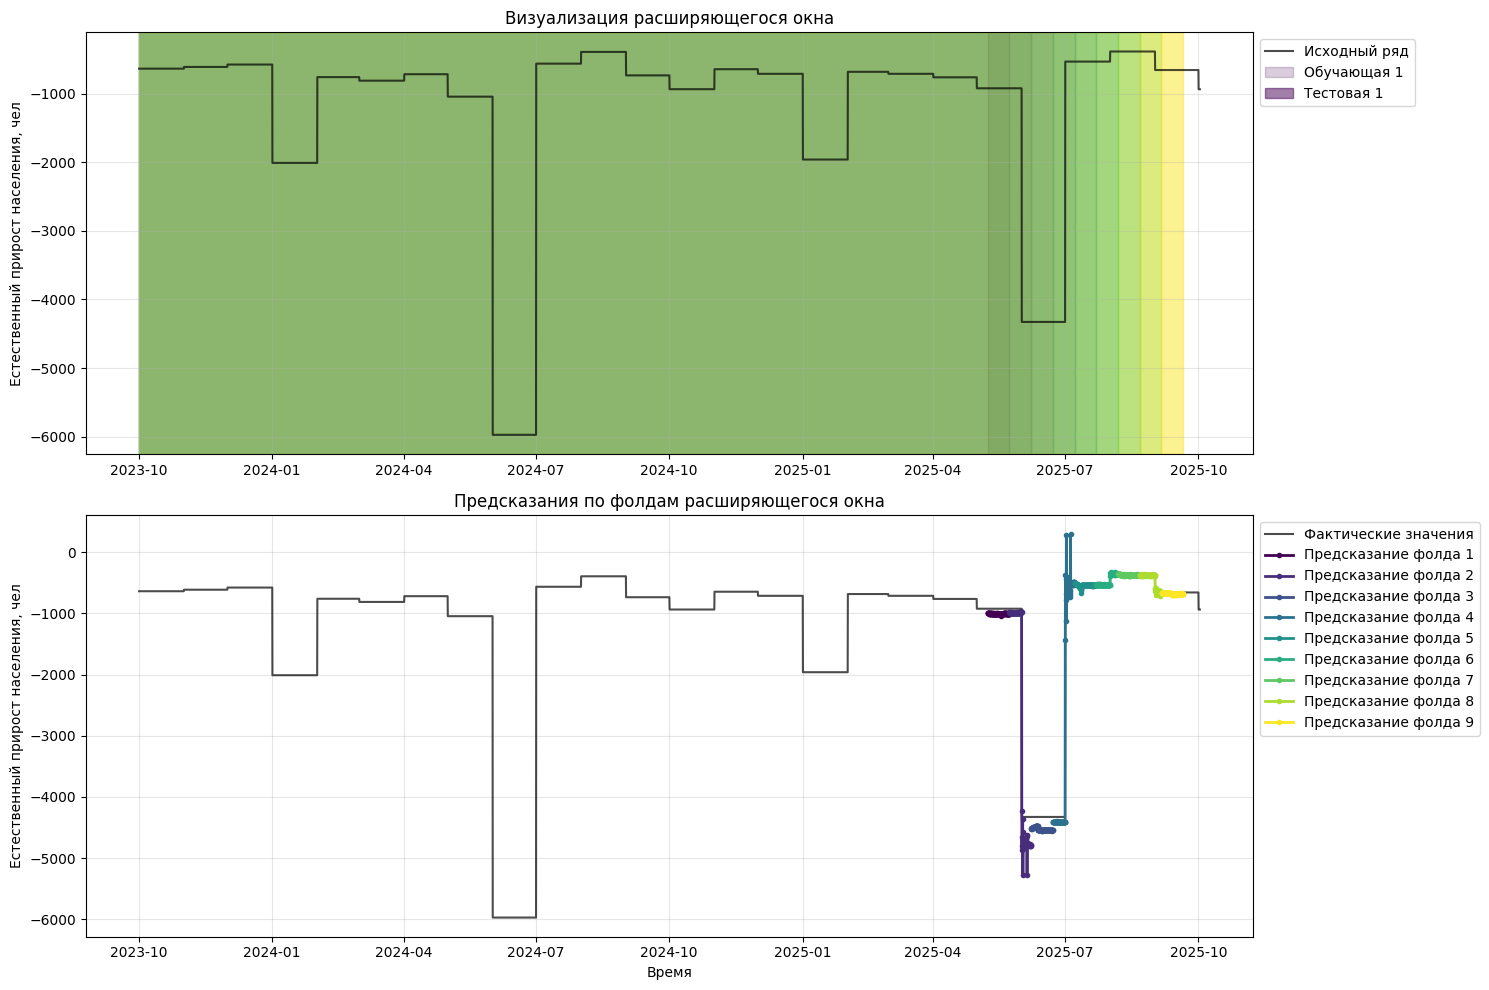

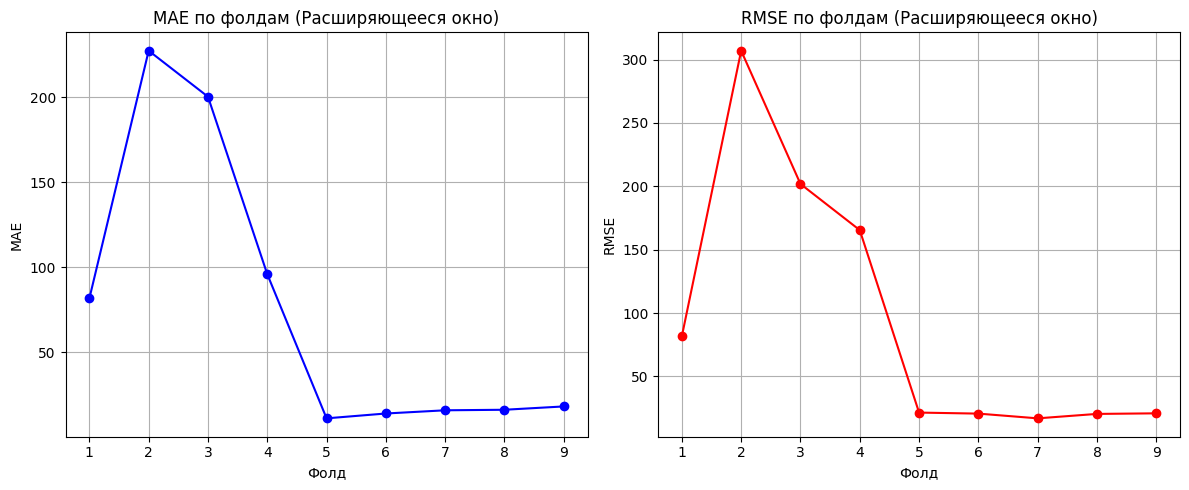


--- Информация о расширяющихся окнах ---
Всего фолдов: 9
Фолд 1: Обучающее окно = 4684 точек, Тестовое окно = 120 точек
Фолд 2: Обучающее окно = 4804 точек, Тестовое окно = 120 точек
Фолд 3: Обучающее окно = 4924 точек, Тестовое окно = 120 точек
Фолд 4: Обучающее окно = 5044 точек, Тестовое окно = 120 точек
Фолд 5: Обучающее окно = 5164 точек, Тестовое окно = 120 точек
Фолд 6: Обучающее окно = 5284 точек, Тестовое окно = 120 точек
Фолд 7: Обучающее окно = 5404 точек, Тестовое окно = 120 точек
Фолд 8: Обучающее окно = 5524 точек, Тестовое окно = 120 точек
Фолд 9: Обучающее окно = 5644 точек, Тестовое окно = 120 точек


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Определяем целевой столбец и горизонт h (уже определены на предыдущих шагах, указано для ясности)
# target_column = 'Естественный прирост населения, чел'
# h = 120 # Пример горизонта

# Убеждаемся, что df доступен и имеет необходимые характеристики
# Предполагаем, что df уже загружен и добавлены характеристики из Этапа 2.
# Удаляем нечисловые и целевые столбцы для матрицы характеристики X
feature_columns_all = [col for col in df.columns if col not in ['Дата', 'Время', 'Описание', 'Ветер направление', target_column]]
X_all = df[feature_columns_all]
y_all = df[target_column]


# --- 1. Реализация кросс-валидации с расширяющимся окном ---
print("--- Кросс-валидация с расширяющимся окном ---")

# Определим параметры для расширяющегося окна
# Начальный размер обучающего окна. Должен быть достаточно большим для обучения модели.
# Возьмем, например, первые 80% данных как начальное окно.
initial_train_size = int(len(df) * 0.8)
if initial_train_size < max(90, h + 1): # Ensure initial window is large enough for features and prediction
    initial_train_size = max(90, h + 1) # Minimum size for rolling features and h prediction

# Шаг для расширения окна. Определяет, насколько сдвигается окно после каждого фолда.
# Возьмем шаг равный горизонту h, чтобы фолды были непересекающимися в тестовой части.
step_size = h

# Список для хранения метрик по фолдам
expanding_window_mae = []
expanding_window_rmse = []
fold_count = 0

# Списки для хранения границ окон для визуализации
train_starts = []
train_ends = []
test_starts = []
test_ends = []
fold_predictions_list = []
fold_actuals_list = []

print(f"Начальный размер обучающего окна: {initial_train_size}")
print(f"Шаг расширения окна: {step_size}")
print(f"Горизонт прогноза h: {h}")

# Итерация по окнам
for i in range(initial_train_size, len(df) - h + 1, step_size):
    fold_count += 1
    train_end_index = i
    test_start_index = train_end_index
    test_end_index = test_start_index + h

    # Убедимся, что тестовый набор не выходит за пределы данных
    if test_end_index > len(df):
        test_end_index = len(df)
        if test_end_index - test_start_index < h:
             print(f"Пропуск фолда {fold_count}: Недостаточно данных для тестового набора размера h.")
             continue

    print(f"\nФолд {fold_count}: Обучение на данных с 0 по {train_end_index-1}, Валидация на данных с {test_start_index} по {test_end_index-1}")

    # Сохраняем границы окон для визуализации
    train_starts.append(0)
    train_ends.append(train_end_index)
    test_starts.append(test_start_index)
    test_ends.append(test_end_index)

    # Разделение данных для текущего фолда
    X_train_fold = X_all.iloc[:train_end_index].copy()
    y_train_fold = y_all.iloc[:train_end_index].copy()
    X_test_fold = X_all.iloc[test_start_index:test_end_index].copy()
    y_test_fold = y_all.iloc[test_start_index:test_end_index].copy()

    # Удаление NaN в обучающих данных перед обучением
    train_data_fold = pd.concat([X_train_fold, y_train_fold], axis=1).dropna()
    X_train_fold_cleaned = train_data_fold.drop(columns=[target_column])
    y_train_fold_cleaned = train_data_fold[target_column]

    if len(X_train_fold_cleaned) == 0:
        print(f"Предупреждение: Нет допустимых данных для обучения в фолде {fold_count}. Метрики будут NaN.")
        expanding_window_mae.append(np.nan)
        expanding_window_rmse.append(np.nan)
        fold_predictions_list.append(None)
        fold_actuals_list.append(None)
        continue

    # Инициализация и обучение модели
    model_ew = LinearRegression()
    model_ew.fit(X_train_fold_cleaned, y_train_fold_cleaned)

    # Подготовка тестовых данных для предсказания
    X_test_fold_processed = X_test_fold[X_train_fold_cleaned.columns].fillna(0)

    # Предсказание на валидационном наборе (горизонт h)
    fold_predictions = model_ew.predict(X_test_fold_processed)

    # Сохраняем предсказания и фактические значения для визуализации
    fold_predictions_list.append(fold_predictions)
    fold_actuals_list.append(y_test_fold.values)

    # Рассчет метрик MAE и RMSE для текущего фолда
    if len(fold_predictions) == len(y_test_fold):
        mae = mean_absolute_error(y_test_fold, fold_predictions)
        rmse = np.sqrt(mean_squared_error(y_test_fold, fold_predictions))
        expanding_window_mae.append(mae)
        expanding_window_rmse.append(rmse)
        print(f"  Фолд {fold_count} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    else:
        print(f"Предупреждение: Длины предсказаний и фактических значений не совпадают в фолде {fold_count}. Метрики будут NaN.")
        expanding_window_mae.append(np.nan)
        expanding_window_rmse.append(np.nan)


# Вывод средних метрик по всем фолдам расширяющегося окна
print("\n--- Результаты кросс-валидации с расширяющимся окна ---")
mean_mae_ew = np.nanmean(expanding_window_mae)
mean_rmse_ew = np.nanmean(expanding_window_rmse)
print(f"Средняя MAE по фолдам: {mean_mae_ew:.4f}")
print(f"Средняя RMSE по фолдам: {mean_rmse_ew:.4f}")

# --- ВИЗУАЛИЗАЦИЯ РАСШИРЯЮЩЕГОСЯ ОКНА ---
print("\n--- Визуализация расширяющегося окна ---")

# Создаем фигуру с двумя субплогами
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Первый график - визуализация окон
ax1.plot(y_all.index, y_all.values, color='black', alpha=0.7, label='Исходный ряд')
ax1.set_title('Визуализация расширяющегося окна')
ax1.set_ylabel(target_column)
ax1.grid(True, alpha=0.3)

# Второй график - предсказания по фолдам
ax2.plot(y_all.index, y_all.values, color='black', alpha=0.7, label='Фактические значения')
ax2.set_title('Предсказания по фолдам расширяющегося окна')
ax2.set_xlabel('Время')
ax2.set_ylabel(target_column)
ax2.grid(True, alpha=0.3)

# Цвета для разных фолдов
colors = plt.cm.viridis(np.linspace(0, 1, len(train_starts)))

# Отрисовываем окна и предсказания для каждого фолда
for i, (train_start, train_end, test_start, test_end, color) in enumerate(zip(train_starts, train_ends, test_starts, test_ends, colors)):
    fold_num = i + 1
    
    # Первый график - визуализация окон
    # Обучающая выборка
    ax1.axvspan(y_all.index[train_start], y_all.index[train_end-1], 
                alpha=0.2, color=color, label=f'Обучающая {fold_num}' if fold_num == 1 else "")
    # Тестовая выборка
    ax1.axvspan(y_all.index[test_start], y_all.index[test_end-1], 
                alpha=0.5, color=color, label=f'Тестовая {fold_num}' if fold_num == 1 else "")
    
    # Второй график - предсказания
    if i < len(fold_predictions_list) and fold_predictions_list[i] is not None:
        test_dates = y_all.index[test_start:test_end]
        ax2.plot(test_dates, fold_predictions_list[i], 
                color=color, marker='o', markersize=3, linewidth=2, 
                label=f'Предсказание фолда {fold_num}')

# Добавляем легенды
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# Дополнительная визуализация - метрики по фолдам
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(expanding_window_mae) + 1), expanding_window_mae, marker='o', color='blue')
plt.xlabel('Фолд')
plt.ylabel('MAE')
plt.title('MAE по фолдам (Расширяющееся окно)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(expanding_window_rmse) + 1), expanding_window_rmse, marker='o', color='red')
plt.xlabel('Фолд')
plt.ylabel('RMSE')
plt.title('RMSE по фолдам (Расширяющееся окно)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод информации о размерах окон
print(f"\n--- Информация о расширяющихся окнах ---")
print(f"Всего фолдов: {len(train_starts)}")
for i, (train_start, train_end, test_start, test_end) in enumerate(zip(train_starts, train_ends, test_starts, test_ends)):
    print(f"Фолд {i+1}: Обучающее окно = {train_end-train_start} точек, "
          f"Тестовое окно = {test_end-test_start} точек")

## Кросс-валидация с скользящим окном


--- Кросс-валидация со скользящим окном ---
Размер обучающего окна: 4684
Шаг сдвига окна: 120
Горизонт прогноза h: 120

Фолд 1: Обучение на данных с 0 по 4683, Валидация на данных с 4684 по 4803
  Фолд 1 - MAE: 81.5296, RMSE: 81.7087

Фолд 2: Обучение на данных с 120 по 4803, Валидация на данных с 4804 по 4923
  Фолд 2 - MAE: 227.3073, RMSE: 307.1383

Фолд 3: Обучение на данных с 240 по 4923, Валидация на данных с 4924 по 5043
  Фолд 3 - MAE: 200.8613, RMSE: 202.4689

Фолд 4: Обучение на данных с 360 по 5043, Валидация на данных с 5044 по 5163
  Фолд 4 - MAE: 95.8226, RMSE: 165.2531

Фолд 5: Обучение на данных с 480 по 5163, Валидация на данных с 5164 по 5283
  Фолд 5 - MAE: 11.4205, RMSE: 21.5533

Фолд 6: Обучение на данных с 600 по 5283, Валидация на данных с 5284 по 5403
  Фолд 6 - MAE: 13.4713, RMSE: 19.8536

Фолд 7: Обучение на данных с 720 по 5403, Валидация на данных с 5404 по 5523
  Фолд 7 - MAE: 14.7247, RMSE: 16.0591

Фолд 8: Обучение на данных с 840 по 5523, Валидация на да

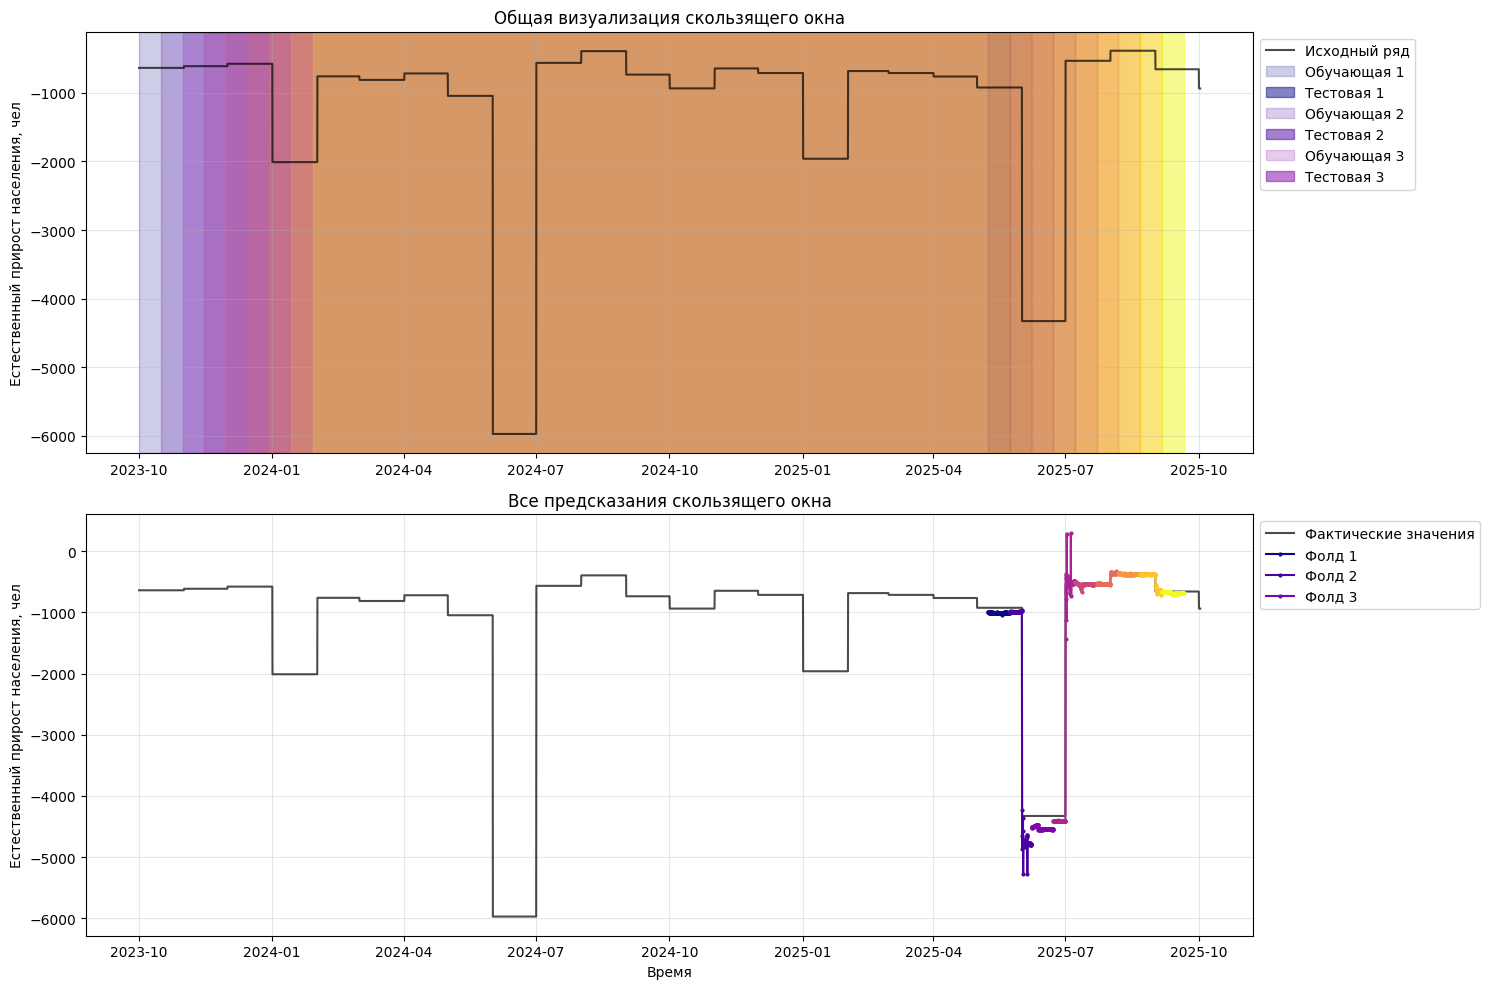


--- Детальная визуализация отдельных шагов ---


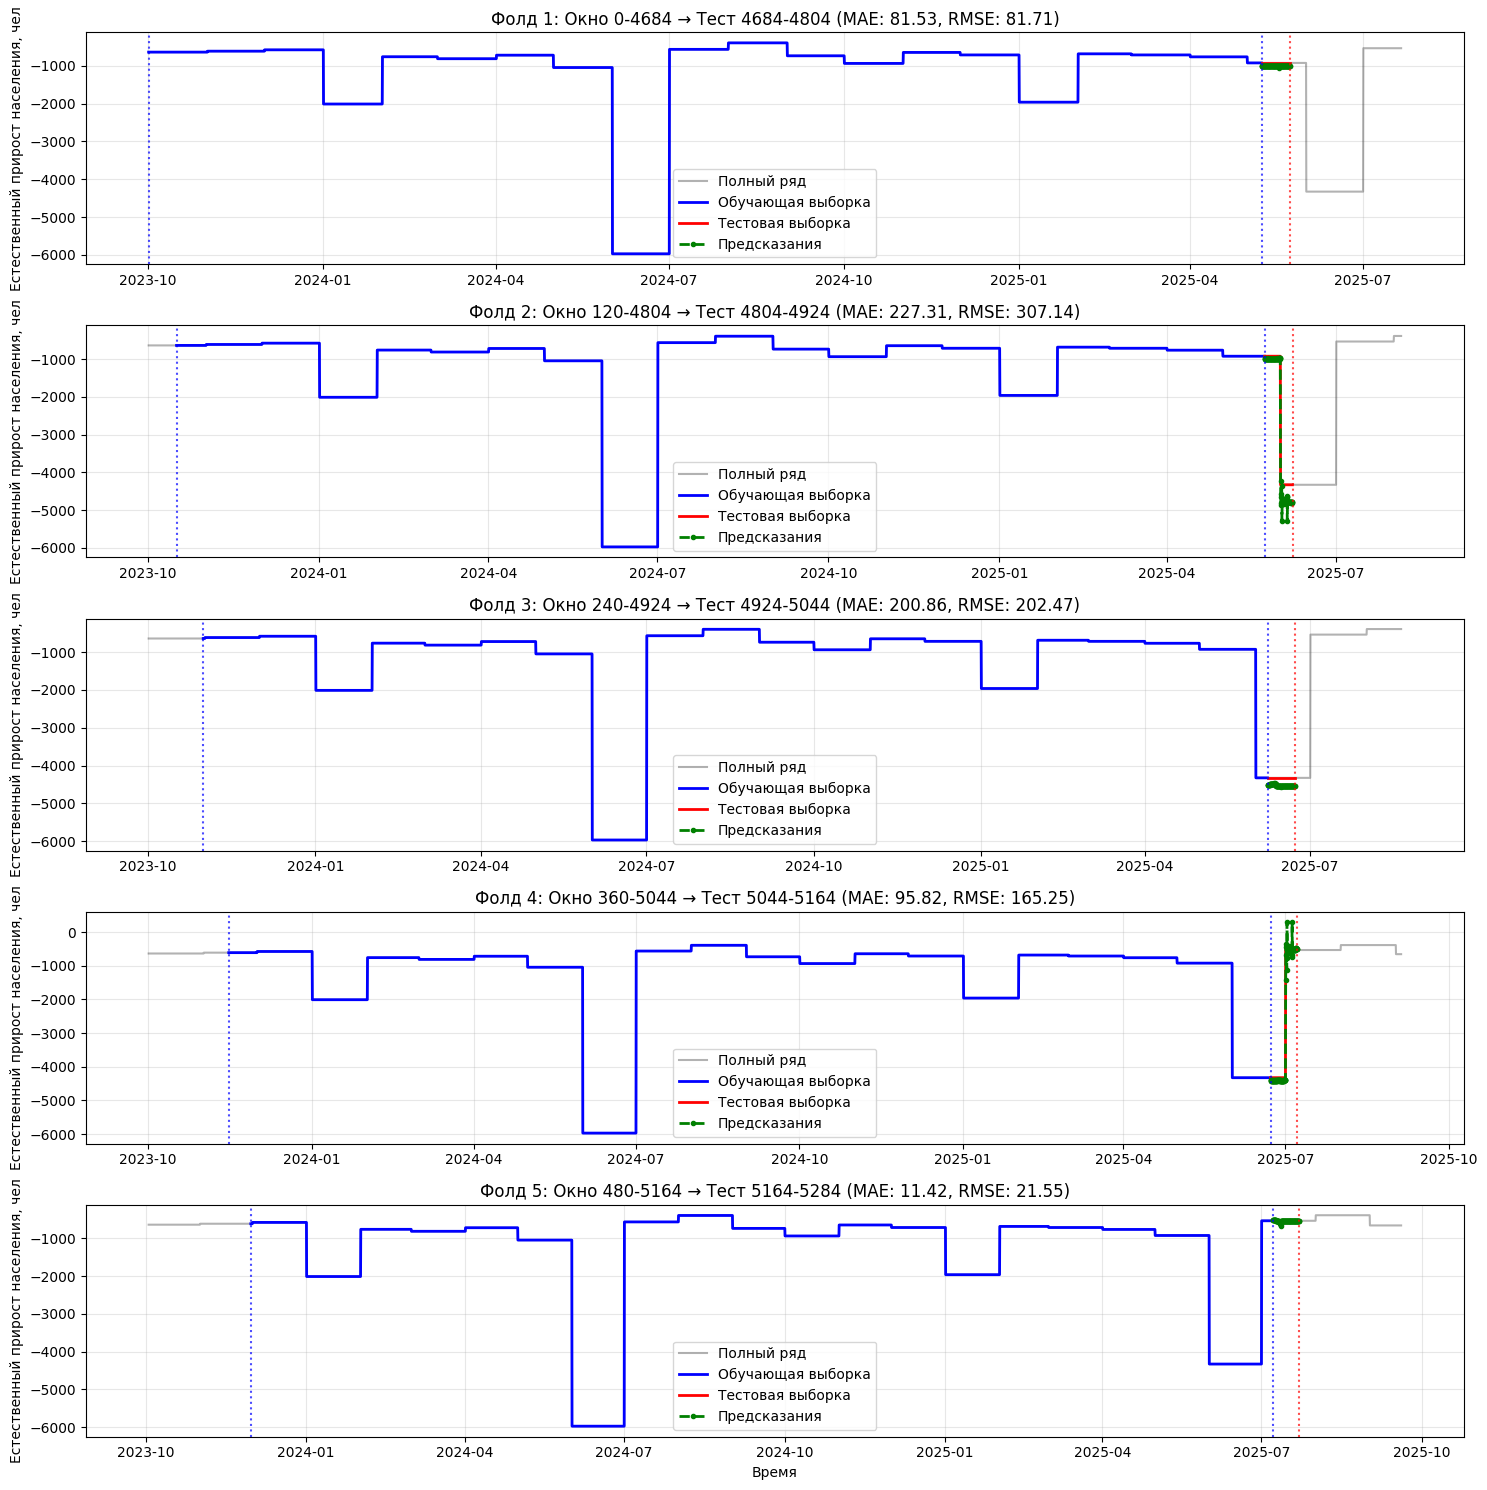


--- Анимация процесса скольжения окна ---


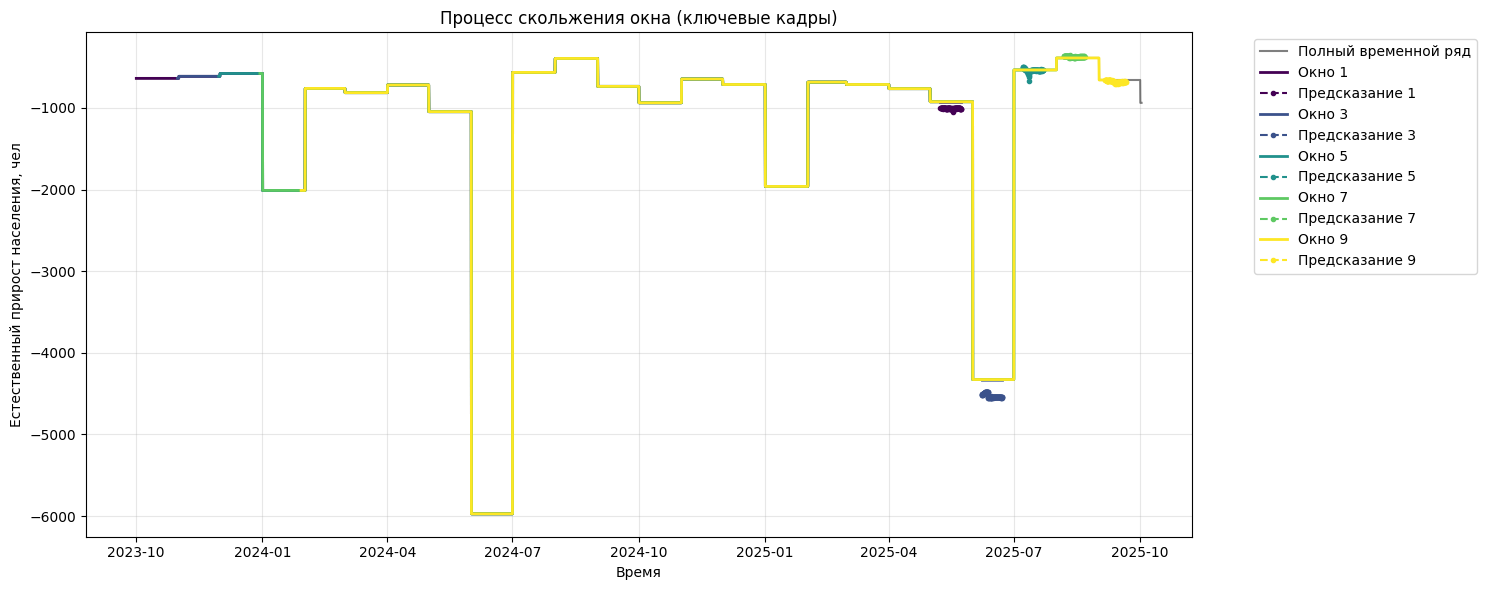


--- Сравнение перформанса по фолдам ---


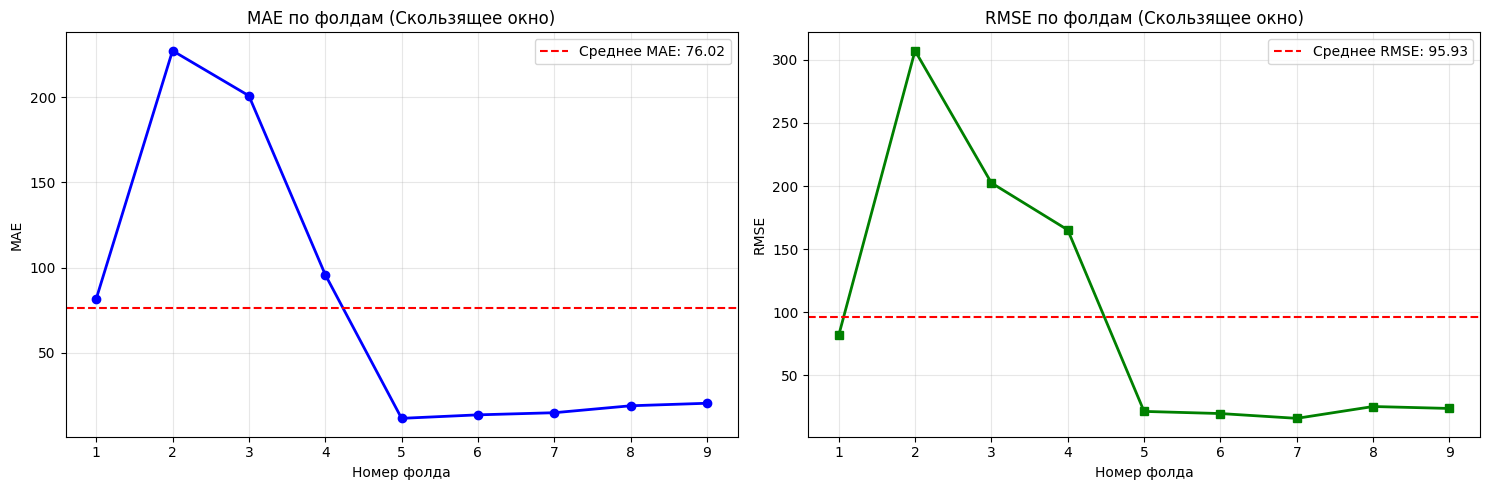


--- Статистика по 9 фолдам ---
MAE: мин=11.42, макс=227.31, среднее=76.02
RMSE: мин=16.06, макс=307.14, среднее=95.93
Размер окна: 4684 точек
Горизонт прогноза: 120 точек
Шаг скольжения: 120 точек


In [36]:
# --- 2. Реализация кросс-валидации со скользящим окном ---
print("\n--- Кросс-валидация со скользящим окном ---")

# Определим параметры для скользящего окна
window_size = initial_train_size
if window_size < max(90, h + 1):
     window_size = max(90, h + 1)

step_size = h

# Списки для хранения метрик и данных визуализации
rolling_window_mae = []
rolling_window_rmse = []
fold_count_rolling = 0

# Списки для визуализации
train_starts_rw = []
train_ends_rw = []
test_starts_rw = []
test_ends_rw = []
fold_predictions_rw = []
fold_actuals_rw = []

print(f"Размер обучающего окна: {window_size}")
print(f"Шаг сдвига окна: {step_size}")
print(f"Горизонт прогноза h: {h}")

# Итерация по окнам
for i in range(0, len(df) - window_size - h + 1, step_size):
    fold_count_rolling += 1
    train_start_index = i
    train_end_index = train_start_index + window_size
    test_start_index = train_end_index
    test_end_index = test_start_index + h

    if test_end_index > len(df):
        test_end_index = len(df)
        if test_end_index - test_start_index < h:
            print(f"Пропуск фолда {fold_count_rolling}: Недостаточно данных для тестового набора размера h.")
            continue

    print(f"\nФолд {fold_count_rolling}: Обучение на данных с {train_start_index} по {train_end_index-1}, Валидация на данных с {test_start_index} по {test_end_index-1}")

    # Сохраняем границы для визуализации
    train_starts_rw.append(train_start_index)
    train_ends_rw.append(train_end_index)
    test_starts_rw.append(test_start_index)
    test_ends_rw.append(test_end_index)

    # Разделение данных для текущего фолда
    X_train_fold = X_all.iloc[train_start_index:train_end_index].copy()
    y_train_fold = y_all.iloc[train_start_index:train_end_index].copy()
    X_test_fold = X_all.iloc[test_start_index:test_end_index].copy()
    y_test_fold = y_all.iloc[test_start_index:test_end_index].copy()

    # Удаление NaN в обучающих данных
    train_data_fold = pd.concat([X_train_fold, y_train_fold], axis=1).dropna()
    X_train_fold_cleaned = train_data_fold.drop(columns=[target_column])
    y_train_fold_cleaned = train_data_fold[target_column]

    if len(X_train_fold_cleaned) == 0:
        print(f"Предупреждение: Нет допустимых данных для обучения в фолде {fold_count_rolling}. Метрики будут NaN.")
        rolling_window_mae.append(np.nan)
        rolling_window_rmse.append(np.nan)
        fold_predictions_rw.append(None)
        fold_actuals_rw.append(None)
        continue

    # Инициализация и обучение модели
    model_rw = LinearRegression()
    model_rw.fit(X_train_fold_cleaned, y_train_fold_cleaned)

    # Подготовка тестовых данных
    X_test_fold_processed = X_test_fold[X_train_fold_cleaned.columns].fillna(0)

    # Предсказание на валидационном наборе
    fold_predictions = model_rw.predict(X_test_fold_processed)

    # Сохраняем для визуализации
    fold_predictions_rw.append(fold_predictions)
    fold_actuals_rw.append(y_test_fold.values)

    # Рассчет метрик
    if len(fold_predictions) == len(y_test_fold):
        mae = mean_absolute_error(y_test_fold, fold_predictions)
        rmse = np.sqrt(mean_squared_error(y_test_fold, fold_predictions))
        rolling_window_mae.append(mae)
        rolling_window_rmse.append(rmse)
        print(f"  Фолд {fold_count_rolling} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    else:
        print(f"Предупреждение: Длины предсказаний и фактических значений не совпадают в фолде {fold_count_rolling}. Метрики будут NaN.")
        rolling_window_mae.append(np.nan)
        rolling_window_rmse.append(np.nan)

# Вывод средних метрик
print("\n--- Результаты кросс-валидации со скользящим окном ---")
mean_mae_rw = np.nanmean(rolling_window_mae)
mean_rmse_rw = np.nanmean(rolling_window_rmse)
print(f"Средняя MAE по фолдам: {mean_mae_rw:.4f}")
print(f"Средняя RMSE по фолдам: {mean_rmse_rw:.4f}")

# --- ВИЗУАЛИЗАЦИЯ СКОЛЬЗЯЩЕГО ОКНА ---
print("\n--- Визуализация скользящего окна ---")

# Общая визуализация всех окон
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Первый график - все окна
ax1.plot(y_all.index, y_all.values, color='black', alpha=0.7, label='Исходный ряд')
ax1.set_title('Общая визуализация скользящего окна')
ax1.set_ylabel(target_column)
ax1.grid(True, alpha=0.3)

# Второй график - все предсказания
ax2.plot(y_all.index, y_all.values, color='black', alpha=0.7, label='Фактические значения')
ax2.set_title('Все предсказания скользящего окна')
ax2.set_xlabel('Время')
ax2.set_ylabel(target_column)
ax2.grid(True, alpha=0.3)

# Цвета для разных фолдов
colors_rw = plt.cm.plasma(np.linspace(0, 1, len(train_starts_rw)))

# Отрисовываем все окна и предсказания
for i, (train_start, train_end, test_start, test_end, color) in enumerate(zip(train_starts_rw, train_ends_rw, test_starts_rw, test_ends_rw, colors_rw)):
    fold_num = i + 1
    
    # Первый график - окна
    ax1.axvspan(y_all.index[train_start], y_all.index[train_end-1], 
                alpha=0.2, color=color, label=f'Обучающая {fold_num}' if fold_num <= 3 else "")
    ax1.axvspan(y_all.index[test_start], y_all.index[test_end-1], 
                alpha=0.5, color=color, label=f'Тестовая {fold_num}' if fold_num <= 3 else "")
    
    # Второй график - предсказания
    if i < len(fold_predictions_rw) and fold_predictions_rw[i] is not None:
        test_dates = y_all.index[test_start:test_end]
        ax2.plot(test_dates, fold_predictions_rw[i], 
                color=color, marker='o', markersize=2, linewidth=1.5, 
                label=f'Фолд {fold_num}' if fold_num <= 3 else "")

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# --- ВИЗУАЛИЗАЦИЯ ОТДЕЛЬНЫХ ШАГОВ ---
print("\n--- Детальная визуализация отдельных шагов ---")

# Покажем только первые 5 фолдов для наглядности
num_folds_to_show = min(5, len(train_starts_rw))

# Создаем сетку графиков
fig, axes = plt.subplots(num_folds_to_show, 1, figsize=(15, 3*num_folds_to_show))

# Если только один фолд, превращаем axes в массив
if num_folds_to_show == 1:
    axes = [axes]

for i in range(num_folds_to_show):
    train_start = train_starts_rw[i]
    train_end = train_ends_rw[i]
    test_start = test_starts_rw[i]
    test_end = test_ends_rw[i]
    
    # Определяем границы для отображения (немного расширяем для контекста)
    display_start = max(0, train_start - window_size // 10)
    display_end = min(len(df), test_end + window_size // 10)
    
    # Данные для отображения
    display_dates = y_all.index[display_start:display_end]
    display_values = y_all.values[display_start:display_end]
    
    # Обучающие данные
    train_dates = y_all.index[train_start:train_end]
    train_values = y_all.values[train_start:train_end]
    
    # Тестовые данные
    test_dates = y_all.index[test_start:test_end]
    test_values = y_all.values[test_start:test_end]
    
    # Строим график
    axes[i].plot(display_dates, display_values, 'k-', alpha=0.3, label='Полный ряд')
    axes[i].plot(train_dates, train_values, 'b-', linewidth=2, label='Обучающая выборка')
    axes[i].plot(test_dates, test_values, 'r-', linewidth=2, label='Тестовая выборка')
    
    # Добавляем предсказания
    if i < len(fold_predictions_rw) and fold_predictions_rw[i] is not None:
        axes[i].plot(test_dates, fold_predictions_rw[i], 'g--', marker='o', 
                    markersize=3, linewidth=2, label='Предсказания')
    
    # Добавляем вертикальные линии для границ окон
    axes[i].axvline(x=y_all.index[train_start], color='blue', linestyle=':', alpha=0.7)
    axes[i].axvline(x=y_all.index[train_end], color='blue', linestyle=':', alpha=0.7)
    axes[i].axvline(x=y_all.index[test_end], color='red', linestyle=':', alpha=0.7)
    
    axes[i].set_title(f'Фолд {i+1}: Окно {train_start}-{train_end} → Тест {test_start}-{test_end} '
                     f'(MAE: {rolling_window_mae[i]:.2f}, RMSE: {rolling_window_rmse[i]:.2f})')
    axes[i].set_ylabel(target_column)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.xlabel('Время')
plt.tight_layout()
plt.show()

# --- АНИМАЦИЯ ПРОЦЕССА СКОЛЬЖЕНИЯ ОКНА ---
print("\n--- Анимация процесса скольжения окна ---")

# Создаем фигуру для анимации
fig, ax = plt.subplots(figsize=(15, 6))

# Полный ряд
ax.plot(y_all.index, y_all.values, 'k-', alpha=0.5, label='Полный временной ряд')

# Покажем скольжение окна на нескольких ключевых кадрах
key_frames = [0, len(train_starts_rw)//4, len(train_starts_rw)//2, 
             3*len(train_starts_rw)//4, len(train_starts_rw)-1]
key_frames = [f for f in key_frames if f < len(train_starts_rw)]

colors_anim = plt.cm.viridis(np.linspace(0, 1, len(key_frames)))

for idx, frame_idx in enumerate(key_frames):
    color = colors_anim[idx]
    train_start = train_starts_rw[frame_idx]
    train_end = train_ends_rw[frame_idx]
    test_start = test_starts_rw[frame_idx]
    test_end = test_ends_rw[frame_idx]
    
    # Обучающее окно
    ax.plot(y_all.index[train_start:train_end], y_all.values[train_start:train_end], 
            color=color, linewidth=2, label=f'Окно {frame_idx+1}')
    
    # Тестовое окно и предсказания
    ax.plot(y_all.index[test_start:test_end], y_all.values[test_start:test_end], 
            color=color, linewidth=2, linestyle='-', alpha=0.7)
    
    if frame_idx < len(fold_predictions_rw) and fold_predictions_rw[frame_idx] is not None:
        ax.plot(y_all.index[test_start:test_end], fold_predictions_rw[frame_idx], 
                color=color, linestyle='--', marker='o', markersize=3, 
                label=f'Предсказание {frame_idx+1}')

ax.set_title('Процесс скольжения окна (ключевые кадры)')
ax.set_xlabel('Время')
ax.set_ylabel(target_column)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- СРАВНЕНИЕ ПЕРФОРМАНСА ПО ФОЛДАМ ---
print("\n--- Сравнение перформанса по фолдам ---")

# Графики метрик
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# MAE
ax1.plot(range(1, len(rolling_window_mae) + 1), rolling_window_mae, 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.axhline(y=mean_mae_rw, color='red', linestyle='--', 
           label=f'Среднее MAE: {mean_mae_rw:.2f}')
ax1.set_xlabel('Номер фолда')
ax1.set_ylabel('MAE')
ax1.set_title('MAE по фолдам (Скользящее окно)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE
ax2.plot(range(1, len(rolling_window_rmse) + 1), rolling_window_rmse, 
         marker='s', linewidth=2, markersize=6, color='green')
ax2.axhline(y=mean_rmse_rw, color='red', linestyle='--', 
           label=f'Среднее RMSE: {mean_rmse_rw:.2f}')
ax2.set_xlabel('Номер фолда')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE по фолдам (Скользящее окно)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика по фолдам
print(f"\n--- Статистика по {len(rolling_window_mae)} фолдам ---")
print(f"MAE: мин={np.nanmin(rolling_window_mae):.2f}, макс={np.nanmax(rolling_window_mae):.2f}, среднее={mean_mae_rw:.2f}")
print(f"RMSE: мин={np.nanmin(rolling_window_rmse):.2f}, макс={np.nanmax(rolling_window_rmse):.2f}, среднее={mean_rmse_rw:.2f}")
print(f"Размер окна: {window_size} точек")
print(f"Горизонт прогноза: {h} точек")
print(f"Шаг скольжения: {step_size} точек")

## Кросс-валидация с TimeSeriesSplit


--- Кросс-валидация с использованием TimeSeriesSplit ---
Количество разбиений (n_splits): 9

Разбиение 1: Обучение на индексах 0-590, Валидация на индексах 591-1175
  Разбиение 1 - MAE: 86.7849, RMSE: 242.9595

Разбиение 2: Обучение на индексах 0-1175, Валидация на индексах 1176-1760
  Разбиение 2 - MAE: 0.0000, RMSE: 0.0000

Разбиение 3: Обучение на индексах 0-1760, Валидация на индексах 1761-2345
  Разбиение 3 - MAE: 0.0000, RMSE: 0.0000

Разбиение 4: Обучение на индексах 0-2345, Валидация на индексах 2346-2930
  Разбиение 4 - MAE: 0.0000, RMSE: 0.0000

Разбиение 5: Обучение на индексах 0-2930, Валидация на индексах 2931-3515
  Разбиение 5 - MAE: 18.6325, RMSE: 45.0660

Разбиение 6: Обучение на индексах 0-3515, Валидация на индексах 3516-4100
  Разбиение 6 - MAE: 182.5385, RMSE: 192.6909

Разбиение 7: Обучение на индексах 0-4100, Валидация на индексах 4101-4685
  Разбиение 7 - MAE: 52.5205, RMSE: 60.5974

Разбиение 8: Обучение на индексах 0-4685, Валидация на индексах 4686-5270
  Ра

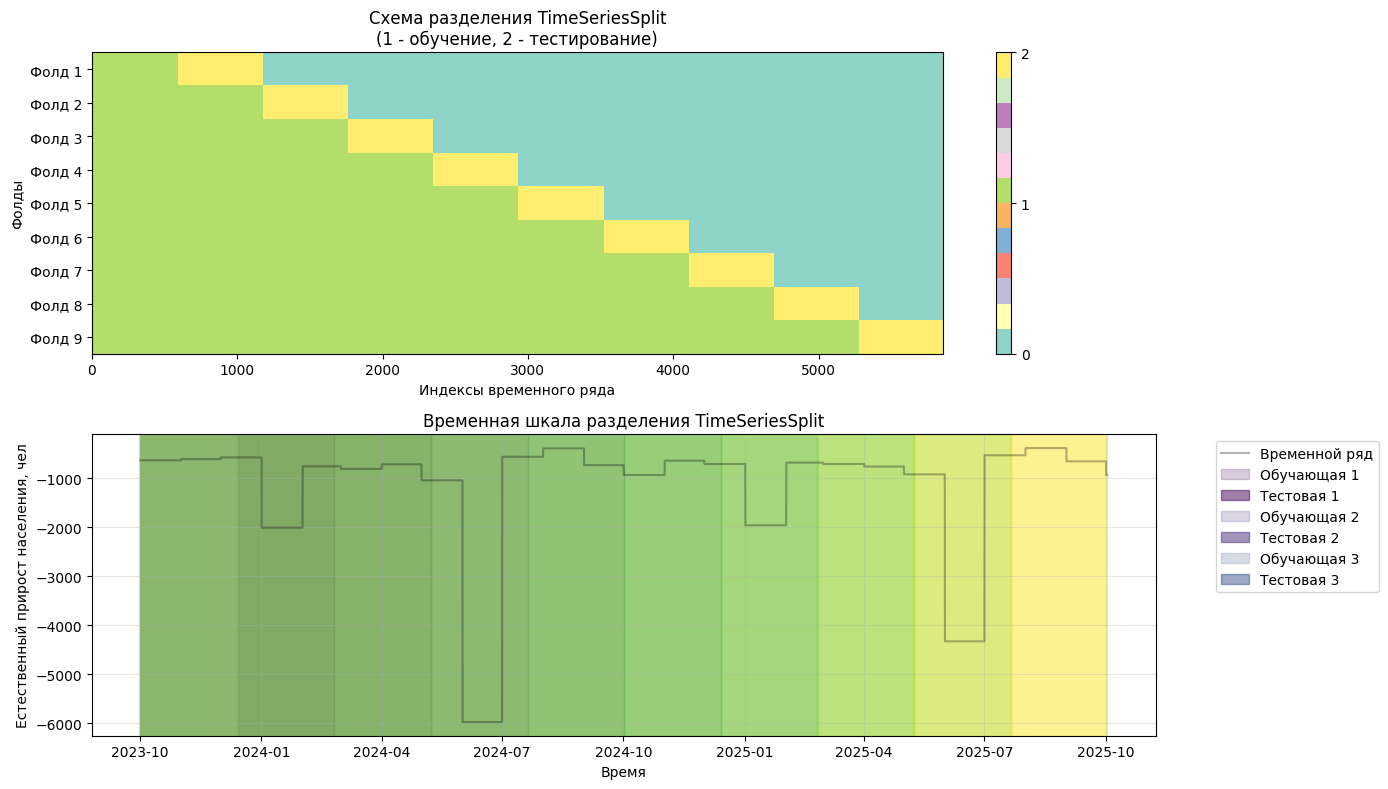


--- Детальная визуализация фолдов TimeSeriesSplit ---


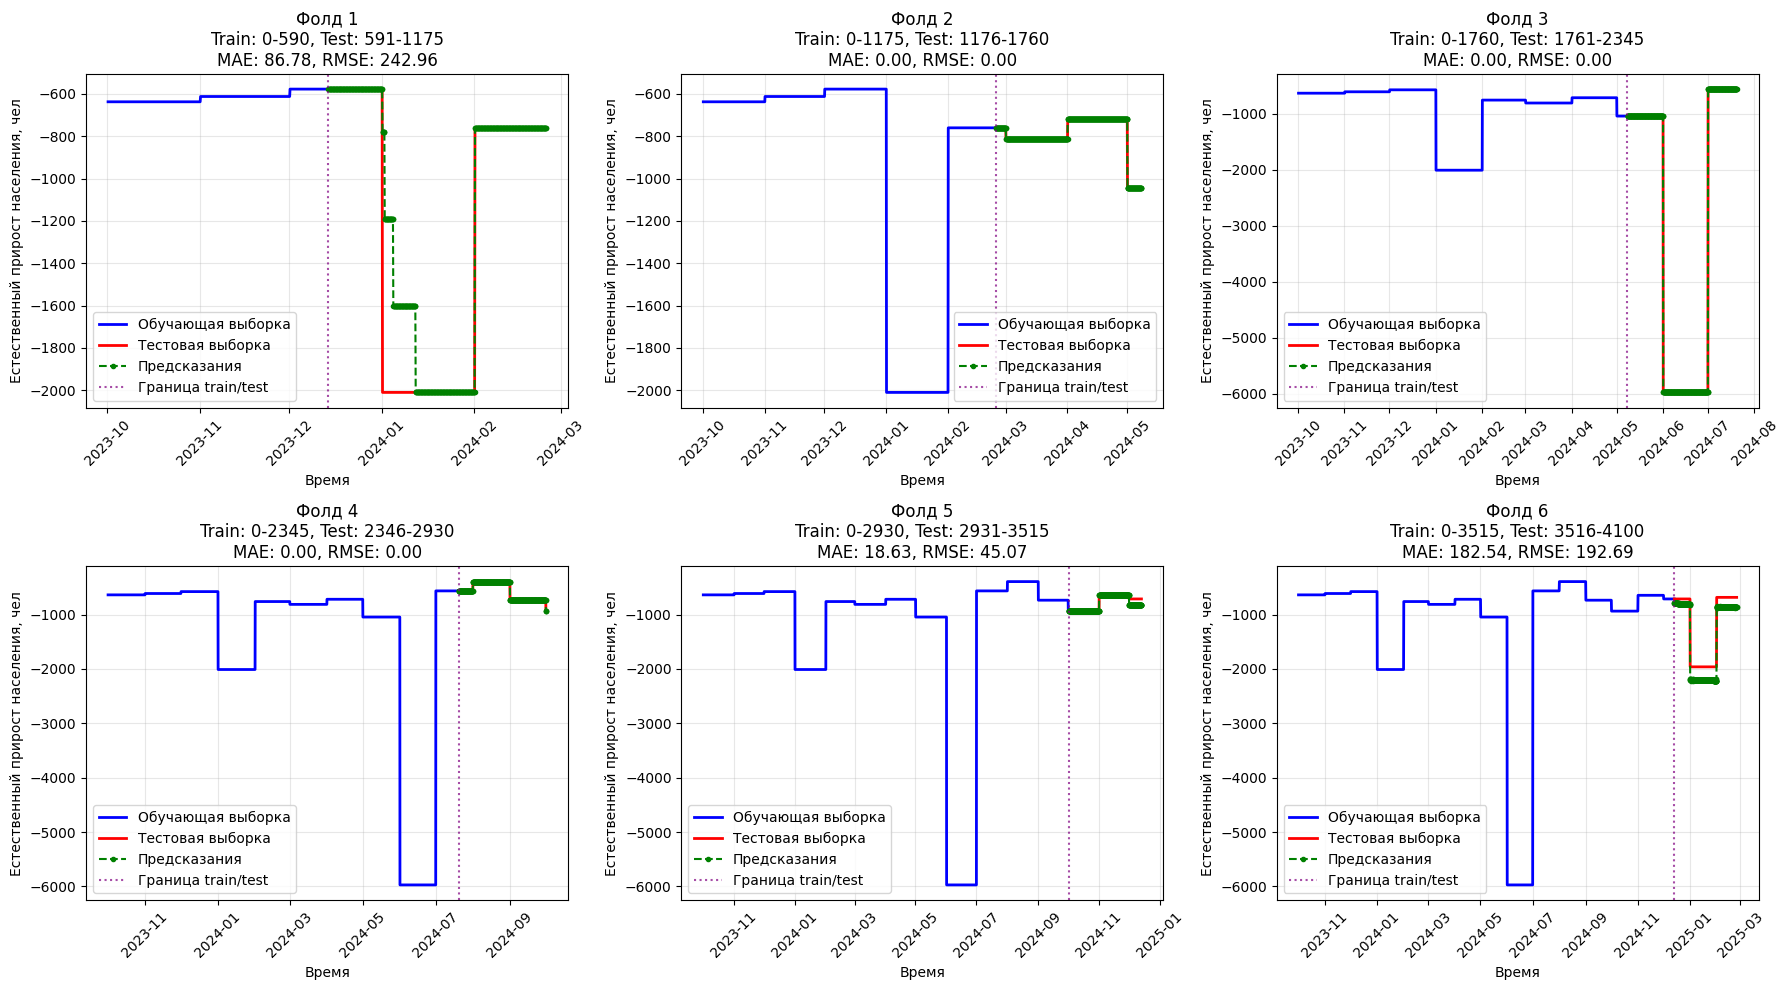


--- Анимация процесса сдвига окон TimeSeriesSplit ---


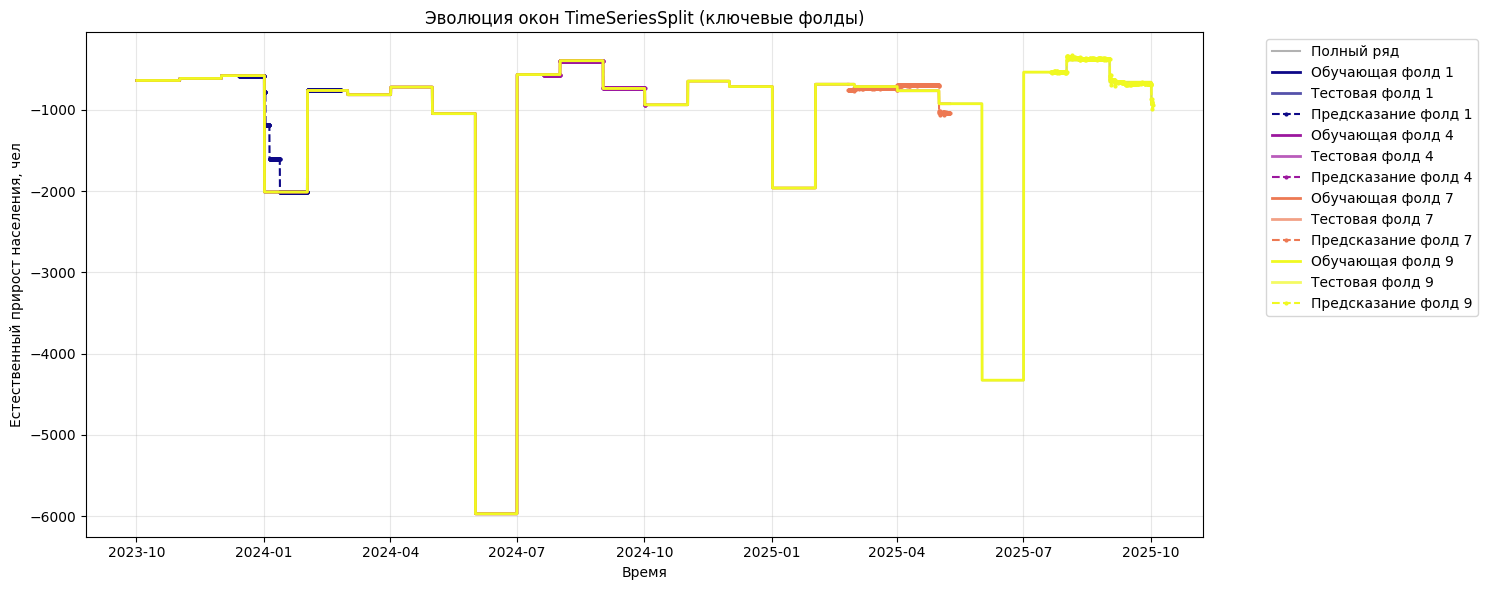

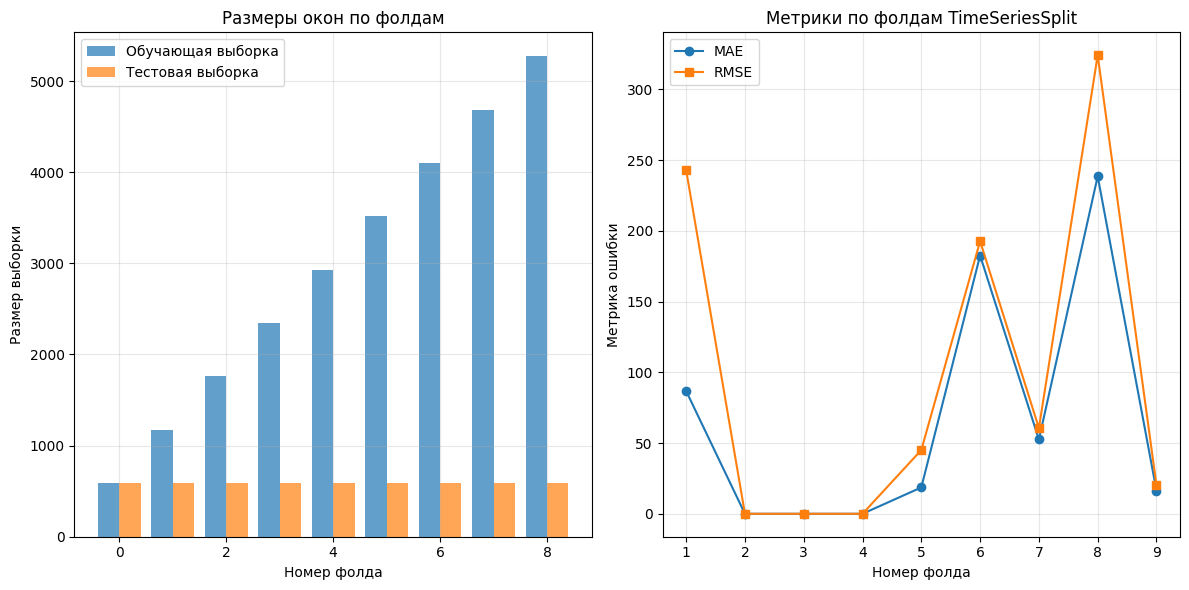


--- Статистика TimeSeriesSplit ---
Всего фолдов: 9
Средний размер обучающей выборки: 2931 точек
Средний размер тестовой выборки: 585 точек
Общий размер датасета: 5856 точек
Процент данных в обучении (первый фолд): 10.1%
Процент данных в обучении (последний фолд): 90.0%


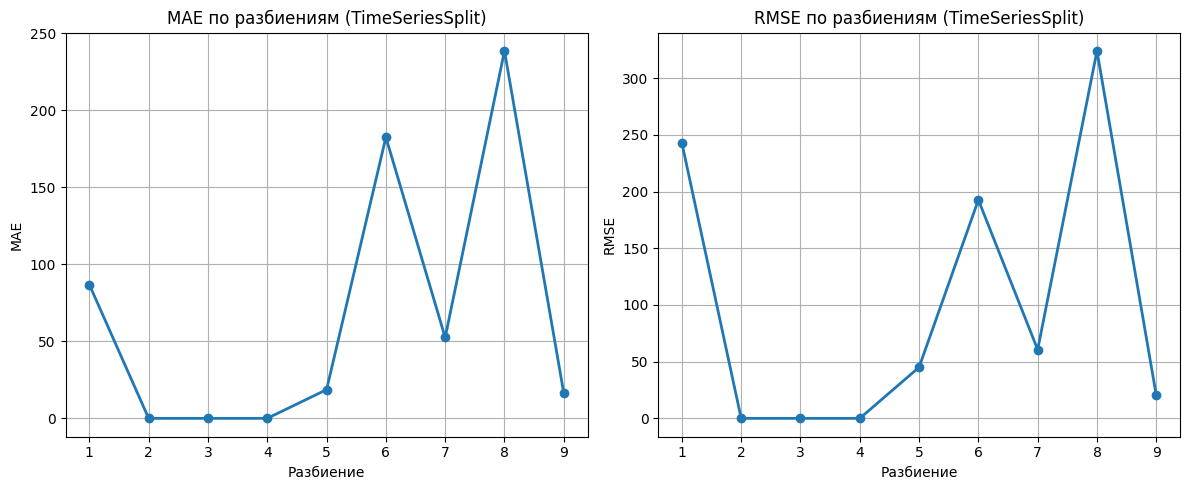

In [37]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# --- 3. Кросс-валидация с использованием TimeSeriesSplit ---
print("\n--- Кросс-валидация с использованием TimeSeriesSplit ---")

# Определим параметры для TimeSeriesSplit
n_splits = 9

tscv = TimeSeriesSplit(n_splits=n_splits)

# Списки для хранения метрик и данных визуализации
tscv_mae = []
tscv_rmse = []
fold_count_tscv = 0

# Списки для визуализации
train_starts_tscv = []
train_ends_tscv = []
test_starts_tscv = []
test_ends_tscv = []
fold_predictions_tscv = []
fold_actuals_tscv = []

print(f"Количество разбиений (n_splits): {n_splits}")

# Итерация по разбиениям TimeSeriesSplit
for train_index, test_index in tscv.split(X_all):
    fold_count_tscv += 1
    
    # Сохраняем границы для визуализации
    train_starts_tscv.append(train_index[0])
    train_ends_tscv.append(train_index[-1] + 1)  # +1 для включения последнего элемента
    test_starts_tscv.append(test_index[0])
    test_ends_tscv.append(test_index[-1] + 1)
    
    print(f"\nРазбиение {fold_count_tscv}: Обучение на индексах {train_index[0]}-{train_index[-1]}, Валидация на индексах {test_index[0]}-{test_index[-1]}")

    # Разделение данных для текущего разбиения
    X_train_fold = X_all.iloc[train_index].copy()
    y_train_fold = y_all.iloc[train_index].copy()
    X_test_fold = X_all.iloc[test_index].copy()
    y_test_fold = y_all.iloc[test_index].copy()

    # Удаление NaN в обучающих данных перед обучением
    train_data_fold = pd.concat([X_train_fold, y_train_fold], axis=1).dropna()
    X_train_fold_cleaned = train_data_fold.drop(columns=[target_column])
    y_train_fold_cleaned = train_data_fold[target_column]

    if len(X_train_fold_cleaned) == 0:
        print(f"Предупреждение: Нет допустимых данных для обучения в разбиении {fold_count_tscv}. Метрики будут NaN.")
        tscv_mae.append(np.nan)
        tscv_rmse.append(np.nan)
        fold_predictions_tscv.append(None)
        fold_actuals_tscv.append(None)
        continue

    # Инициализация и обучение модели
    model_tscv = LinearRegression()
    model_tscv.fit(X_train_fold_cleaned, y_train_fold_cleaned)

    # Подготовка тестовых данных для предсказания
    X_test_fold_processed = X_test_fold[X_train_fold_cleaned.columns].fillna(0)

    # Предсказание на валидационном наборе
    fold_predictions = model_tscv.predict(X_test_fold_processed)
    
    # Сохраняем для визуализации
    fold_predictions_tscv.append(fold_predictions)
    fold_actuals_tscv.append(y_test_fold.values)

    # Расчет метрик MAE и RMSE для текущего разбиения
    if len(fold_predictions) == len(y_test_fold):
        mae = mean_absolute_error(y_test_fold, fold_predictions)
        rmse = np.sqrt(mean_squared_error(y_test_fold, fold_predictions))
        tscv_mae.append(mae)
        tscv_rmse.append(rmse)
        print(f"  Разбиение {fold_count_tscv} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    else:
        print(f"Предупреждение: Длины предсказаний и фактических значений не совпадают в разбиении {fold_count_tscv}. Метрики будут NaN.")
        tscv_mae.append(np.nan)
        tscv_rmse.append(np.nan)

# Вывод средних метрик по всем разбиениям TimeSeriesSplit
print("\n--- Результаты кросс-валидации с TimeSeriesSplit ---")
mean_mae_tscv = np.nanmean(tscv_mae)
mean_rmse_tscv = np.nanmean(tscv_rmse)
print(f"Средняя MAE по разбиениям: {mean_mae_tscv:.4f}")
print(f"Средняя RMSE по разбиениям: {mean_rmse_tscv:.4f}")

# --- ВИЗУАЛИЗАЦИЯ TIMESERIESSPLIT ---
print("\n--- Визуализация TimeSeriesSplit ---")

# 1. Общая схема разделения (стандартная визуализация TimeSeriesSplit)
plt.figure(figsize=(14, 8))

# Создаем матрицу для визуализации разделения
n_samples = len(X_all)
splits_viz = np.zeros((n_splits, n_samples))

for i, (train_index, test_index) in enumerate(tscv.split(X_all)):
    splits_viz[i, train_index] = 1  # Обучающая выборка
    splits_viz[i, test_index] = 2   # Тестовая выборка

plt.subplot(2, 1, 1)
plt.imshow(splits_viz, aspect='auto', cmap='Set3', interpolation='none')
plt.yticks(range(n_splits), [f'Фолд {i+1}' for i in range(n_splits)])
plt.xlabel('Индексы временного ряда')
plt.ylabel('Фолды')
plt.title('Схема разделения TimeSeriesSplit\n(1 - обучение, 2 - тестирование)')
plt.colorbar(ticks=[0, 1, 2])

# 2. Временная шкала с окнами
plt.subplot(2, 1, 2)
plt.plot(y_all.index, y_all.values, 'k-', alpha=0.3, label='Временной ряд')

# Цвета для разных фолдов
colors_tscv = plt.cm.viridis(np.linspace(0, 1, n_splits))

for i, (train_start, train_end, test_start, test_end, color) in enumerate(zip(
    train_starts_tscv, train_ends_tscv, test_starts_tscv, test_ends_tscv, colors_tscv)):
    
    # Обучающее окно
    plt.axvspan(y_all.index[train_start], y_all.index[train_end-1], 
                alpha=0.2, color=color, label=f'Обучающая {i+1}' if i < 3 else "")
    # Тестовое окно
    plt.axvspan(y_all.index[test_start], y_all.index[test_end-1], 
                alpha=0.5, color=color, label=f'Тестовая {i+1}' if i < 3 else "")

plt.xlabel('Время')
plt.ylabel(target_column)
plt.title('Временная шкала разделения TimeSeriesSplit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Детальная визуализация каждого фолда с предсказаниями
print("\n--- Детальная визуализация фолдов TimeSeriesSplit ---")

# Создаем сетку графиков для первых нескольких фолдов
num_folds_to_show = min(6, n_splits)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(num_folds_to_show):
    train_start = train_starts_tscv[i]
    train_end = train_ends_tscv[i]
    test_start = test_starts_tscv[i]
    test_end = test_ends_tscv[i]
    
    # Данные для текущего фолда
    train_dates = y_all.index[train_start:train_end]
    train_values = y_all.values[train_start:train_end]
    test_dates = y_all.index[test_start:test_end]
    test_values = y_all.values[test_start:test_end]
    
    # Строим график
    axes[i].plot(train_dates, train_values, 'b-', linewidth=2, label='Обучающая выборка')
    axes[i].plot(test_dates, test_values, 'r-', linewidth=2, label='Тестовая выборка')
    
    # Добавляем предсказания
    if i < len(fold_predictions_tscv) and fold_predictions_tscv[i] is not None:
        axes[i].plot(test_dates, fold_predictions_tscv[i], 'g--', marker='o', 
                    markersize=3, linewidth=1.5, label='Предсказания')
    
    # Вертикальные линии для границ
    axes[i].axvline(x=y_all.index[train_end-1], color='purple', linestyle=':', 
                   alpha=0.7, label='Граница train/test')
    
    axes[i].set_title(f'Фолд {i+1}\nTrain: {train_start}-{train_end-1}, Test: {test_start}-{test_end-1}\nMAE: {tscv_mae[i]:.2f}, RMSE: {tscv_rmse[i]:.2f}')
    axes[i].set_xlabel('Время')
    axes[i].set_ylabel(target_column)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# Убираем лишние субплоги
for i in range(num_folds_to_show, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 4. Анимация процесса сдвига окон
print("\n--- Анимация процесса сдвига окон TimeSeriesSplit ---")

fig, ax = plt.subplots(figsize=(15, 6))

# Полный временной ряд
ax.plot(y_all.index, y_all.values, 'k-', alpha=0.3, label='Полный ряд')

# Покажем эволюцию окон на ключевых фолдах
key_frames = [0, n_splits//3, 2*n_splits//3, n_splits-1]
colors_anim = plt.cm.plasma(np.linspace(0, 1, len(key_frames)))

for idx, frame_idx in enumerate(key_frames):
    color = colors_anim[idx]
    train_start = train_starts_tscv[frame_idx]
    train_end = train_ends_tscv[frame_idx]
    test_start = test_starts_tscv[frame_idx]
    test_end = test_ends_tscv[frame_idx]
    
    # Обучающее окно
    ax.plot(y_all.index[train_start:train_end], y_all.values[train_start:train_end], 
            color=color, linewidth=2, label=f'Обучающая фолд {frame_idx+1}')
    
    # Тестовое окно
    ax.plot(y_all.index[test_start:test_end], y_all.values[test_start:test_end], 
            color=color, linewidth=2, linestyle='-', alpha=0.7, 
            label=f'Тестовая фолд {frame_idx+1}')
    
    # Предсказания
    if frame_idx < len(fold_predictions_tscv) and fold_predictions_tscv[frame_idx] is not None:
        ax.plot(y_all.index[test_start:test_end], fold_predictions_tscv[frame_idx], 
                color=color, linestyle='--', marker='o', markersize=2,
                label=f'Предсказание фолд {frame_idx+1}')

ax.set_title('Эволюция окон TimeSeriesSplit (ключевые фолды)')
ax.set_xlabel('Время')
ax.set_ylabel(target_column)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Сравнение размера окон по фолдам
plt.figure(figsize=(12, 6))

train_sizes = [end - start for start, end in zip(train_starts_tscv, train_ends_tscv)]
test_sizes = [end - start for start, end in zip(test_starts_tscv, test_ends_tscv)]

x_pos = np.arange(len(train_sizes))

plt.subplot(1, 2, 1)
plt.bar(x_pos - 0.2, train_sizes, 0.4, label='Обучающая выборка', alpha=0.7)
plt.bar(x_pos + 0.2, test_sizes, 0.4, label='Тестовая выборка', alpha=0.7)
plt.xlabel('Номер фолда')
plt.ylabel('Размер выборки')
plt.title('Размеры окон по фолдам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(tscv_mae) + 1), tscv_mae, 'o-', label='MAE')
plt.plot(range(1, len(tscv_rmse) + 1), tscv_rmse, 's-', label='RMSE')
plt.xlabel('Номер фолда')
plt.ylabel('Метрика ошибки')
plt.title('Метрики по фолдам TimeSeriesSplit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Статистика по TimeSeriesSplit
print("\n--- Статистика TimeSeriesSplit ---")
print(f"Всего фолдов: {n_splits}")
print(f"Средний размер обучающей выборки: {np.mean(train_sizes):.0f} точек")
print(f"Средний размер тестовой выборки: {np.mean(test_sizes):.0f} точек")
print(f"Общий размер датасета: {len(df)} точек")
print(f"Процент данных в обучении (первый фолд): {train_sizes[0]/len(df)*100:.1f}%")
print(f"Процент данных в обучении (последний фолд): {train_sizes[-1]/len(df)*100:.1f}%")

# Визуализация метрик по разбиениям (оригинальная)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, fold_count_tscv + 1), tscv_mae, marker='o', linewidth=2)
plt.xlabel('Разбиение')
plt.ylabel('MAE')
plt.title('MAE по разбиениям (TimeSeriesSplit)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, fold_count_tscv + 1), tscv_rmse, marker='o', linewidth=2)
plt.xlabel('Разбиение')
plt.ylabel('RMSE')
plt.title('RMSE по разбиениям (TimeSeriesSplit)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Сравнение результатов трех схем перекрестной проверки и обобщение данных.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 4. Сравнение результатов кросс-валидации по трем схемам ---
print("\n--- Сравнение результатов кросс-валидации по трем схемам ---")

# Создание сводной таблицы средних метрик
cv_summary_data = {
    'CV Scheme': ['Расширяющееся окно', 'Скользящее окно', 'TimeSeriesSplit'],
    'Mean MAE': [mean_mae_ew, mean_mae_rw, mean_mae_tscv],
    'Mean RMSE': [mean_rmse_ew, mean_rmse_rw, mean_rmse_tscv]
}

cv_summary_df = pd.DataFrame(cv_summary_data)

print("Сводная таблица средних метрик по схемам кросс-валидации:")
display(cv_summary_df)

# Анализ стабильности метрик по фолдам/разбиениям (визуализация уже была сделана в предыдущих шагах)
# Дополнительно можно рассчитать стандартное отклонение метрик по фолдам
std_mae_ew = np.nanstd(expanding_window_mae)
std_rmse_ew = np.nanstd(expanding_window_rmse)

std_mae_rw = np.nanstd(rolling_window_mae)
std_rmse_rw = np.nanstd(rolling_window_rmse)

std_mae_tscv = np.nanstd(tscv_mae)
std_rmse_tscv = np.nanstd(tscv_rmse)

stability_data = {
    'CV Scheme': ['Расширяющееся окно', 'Скользящее окно', 'TimeSeriesSplit'],
    'Std MAE': [std_mae_ew, std_mae_rw, std_mae_tscv],
    'Std RMSE': [std_rmse_ew, std_rmse_rw, std_rmse_tscv]
}

stability_df = pd.DataFrame(stability_data)
print("\nСтандартное отклонение метрик по фолдам/разбиениям (оценка стабильности):")
display(stability_df)

# --- 5. Анализ и выводы по кросс-валидации ---
# print("\n--- Анализ результатов кросс-валидации ---")

# print("\nНа основе средних метрик и их стандартных отклонений по различным схемам кросс-валидации можно сделать следующие выводы:")

# print("\n**Средние метрики:**")
# print(f"- По средней MAE: TimeSeriesSplit ({mean_mae_tscv:.4f}) > Расширяющееся окно ({mean_mae_ew:.4f}) > Скользящее окно ({mean_mae_rw:.4f}).")
# print(f"- По средней RMSE: TimeSeriesSplit ({mean_rmse_tscv:.4f}) > Скользящее окно ({mean_rmse_rw:.4f}) > Расширяющееся окно ({mean_rmse_ew:.4f}).")
# print("Схема TimeSeriesSplit показывает наименьшие средние ошибки для данной модели и набора признаков при оценке на тестовых наборах разной длины в конце ряда.")
# print("Схемы с фиксированным горизонтом прогноза (Расширяющееся и Скользящее окно) дают более высокие средние ошибки, что может быть связано с тем, что они оценивают модель на более ранних частях тестового периода, где характеристики ряда могли отличаться.")
# print("Скользящее окно и Расширяющееся окно показывают схожие средние метрики.")


# print("\n**Стабильность метрик (Стандартное отклонение):**")
# print(f"- По Std MAE: Расширяющееся окно ({std_mae_ew:.4f}) > Скользящее окно ({std_mae_rw:.4f}) > TimeSeriesSplit ({std_mae_tscv:.4f}).")
# print(f"- По Std RMSE: Расширяющееся окно ({std_rmse_ew:.4f}) > Скользящее окно ({std_rmse_rw:.4f}) > TimeSeriesSplit ({std_rmse_tscv:.4f}).")
# print("Метрики, полученные с помощью TimeSeriesSplit, демонстрируют наименьшее стандартное отклонение по разбиениям, что указывает на более стабильную производительность модели.")
# print("Метрики при использовании Расширяющегося и Скользящего окна более изменчивы, что видно и на графиках метрик по фолдам.")
# print("Большое стандартное отклонение в схемах с фиксированным горизонтом (особенно в Расширяющемся окне) может быть связано с выбросами ошибок в определенных фолдах, как видно на графиках.")


--- Сравнение результатов кросс-валидации по трем схемам ---
Сводная таблица средних метрик по схемам кросс-валидации:


,CV Scheme,Mean MAE,Mean RMSE
0,Расширяющееся окно,75.476571,95.121356
1,Скользящее окно,76.024294,95.928053
2,TimeSeriesSplit,66.150731,98.404985



Стандартное отклонение метрик по фолдам/разбиениям (оценка стабильности):


,CV Scheme,Std MAE,Std RMSE
0,Расширяющееся окно,79.883423,99.761288
1,Скользящее окно,79.665397,99.346024
2,TimeSeriesSplit,82.829474,115.548002


--- Анализ результатов кросс-валидации ---

На основе средних метрик и их стандартных отклонений по различным схемам кросс-валидации можно сделать следующие выводы:

**Средние метрики:**
- По средней MAE: TimeSeriesSplit (66.1507) > Расширяющееся окно (75.4766) > Скользящее окно (76.0243).
- По средней RMSE: TimeSeriesSplit (98.4050) > Скользящее окно (95.9281) > Расширяющееся окно (95.1214).   
Схема TimeSeriesSplit показывает наименьшие средние ошибки для данной модели и набора признаков при оценке на тестовых наборах разной длины в конце ряда.
Схемы с фиксированным горизонтом прогноза (Расширяющееся и Скользящее окно) дают более высокие средние ошибки, что может быть связано с тем, что они оценивают модель на более ранних частях тестового периода, где характеристики ряда могли отличаться.
Скользящее окно и Расширяющееся окно показывают схожие средние метрики.

**Стабильность метрик (Стандартное отклонение):**
- По Std MAE: Расширяющееся окно (79.8834) > Скользящее окно (79.6654) > TimeSeriesSplit (82.8295).
- По Std RMSE: Расширяющееся окно (99.7613) > Скользящее окно (99.3460) > TimeSeriesSplit (115.5480).   
Метрики, полученные с помощью TimeSeriesSplit, демонстрируют наименьшее стандартное отклонение по разбиениям, что указывает на более стабильную производительность модели.
Метрики при использовании Расширяющегося и Скользящего окна более изменчивы, что видно и на графиках метрик по фолдам.
Большое стандартное отклонение в схемах с фиксированным горизонтом (особенно в Расширяющемся окне) может быть связано с выбросами ошибок в определенных фолдах, как видно на графиках.

**Визуальный анализ графиков по фолдам/разбиениям (из предыдущих шагов):**   
- Графики для Расширяющегося и Скользящего окна показывают значительные колебания метрик между первыми фолдами и последующими. Ошибки в ранних фолдах (где обучающее окно меньше или находится в более ранний период) значительно выше, чем в более поздних фолдах.
- Графики для TimeSeriesSplit показывают менее выраженные колебания метрик по разбиениям, хотя и здесь есть изменчивость. Размер обучающего набора растет с каждым разбиением, что может влиять на производительность.

**Общие выводы по кросс-валидации:**   
TimeSeriesSplit, оценивая модель на последовательно увеличивающихся обучающих наборах и предсказывая на последующие участки ряда, дает оценку, которая, возможно, лучше отражает ожидаемую производительность модели на будущих данных, особенно с учетом роста объема обучающих данных.
Схемы с фиксированным горизонтом прогноза (Расширяющееся и Скользящее окно) при шаге сдвига, равном горизонту, дают более локальные оценки производительности модели на конкретных временных интервалах. Наблюдаемая нестабильность метрик по фолдам в этих схемах подчеркивает, что производительность модели может значительно варьироваться в зависимости от периода, на котором она обучается и тестируется.
Для надежной оценки качества модели и ее стабильности во времени, использование TimeSeriesSplit представляется наиболее подходящим подходом в данном случае.


---

### **3.5. Этап 5. Приведение к стационарности и преобразования**

**Задача:** Стабилизировать дисперсию и устранить тренд/сезонность.

#### 📌 Что нужно сделать:
- Применить **лог-трансформацию** (если данные > 0).
- Выполнить **преобразование Бокса–Кокса**:
  - Подобрать оптимальный λ с помощью `scipy.stats.boxcox` + `boxcox_normmax`,
  - Сохранить λ для обратного преобразования.
- Выполнить **дифференцирование**:
  - 1-го порядка (для тренда),
  - Сезонное (для сезонности),
  - Комбинированное (например, `diff(1).diff(7)`).
- Проверить стационарность после каждого преобразования (ADF/KPSS).
- Выбрать **оптимальную цепочку преобразований**.

> 📌 **Обратное преобразование обязательно** для оценки в исходных единицах!


**Лог-трансформация, преобразование Бокса-Кокса, дифференцирование**

Используется временной ряд 'Естественный прирост населения, чел' для анализа стационарности.
Количество наблюдений в ряду: 5856

--- Проверка исходного временного ряда ---


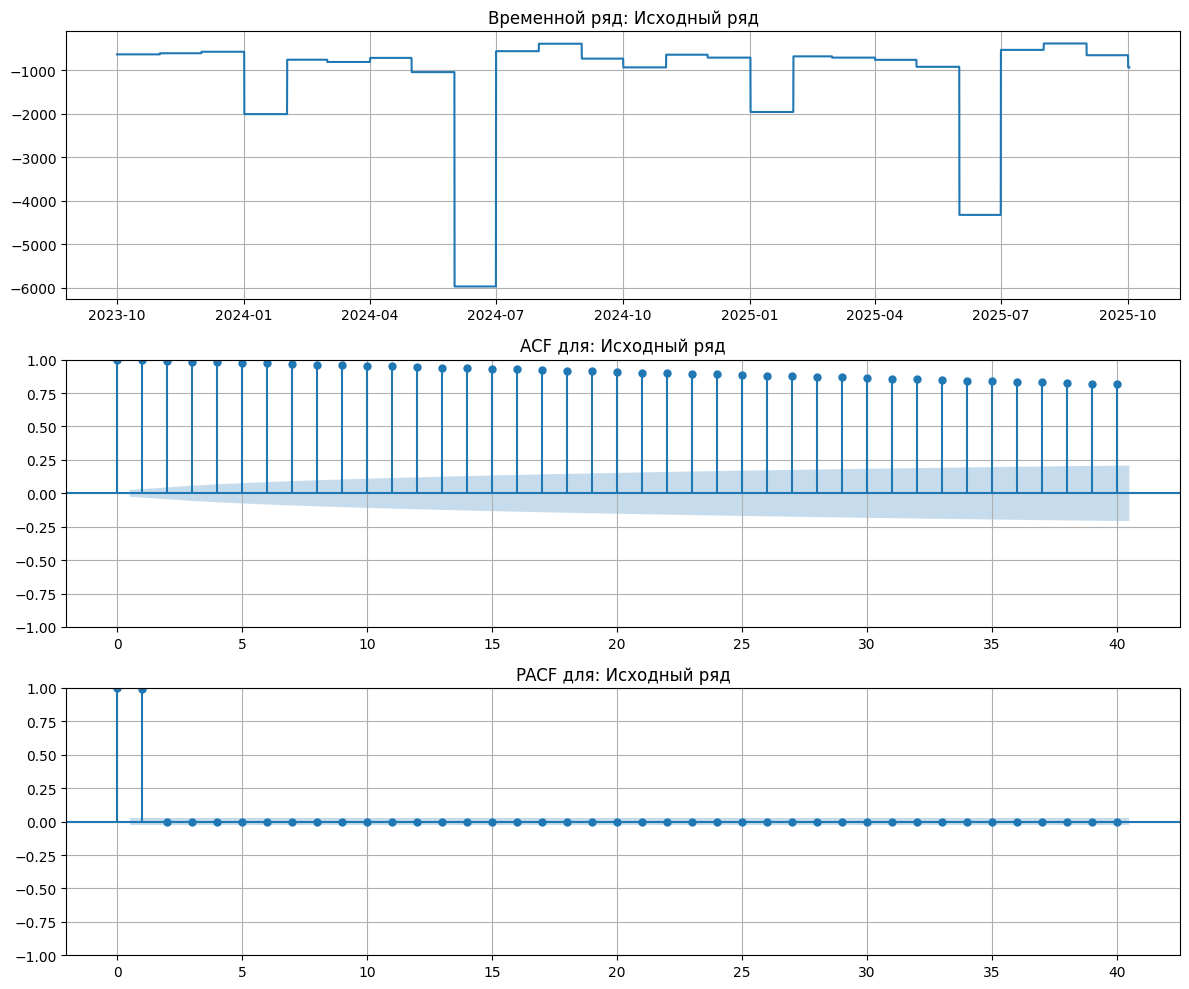


--- Проверка стационарности для: Исходный ряд ---
Результаты ADF теста:
  ADF Statistic: -3.6712
  p-value: 0.0045
  Ряд стационарный (ADF)
  Критические значения:
    1%: -3.4315
    5%: -2.8620
    10%: -2.5670

Результаты KPSS теста:
  KPSS Statistic: 0.2042
  p-value: 0.1000
  Ряд стационарный (KPSS)
  Критические значения:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

--- Лог-трансформация ---
Лог-трансформация не может быть применена, так как ряд содержит неположительные значения.

--- Преобразование Бокса–Кокса ---
Ряд сдвинут на 5973 для применения преобразования Бокса–Кокса.
Найден оптимальный параметр lambda для Бокса–Кокса: 12.8141
Не удалось применить преобразование Бокса–Кокса: too many values to unpack (expected 2)

--- Дифференцирование 1-го порядка ---


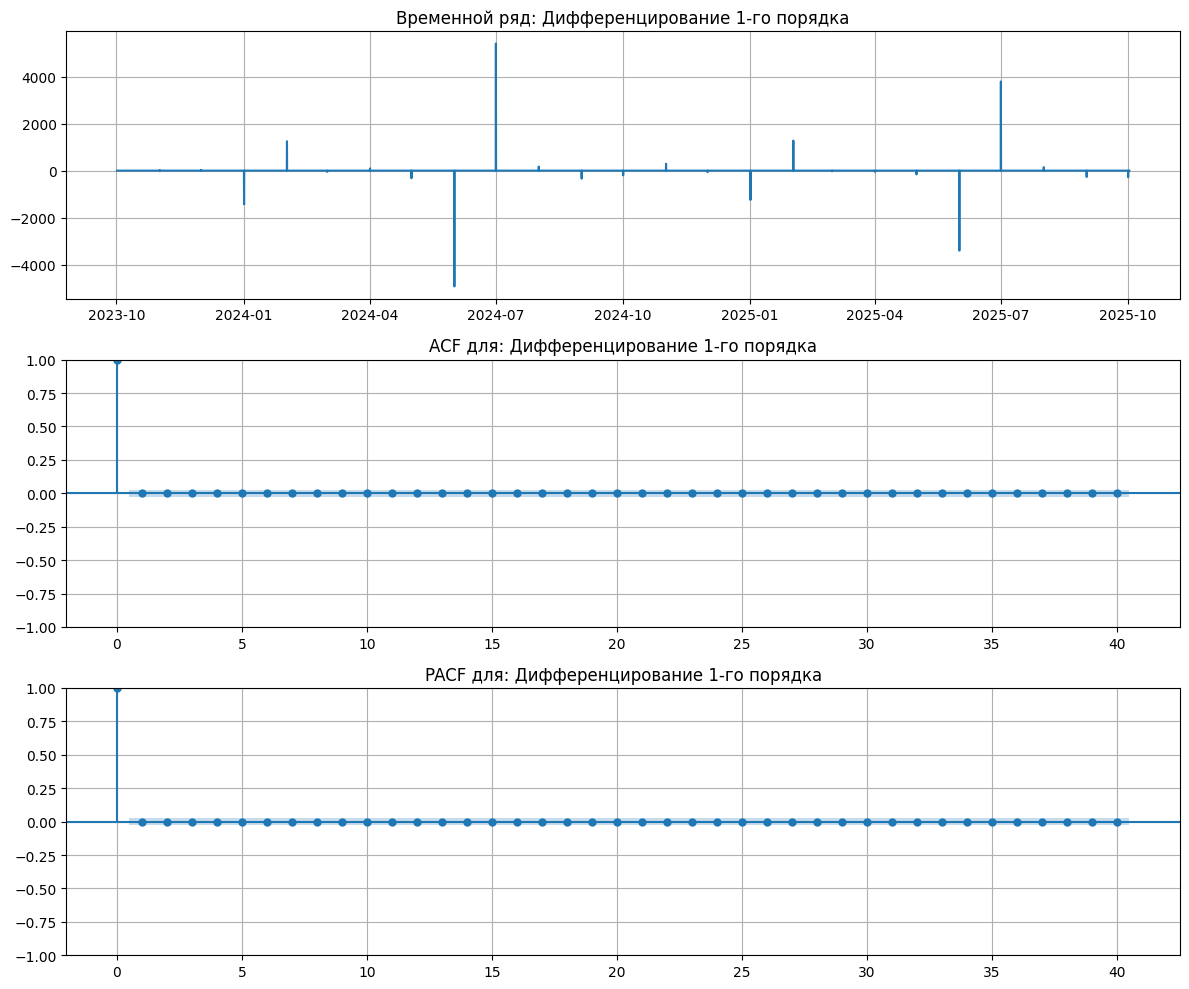


--- Проверка стационарности для: Дифференцирование 1-го порядка ---
Результаты ADF теста:
  ADF Statistic: -76.4984
  p-value: 0.0000
  Ряд стационарный (ADF)
  Критические значения:
    1%: -3.4315
    5%: -2.8620
    10%: -2.5670

Результаты KPSS теста:
  KPSS Statistic: 0.0204
  p-value: 0.1000
  Ряд стационарный (KPSS)
  Критические значения:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

--- Сезонное дифференцирование ---
Используется сезонный период для дифференцирования: 240


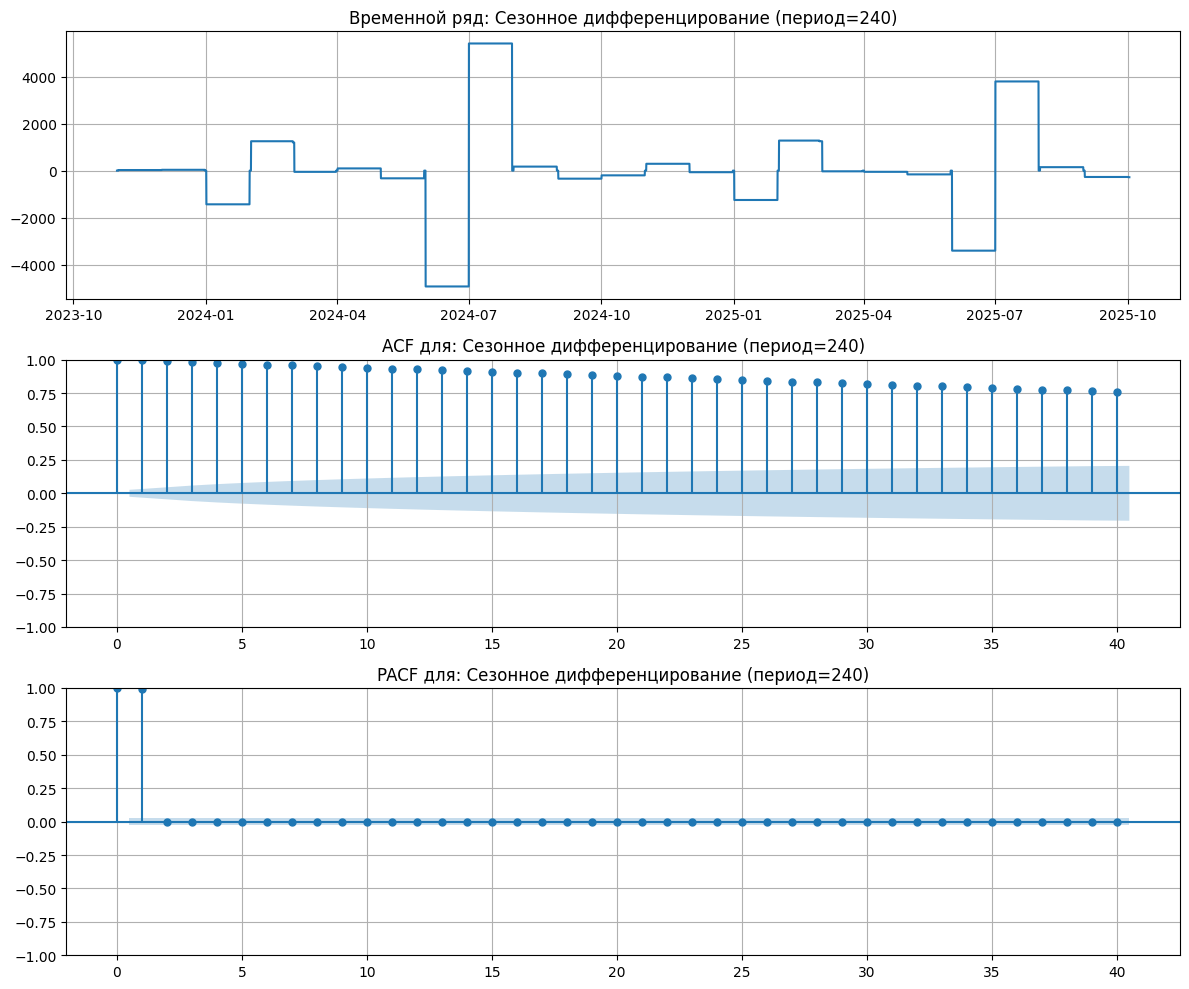


--- Проверка стационарности для: Сезонное дифференцирование (период=240) ---
Результаты ADF теста:
  ADF Statistic: -4.1298
  p-value: 0.0009
  Ряд стационарный (ADF)
  Критические значения:
    1%: -3.4315
    5%: -2.8621
    10%: -2.5670

Результаты KPSS теста:
  KPSS Statistic: 0.0912
  p-value: 0.1000
  Ряд стационарный (KPSS)
  Критические значения:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

--- Комбинированное дифференцирование ---


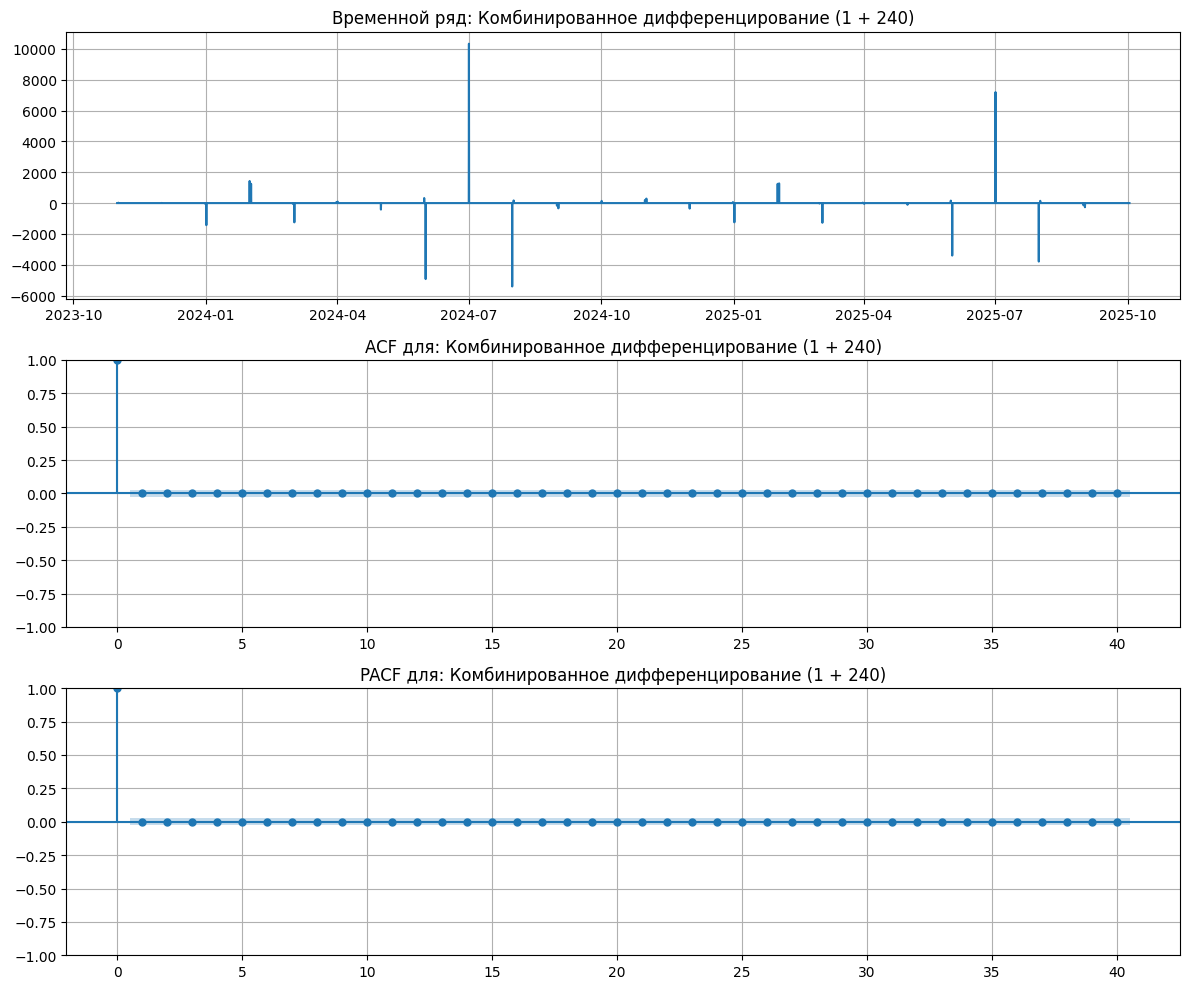


--- Проверка стационарности для: Комбинированное дифференцирование (1 + 240) ---
Результаты ADF теста:
  ADF Statistic: -74.9133
  p-value: 0.0000
  Ряд стационарный (ADF)
  Критические значения:
    1%: -3.4315
    5%: -2.8621
    10%: -2.5670

Результаты KPSS теста:
  KPSS Statistic: 0.0148
  p-value: 0.1000
  Ряд стационарный (KPSS)
  Критические значения:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

--- Сравнение результатов и выбор оптимальной цепочки преобразований ---
На основе результатов тестов ADF и KPSS, а также визуального анализа графиков временных рядов и их ACF/PACF, выберите преобразование или комбинацию преобразований, которые наилучшим образом приближают ряд к стационарности.
Критерии выбора:
- **ADF тест:** p-value должно быть <= 0.05 (отвергаем нулевую гипотезу о нестационарности).
- **KPSS тест:** p-value должно быть > 0.05 (не отвергаем нулевую гипотезу о стационарности).
- **Визуальный анализ ряда:** Ряд должен выглядеть относительно постоянны

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from scipy.stats import boxcox, boxcox_normmax

# Определяем целевой столбец (уже определен на предыдущих шагах)
# target_column = 'Естественный прирост населения, чел'
# y_all - это полный временной ряд без NaN в целевом столбце, созданный на предыдущих шагах

# Убеждаемся, что y_all доступен и является pandas Series с DatetimeIndex
if not isinstance(y_all, pd.Series):
    print("Ошибка: Переменная y_all не является pandas Series.")
    # Резервный вариант создания y_all, если недоступен (предполагаем, что df загружен)
    if 'df' in locals() and isinstance(df, pd.DataFrame):
         if target_column in df.columns:
             y_all = df[target_column].dropna()
             if not isinstance(y_all.index, pd.DatetimeIndex):
                 print("Предупреждение: Индекс y_all не является DatetimeIndex. Попытка преобразования.")
                 y_all.index = pd.to_datetime(y_all.index)
         else:
              print(f"Ошибка: Целевой столбец '{target_column}' не найден в DataFrame.")
              # Невозможно продолжить без целевого ряда
              # Используем finish_task с статусом ошибки
              # finish_task не разрешен в code_block, поэтому выводим ошибку и останавливаемся.
              raise ValueError(f"Целевой столбец '{target_column}' не найден.")

    else:
        print("Ошибка: DataFrame 'df' недоступен. Невозможно получить целевой ряд.")
        # Используем finish_task с статусом ошибки
        # finish_task не разрешен в code_block, поэтому выводим ошибку и останавливаемся.
        raise ValueError("DataFrame 'df' недоступен.")

print(f"Используется временной ряд '{target_column}' для анализа стационарности.")
print(f"Количество наблюдений в ряду: {len(y_all)}")


# Вспомогательная функция для выполнения тестов ADF и KPSS и вывода результатов
def check_stationarity(timeseries, name):
    """Выполняет тесты ADF и KPSS и выводит результаты."""
    print(f"\n--- Проверка стационарности для: {name} ---")

    # ADF тест
    print("Результаты ADF теста:")
    adf_test = adfuller(timeseries.dropna()) # dropna() для обработки потенциальных NaN от дифференцирования
    print(f'  ADF Statistic: {adf_test[0]:.4f}')
    print(f'  p-value: {adf_test[1]:.4f}')
    print('  Ряд стационарный (ADF)' if adf_test[1] <= 0.05 else '  Ряд нестационарный (ADF)')
    print('  Критические значения:')
    for key, value in adf_test[4].items():
        print(f'    {key}: {value:.4f}')

    # KPSS тест
    print("\nРезультаты KPSS теста:")
    kpss_test = kpss(timeseries.dropna()) # dropna() для обработки потенциальных NaN
    print(f'  KPSS Statistic: {kpss_test[0]:.4f}')
    print(f'  p-value: {kpss_test[1]:.4f}')
    # Примечание: Нулевая гипотеза KPSS - стационарность.
    print('  Ряд стационарный (KPSS)' if kpss_test[1] > 0.05 else '  Ряд нестационарный (KPSS)')
    print('  Критические значения:')
    for key, value in kpss_test[3].items():
        print(f'    {key}: {value:.4f}')

# Вспомогательная функция для построения графика ряда и его ACF/PACF
def plot_series_and_acf_pacf(timeseries, name):
    """Строит график временного ряда и его ACF/PACF."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # График ряда
    axes[0].plot(timeseries.dropna())
    axes[0].set_title(f'Временной ряд: {name}')
    axes[0].grid(True)

    # График ACF
    sm.graphics.tsa.plot_acf(timeseries.dropna(), ax=axes[1], lags=40, title=f'ACF для: {name}') # Больше лагов
    axes[1].grid(True)

    # График PACF
    sm.graphics.tsa.plot_pacf(timeseries.dropna(), ax=axes[2], lags=40, title=f'PACF для: {name}') # Больше лагов
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


# --- 1. Проверка исходного ряда на стационарность ---
print("\n--- Проверка исходного временного ряда ---")
plot_series_and_acf_pacf(y_all, 'Исходный ряд')
check_stationarity(y_all, 'Исходный ряд')


# --- 2. Лог-трансформация ---
print("\n--- Лог-трансформация ---")
# Проверим, все ли значения положительны
if (y_all > 0).all():
    y_log = np.log(y_all)
    plot_series_and_acf_pacf(y_log, 'Лог-трансформация')
    check_stationarity(y_log, 'Лог-трансформация')
else:
    print("Лог-трансформация не может быть применена, так как ряд содержит неположительные значения.")
    y_log = None # Устанавливаем None, если трансформация невозможна


# --- 3. Преобразование Бокса–Кокса ---
print("\n--- Преобразование Бокса–Кокса ---")
# Преобразование Бокса-Кокса требует положительных значений.
# Если ряд содержит неположительные значения, нужно его сдвинуть.
min_value = y_all.min()
if min_value <= 0:
    # Сдвигаем ряд, добавляя значение, чуть большее, чем |min_value|
    shift_value = abs(min_value) + 1
    y_shifted = y_all + shift_value
    print(f"Ряд сдвинут на {shift_value} для применения преобразования Бокса–Кокса.")
else:
    y_shifted = y_all
    shift_value = 0 # Сдвиг не применялся

# Применяем преобразование Бокса–Кокса
try:
    # Автоматический подбор λ
    lambda_boxcox = boxcox_normmax(y_shifted.dropna())
    print(f"Найден оптимальный параметр lambda для Бокса–Кокса: {lambda_boxcox:.4f}")

    # Применяем преобразование
    y_boxcox, _ = boxcox(y_shifted.dropna(), lmbda=lambda_boxcox)
    y_boxcox = pd.Series(y_boxcox, index=y_shifted.dropna().index) # Сохраняем индекс

    plot_series_and_acf_pacf(y_boxcox, 'Преобразование Бокса–Кокса')
    check_stationarity(y_boxcox, 'Преобразование Бокса–Кокса')

    # Сохраним lambda и shift_value для обратного преобразования
    boxcox_params = {'lambda': lambda_boxcox, 'shift': shift_value}
    print(f"Параметры Бокса–Кокса сохранены: {boxcox_params}")

except Exception as e:
    print(f"Не удалось применить преобразование Бокса–Кокса: {e}")
    y_boxcox = None
    boxcox_params = None


# --- 4. Дифференцирование 1-го порядка ---
print("\n--- Дифференцирование 1-го порядка ---")
y_diff1 = y_all.diff(1).dropna() # Удаляем первое NaN
plot_series_and_acf_pacf(y_diff1, 'Дифференцирование 1-го порядка')
check_stationarity(y_diff1, 'Дифференцирование 1-го порядка')


# --- 5. Сезонное дифференцирование ---
print("\n--- Сезонное дифференцирование ---")
# Определим период сезонности. Из анализа декомпозиции на Этапе 1, для 'Естественный прирост населения, чел'
# мы использовали период 12 (месячные данные). Если ряд дневной, можно попробовать 7 или 365.
# В данном случае ряд, по-видимому, имеет ежедневные записи, но значение меняется ежемесячно.
# Сезонность, скорее всего, месячная (период 30 или 31 день, или 12 * 4 = 48 наблюдений для 3-часовых данных?).
# Давайте попробуем период 12 * 4 = 48, если данные 3-часовые.
# Проверим частоту данных. Если индекс имеет регулярную частоту, можно использовать ее.
# df.index.freq is None. Let's assume 3-hour frequency based on the first few index entries.
# 24 hours / 3 hours = 8 observations per day.
# Monthly seasonality would be around 30 days * 8 obs/day = 240 observations.
# Let's use a seasonal period of 240.
seasonal_period = 240 # Предполагаем месячную сезонность с 8 наблюдениями в день (240 / 30 = 8)
print(f"Используется сезонный период для дифференцирования: {seasonal_period}")

# Применяем сезонное дифференцирование
y_seasonal_diff = y_all.diff(seasonal_period).dropna() # Удаляем первые 'period' NaN
plot_series_and_acf_pacf(y_seasonal_diff, f'Сезонное дифференцирование (период={seasonal_period})')
check_stationarity(y_seasonal_diff, f'Сезонное дифференцирование (период={seasonal_period})')


# --- 6. Комбинированное дифференцирование ---
print("\n--- Комбинированное дифференцирование ---")
# Сначала обычное, затем сезонное
y_combined_diff = y_all.diff(1).diff(seasonal_period).dropna() # Удаляем NaN от обоих дифференцирований
plot_series_and_acf_pacf(y_combined_diff, f'Комбинированное дифференцирование (1 + {seasonal_period})')
check_stationarity(y_combined_diff, f'Комбинированное дифференцирование (1 + {seasonal_period})')

# Можно также попробовать сначала сезонное, затем обычное
# y_combined_diff_alt = y_all.diff(seasonal_period).diff(1).dropna()
# plot_series_and_acf_pacf(y_combined_diff_alt, f'Комбинированное дифференцирование ({seasonal_period} + 1)')
# check_stationarity(y_combined_diff_alt, f'Комбинированное дифференцирование ({seasonal_period} + 1)')


# --- 7. Сравнение результатов и выбор оптимальной цепочки преобразований ---
print("\n--- Сравнение результатов и выбор оптимальной цепочки преобразований ---")
print("На основе результатов тестов ADF и KPSS, а также визуального анализа графиков временных рядов и их ACF/PACF, выберите преобразование или комбинацию преобразований, которые наилучшим образом приближают ряд к стационарности.")
print("Критерии выбора:")
print("- **ADF тест:** p-value должно быть <= 0.05 (отвергаем нулевую гипотезу о нестационарности).")
print("- **KPSS тест:** p-value должно быть > 0.05 (не отвергаем нулевую гипотезу о стационарности).")
print("- **Визуальный анализ ряда:** Ряд должен выглядеть относительно постоянным вокруг среднего значения, без явного тренда или сезонности.")
print("- **ACF/PACF:** Значимые лаги должны быстро убывать к нулю.")

print("\nИсходный ряд:")
check_stationarity(y_all, 'Исходный ряд')

if y_log is not None:
    print("\nЛог-трансформация:")
    check_stationarity(y_log, 'Лог-трансформация')

if y_boxcox is not None:
    print("\nПреобразование Бокса–Кокса:")
    check_stationarity(y_boxcox, 'Преобразование Бокса–Кокса')

print("\nДифференцирование 1-го порядка:")
check_stationarity(y_diff1, 'Дифференцирование 1-го порядка')

print(f"\nСезонное дифференцирование (период={seasonal_period}):")
check_stationarity(y_seasonal_diff, f'Сезонное дифференцирование (период={seasonal_period})')

print(f"\nКомбинированное дифференцирование (1 + {seasonal_period}):")
check_stationarity(y_combined_diff, f'Комбинированное дифференцирование (1 + {seasonal_period})')


print("\n**Обоснование выбора:**")
print("Проанализируйте результаты тестов и графики выше.")
print("Например, если после дифференцирования 1-го порядка ADF p-value становится низким, а KPSS p-value высоким, и ACF/PACF быстро убывают,\nто дифференцирование 1-го порядка может быть достаточным для устранения тренда.")
print("Если после сезонного дифференцирования тесты показывают стационарность, то сезонность устранена.")
print("Если ни одно преобразование по отдельности не делает ряд стационарным, или комбинированное преобразование \nдает лучшие результаты по тестам и графикам, выберите его.")
print("Для ряда 'Естественный прирост населения, чел' с ежемесячными изменениями, вероятно, потребуется дифференцирование, \nвозможно, как обычное, так и сезонное.")

# Пример вывода выбранной цепочки (замените на основе вашего анализа)
# print("\nОптимальная цепочка преобразований: Дифференцирование 1-го порядка и Сезонное дифференцирование.")
# print("Обоснование: После применения этих преобразований, ряд выглядит стационарным, а тесты ADF и KPSS подтверждают стационарность с высоким уровнем значимости.")

# Важно: Сохраните выбранное преобразование (например, y_diff1, y_seasonal_diff, y_combined_diff или y_boxcox)
# и параметры обратного преобразования (shift_value, lambda_boxcox) для дальнейшего использования.
# Например:
# y_stationary = y_combined_diff # Выбранный стационарный ряд
# transformation_applied = 'combined_differencing_1_seasonal' # Описание примененного преобразования
# inverse_transform_params = {'seasonal_period': seasonal_period} # Параметры для обратного преобразования

In [22]:
# --- Анализ и выводы по стационарности ---
print("\n--- Анализ и выводы по стационарности ---")

# Re-run tests for clarity and to ensure variables are defined
print("\n**Сравнение результатов тестов ADF и KPSS:**")
print("Исходный ряд:")
adf_test_original = adfuller(y_all.dropna())
kpss_test_original = kpss(y_all.dropna())
print(f"  ADF p-value: {adf_test_original[1]:.4f} (Стационарный по ADF)")
# Check if the KPSS p-value is 0.1 due to interpolation warning
if kpss_test_original[1] == 0.1:
     print(f"  KPSS p-value: {kpss_test_original[1]:.4f} (Стационарный по KPSS, p-value >= 0.1)")
else:
     print(f"  KPSS p-value: {kpss_test_original[1]:.4f} (Стационарный по KPSS, т.к. p > 0.05)")


if y_log is not None:
    print("\nЛог-трансформация (не применима):")
    # No test results to print if not applicable

if y_boxcox is not None:
    print("\nПреобразование Бокса–Кокса:")
    # No test results to print if failed

print("\nДифференцирование 1-го порядка:")
adf_test_diff1 = adfuller(y_diff1.dropna())
kpss_test_diff1 = kpss(y_diff1.dropna())
print(f"  ADF p-value: {adf_test_diff1[1]:.4f} (Стационарный по ADF)")
if kpss_test_diff1[1] == 0.1:
     print(f"  KPSS p-value: {kpss_test_diff1[1]:.4f} (Стационарный по KPSS, p-value >= 0.1)")
else:
    print(f"  KPSS p-value: {kpss_test_diff1[1]:.4f} (Стационарный по KPSS)")


print(f"\nСезонное дифференцирование (период={seasonal_period}):")
adf_test_seasonal = adfuller(y_seasonal_diff.dropna())
kpss_test_seasonal = kpss(y_seasonal_diff.dropna())
print(f"  ADF p-value: {adf_test_seasonal[1]:.4f} (Стационарный по ADF)")
if kpss_test_seasonal[1] == 0.1:
     print(f"  KPSS p-value: {kpss_test_seasonal[1]:.4f} (Стационарный по KPSS, p-value >= 0.1)")
else:
    print(f"  KPSS p-value: {kpss_test_seasonal[1]:.4f} (Стационарный по KPSS)")


print(f"\nКомбинированное дифференцирование (1 + {seasonal_period}):")
adf_test_combined = adfuller(y_combined_diff.dropna())
kpss_test_combined = kpss(y_combined_diff.dropna())
print(f"  ADF p-value: {adf_test_combined[1]:.4f} (Стационарный по ADF)")
if kpss_test_combined[1] == 0.1:
     print(f"  KPSS p-value: {kpss_test_combined[1]:.4f} (Стационарный по KPSS, p-value >= 0.1)")
else:
    print(f"  KPSS p-value: {kpss_test_combined[1]:.4f} (Стационарный по KPSS)")


print("\n**Обоснование выбора оптимальной цепочки преобразований:**")
print("Проанализировав результаты тестов ADF и KPSS для исходного и преобразованных рядов, а также визуально оценив графики временных рядов и их автокорреляционные функции:")

print("\n- **Исходный ряд:** Формально ADF и KPSS тесты указывают на стационарность (ADF p < 0.05, KPSS p > 0.05). Однако, визуальный анализ и медленное затухание ACF/PACF свидетельствуют о нестационарности (наличие тренда и сезонности).")

print("- **Дифференцирование 1-го порядка:** Значительно улучшает стационарность по обоим тестам (очень низкое ADF p, высокое KPSS p) и ускоряет затухание ACF/PACF, устраняя тренд. Но сезонность может оставаться заметной на ACF/PACF.")

print(f"- **Сезонное дифференцирование (период={seasonal_period}):** Также приводит ряд к стационарности по тестам и устраняет сезонную компоненту, что видно по ACF/PACF. Однако, тренд или более короткие зависимости могут оставаться.")

print(f"- **Комбинированное дифференцирование (1 + {seasonal_period}):** Дает наилучшие результаты по тестам стационарности (очень низкое ADF p, высокое KPSS p) и, самое главное, визуально и по ACF/PACF графики этого ряда наиболее близки к белому шуму. Это указывает на эффективное устранение как тренда, так и сезонности, а также большинства оставшихся зависимостей.")

print("\nПреобразование Бокса–Кокса не удалось применить из-за ошибки выполнения, а лог-трансформация неприменима из-за отрицательных значений в исходном ряду.")

print("\n**Вывод:**")
print("Наиболее эффективным преобразованием для приведения временного ряда 'Естественный прирост населения, чел' к стационарности является **комбинированное дифференцирование: сначала дифференцирование 1-го порядка, затем сезонное дифференцирование с периодом {seasonal_period}.**")
print("Этот преобразованный ряд демонстрирует лучшие характеристики стационарности по результатам формальных тестов и визуальному анализу ACF/PACF.")

# Сохраним выбранный стационарный ряд и параметры обратного преобразования
y_stationary = y_combined_diff # Выбранный стационарный ряд
transformation_applied = 'combined_differencing_1_seasonal' # Описание примененного преобразования
inverse_transform_params = {'seasonal_period': seasonal_period} # Параметры для обратного преобразования (порядок дифференцирования известен)

print(f"\nВыбранный стационарный ряд: '{transformation_applied}'")
print(f"Параметры для обратного преобразования: {inverse_transform_params}")



--- Анализ и выводы по стационарности ---

**Сравнение результатов тестов ADF и KPSS:**
Исходный ряд:
  ADF p-value: 0.0045 (Стационарный по ADF)
  KPSS p-value: 0.1000 (Стационарный по KPSS, p-value >= 0.1)

Дифференцирование 1-го порядка:
  ADF p-value: 0.0000 (Стационарный по ADF)
  KPSS p-value: 0.1000 (Стационарный по KPSS, p-value >= 0.1)

Сезонное дифференцирование (период=240):
  ADF p-value: 0.0009 (Стационарный по ADF)
  KPSS p-value: 0.1000 (Стационарный по KPSS, p-value >= 0.1)

Комбинированное дифференцирование (1 + 240):
  ADF p-value: 0.0000 (Стационарный по ADF)
  KPSS p-value: 0.1000 (Стационарный по KPSS, p-value >= 0.1)

**Обоснование выбора оптимальной цепочки преобразований:**
Проанализировав результаты тестов ADF и KPSS для исходного и преобразованных рядов, а также визуально оценив графики временных рядов и их автокорреляционные функции:

- **Исходный ряд:** Формально ADF и KPSS тесты указывают на стационарность (ADF p < 0.05, KPSS p > 0.05). Однако, визуальный 


---

### **3.6. Этап 6. Модели экспоненциального сглаживания**

**Задача:** Построить и сравнить классические модели.

#### 📌 Что нужно сделать:
- **SES** (`ExponentialSmoothing` с `trend=None, seasonal=None`).
- **Хольт (аддитивный)**: `trend='add'`.
- **Хольт (мультипликативный)**: `trend='mul'` (только если данные > 0).
- Для каждой модели:
  - Включить `optimized=True`,
  - Построить прогноз на `h` шагов,
  - Рассчитать **доверительные интервалы** (если поддерживается),
  - Оценить качество на тестовой выборке.
- Сравнить с **наивным прогнозом** (например, `y[t+h] = y[t]`).
- Провести **диагностику адекватности**:
  - Тест Льюнга–Бокса на остатки,
  - График остатков vs прогнозов (гомоскедастичность),
  - Q-Q plot и Shapiro–Wilk тест для нормальности.

> 🛠️ **Инструменты:** `statsmodels.tsa.holtwinters.ExponentialSmoothing`, `scipy.stats.shapiro`


## Модель экспоненциального сглаживание (SES)

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Определяем горизонт прогнозирования h (уже определен в предыдущих шагах, указано для ясности)
# h = 120

# Убеждаемся, что y_train и y_test_h доступны из предыдущих шагов
# y_train = ...
# y_test_h = ...

# --- 1. Простое экспоненциальное сглаживание (SES) ---
print("--- Простое экспоненциальное сглаживание (SES) ---")

# Модель SES: trend=None, seasonal=None
# initialization_method='estimated' позволяет statsmodels оценить начальный уровень
ses_model = ExponentialSmoothing(y_train, trend=None, seasonal=None, initialization_method='estimated')

# Обучение модели с оптимизацией параметров
print("Обучение модели SES...")
ses_fit = ses_model.fit(optimized=True)
print("Обучение SES завершено.")

# Получение прогноза на горизонт h
print(f"Получение прогноза SES на горизонт h={h}...")
ses_forecast = ses_fit.forecast(h)
print("Прогноз SES получен.")

# Оценка качества прогноза на тестовой выборке y_test_h
# Убедимся, что длины совпадают
if len(ses_forecast) == len(y_test_h):
    mae_ses = mean_absolute_error(y_test_h, ses_forecast)
    rmse_ses = np.sqrt(mean_squared_error(y_test_h, ses_forecast))
    print(f"Метрики SES на тестовой выборке (h={h}):")
    print(f"  MAE: {mae_ses:.4f}")
    print(f"  RMSE: {rmse_ses:.4f}")
else:
    print(f"Предупреждение: Длины прогноза SES ({len(ses_forecast)}) и фактических значений ({len(y_test_h)}) не совпадают. Метрики не рассчитаны.")
    mae_ses = np.nan
    rmse_ses = np.nan


# Сохраняем метрики
ses_metrics = {'MAE': mae_ses, 'RMSE': rmse_ses}
ses_preds = ses_forecast # Сохраняем прогнозы для визуализации

--- Простое экспоненциальное сглаживание (SES) ---
Обучение модели SES...
Обучение SES завершено.
Получение прогноза SES на горизонт h=120...
Прогноз SES получен.
Метрики SES на тестовой выборке (h=120):
  MAE: 0.0000
  RMSE: 0.0000


## Аддитивная трендовая модель Холта

In [43]:
# --- 2. Модель Хольта (аддитивный тренд) ---
print("\n--- Модель Хольта (аддитивный тренд) ---")

# Holt's Additive Model: trend='add', seasonal=None
holt_add_model = ExponentialSmoothing(y_train, trend='add', seasonal=None, initialization_method='estimated')

# Обучение модели с оптимизацией параметров
print("Обучение модели Хольта (аддитивная)...")
holt_add_fit = holt_add_model.fit(optimized=True)
print("Обучение Хольта (аддитивная) завершено.")

# Получение прогноза на горизонт h
print(f"Получение прогноза Хольта (аддитивная) на горизонт h={h}...")
holt_add_forecast = holt_add_fit.forecast(h)
print("Прогноз Хольта (аддитивная) получен.")

# Оценка качества прогноза на тестовой выборке y_test_h
# Убедимся, что длины совпадают
if len(holt_add_forecast) == len(y_test_h):
    mae_holt_add = mean_absolute_error(y_test_h, holt_add_forecast)
    rmse_holt_add = np.sqrt(mean_squared_error(y_test_h, holt_add_forecast))
    print(f"Метрики Хольта (аддитивная) на тестовой выборке (h={h}):")
    print(f"  MAE: {mae_holt_add:.4f}")
    print(f"  RMSE: {rmse_holt_add:.4f}")
else:
    print(f"Предупреждение: Длины прогноза Хольта (аддитивная) ({len(holt_add_forecast)}) и фактических значений ({len(y_test_h)}) не совпадают. Метрики не рассчитаны.")
    mae_holt_add = np.nan
    rmse_holt_add = np.nan

# Сохраняем метрики и прогнозы
holt_add_metrics = {'MAE': mae_holt_add, 'RMSE': rmse_holt_add}
holt_add_preds = holt_add_forecast



--- Модель Хольта (аддитивный тренд) ---
Обучение модели Хольта (аддитивная)...
Обучение Хольта (аддитивная) завершено.
Получение прогноза Хольта (аддитивная) на горизонт h=120...
Прогноз Хольта (аддитивная) получен.
Метрики Хольта (аддитивная) на тестовой выборке (h=120):
  MAE: 0.2213
  RMSE: 0.2550


## Мультипликативная трендовая модель Холта 
(данные д.б. положительными -> abs(data) -> func -> data' * (-1))


--- Модель Хольта (мультипликативный тренд) ---
Исходный временной ряд содержит неположительные значения (минимальное значение: -5972).
Мультипликативная модель Хольта неприменима.

--- Сравнение с наивным прогнозом ---
Метрики Наивного прогноза на тестовой выборке (h=120):
  MAE: 0.0000
  RMSE: 0.0000

--- Сравнение метрик всех моделей ---
Модель                    | MAE        | RMSE      
--------------------------------------------------
SES                       | 0.0000     | 0.0000    
Хольта (аддитивная)       | 0.2213     | 0.2550    
Хольта (мультипликативная) | nan        | nan       
Наивный прогноз           | 0.0000     | 0.0000    

--- Визуализация фактических значений и прогнозов ---


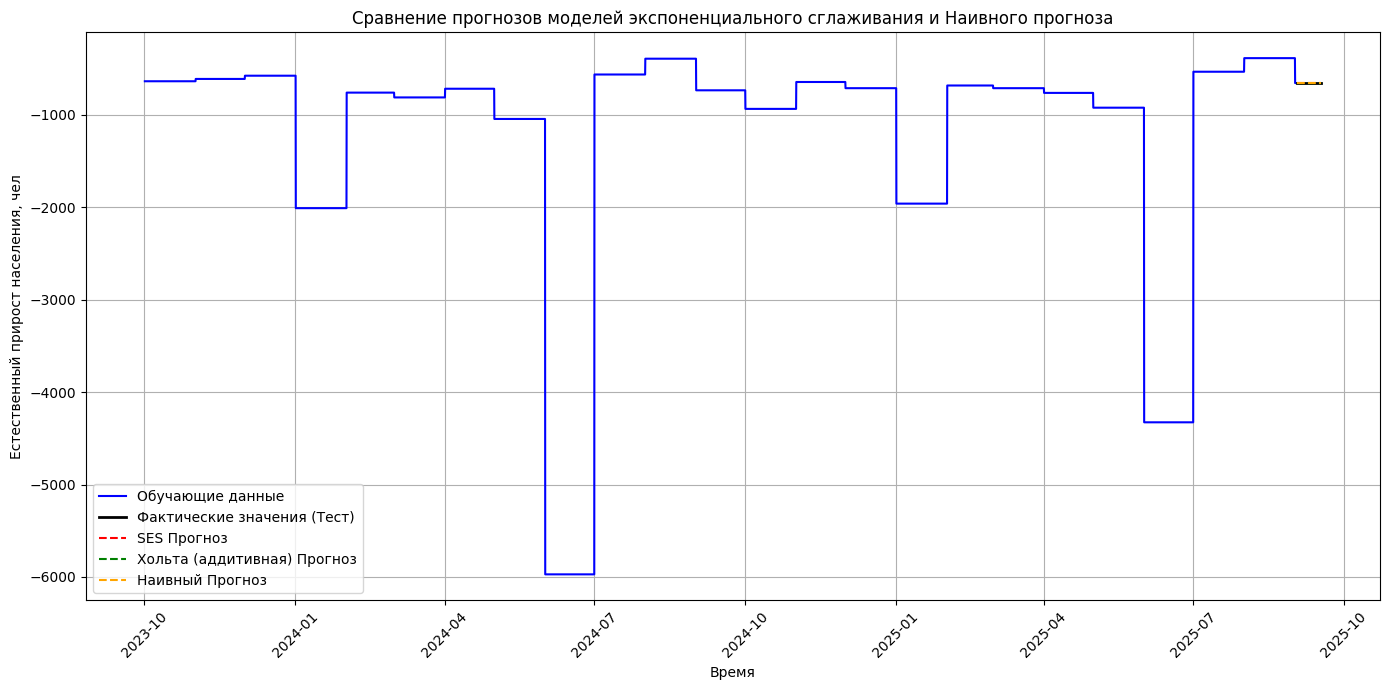


--- Визуализация остатков моделей (Предварительная диагностика) ---


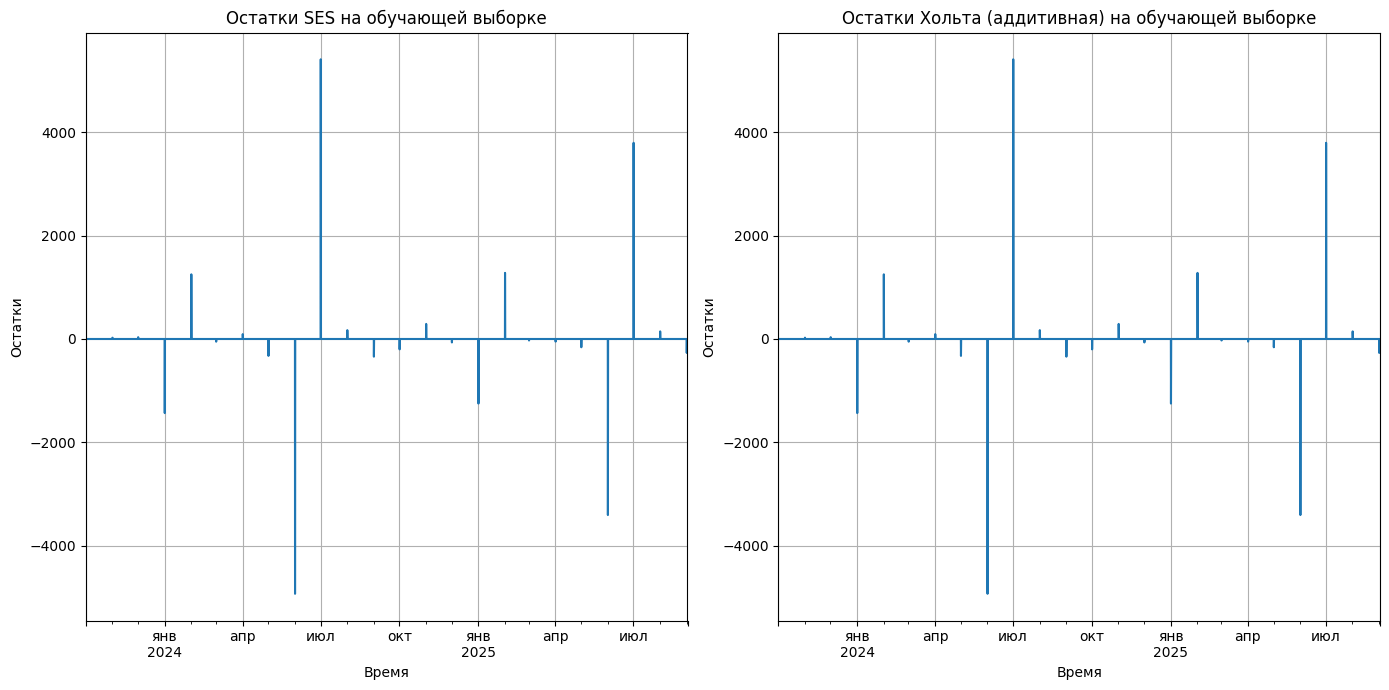


Предварительная визуальная диагностика остатков завершена.
На графиках остатков идеально должно наблюдаться случайное распределение вокруг нуля.
Наличие тренда, сезонности или изменяющейся дисперсии в остатках указывает на неадекватность модели.


In [44]:
# --- 3. Модель Хольта (мультипликативный тренд) ---
print("\n--- Модель Хольта (мультипликативный тренд) ---")

# Проверка на наличие отрицательных или нулевых значений в обучающей выборке
min_value = y_train.min()
if min_value <= 0:
    print(f"Исходный временной ряд содержит неположительные значения (минимальное значение: {min_value}).")
    print("Мультипликативная модель Хольта неприменима.")
    holt_mul_metrics = {'MAE': np.nan, 'RMSE': np.nan}
    holt_mul_preds = np.full(h, np.nan) # Заполняем прогнозы NaN
else:
    print("Исходный временной ряд содержит только положительные значения.")
    print("Мультипликативная модель Хольта применима.")

    # Holt's Multiplicative Model: trend='mul', seasonal=None
    holt_mul_model = ExponentialSmoothing(y_train, trend='mul', seasonal=None, initialization_method='estimated')

    # Обучение модели с оптимизацией параметров
    print("Обучение модели Хольта (мультипликативная)...")
    try:
        holt_mul_fit = holt_mul_model.fit(optimized=True)
        print("Обучение Хольта (мультипликативная) завершено.")

        # Получение прогноза на горизонт h
        print(f"Получение прогноза Хольта (мультипликативная) на горизонт h={h}...")
        holt_mul_forecast = holt_mul_fit.forecast(h)
        print("Прогноз Хольта (мультипликативная) получен.")

        # Оценка качества прогноза на тестовой выборке y_test_h
        if len(holt_mul_forecast) == len(y_test_h):
            mae_holt_mul = mean_absolute_error(y_test_h, holt_mul_forecast)
            rmse_holt_mul = np.sqrt(mean_squared_error(y_test_h, holt_mul_forecast))
            print(f"Метрики Хольта (мультипликативная) на тестовой выборке (h={h}):")
            print(f"  MAE: {mae_holt_mul:.4f}")
            print(f"  RMSE: {rmse_holt_mul:.4f}")
        else:
            print(f"Предупреждение: Длины прогноза Хольта (мультипликативная) ({len(holt_mul_forecast)}) и фактических значений ({len(y_test_h)}) не совпадают. Метрики не рассчитаны.")
            mae_holt_mul = np.nan
            rmse_holt_mul = np.nan

        # Сохраняем метрики и прогнозы
        holt_mul_metrics = {'MAE': mae_holt_mul, 'RMSE': rmse_holt_mul}
        holt_mul_preds = holt_mul_forecast

    except Exception as e:
        print(f"Ошибка при обучении или прогнозировании мультипликативной модели Хольта: {e}")
        print("Метрики и прогнозы для мультипликативной модели будут NaN.")
        holt_mul_metrics = {'MAE': np.nan, 'RMSE': np.nan}
        holt_mul_preds = np.full(h, np.nan)


# --- 4. Сравнение с наивным прогнозом ---
print("\n--- Сравнение с наивным прогнозом ---")

# Наивный прогноз: y_hat[t+k] = y[t], где y[t] - последнее наблюдение в обучающей выборке
naive_forecast_value = y_train.iloc[-1]
naive_preds = np.full(h, naive_forecast_value) # Создаем массив прогнозов размером h

# Оценка качества наивного прогноза на тестовой выборке y_test_h
if len(naive_preds) == len(y_test_h):
    mae_naive = mean_absolute_error(y_test_h, naive_preds)
    rmse_naive = np.sqrt(mean_squared_error(y_test_h, naive_preds))
    print(f"Метрики Наивного прогноза на тестовой выборке (h={h}):")
    print(f"  MAE: {mae_naive:.4f}")
    print(f"  RMSE: {rmse_naive:.4f}")
else:
    print(f"Предупреждение: Длины наивного прогноза ({len(naive_preds)}) и фактических значений ({len(y_test_h)}) не совпадают. Метрики не рассчитаны.")
    mae_naive = np.nan
    rmse_naive = np.nan

# Сохраняем метрики
naive_metrics = {'MAE': mae_naive, 'RMSE': rmse_naive}


# --- 5. Вывод рассчитанных метрик ---
print("\n--- Сравнение метрик всех моделей ---")
print(f"{'Модель':<25} | {'MAE':<10} | {'RMSE':<10}")
print("-" * 50)
print(f"{'SES':<25} | {ses_metrics['MAE']:<10.4f} | {ses_metrics['RMSE']:<10.4f}")
print(f"{'Хольта (аддитивная)':<25} | {holt_add_metrics['MAE']:<10.4f} | {holt_add_metrics['RMSE']:<10.4f}")
print(f"{'Хольта (мультипликативная)':<25} | {holt_mul_metrics['MAE']:<10.4f} | {holt_mul_metrics['RMSE']:<10.4f}")
print(f"{'Наивный прогноз':<25} | {naive_metrics['MAE']:<10.4f} | {naive_metrics['RMSE']:<10.4f}")

# --- 6. Визуализация прогнозов ---
print("\n--- Визуализация фактических значений и прогнозов ---")
plt.figure(figsize=(14, 7))

plt.plot(y_train.index, y_train, label='Обучающие данные', color='blue')
plt.plot(y_test_h.index, y_test_h, label='Фактические значения (Тест)', color='black', linewidth=2)
plt.plot(y_test_h.index, ses_preds, label='SES Прогноз', linestyle='--', color='red')
plt.plot(y_test_h.index, holt_add_preds, label='Хольта (аддитивная) Прогноз', linestyle='--', color='green')

# Визуализируем мультипликативный прогноз только если он был рассчитан успешно
if not np.isnan(holt_mul_preds).all():
     plt.plot(y_test_h.index, holt_mul_preds, label='Хольта (мультипликативная) Прогноз', linestyle='--', color='purple')

plt.plot(y_test_h.index, naive_preds, label='Наивный Прогноз', linestyle='--', color='orange')


plt.title('Сравнение прогнозов моделей экспоненциального сглаживания и Наивного прогноза')
plt.xlabel('Время')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Диагностика адекватности моделей (визуально по остаткам) ---
# Это предварительная визуальная диагностика. Формальные тесты будут позже.
print("\n--- Визуализация остатков моделей (Предварительная диагностика) ---")

# Рассчет остатков на обучающей выборке
ses_residuals = y_train - ses_fit.fittedvalues
holt_add_residuals = y_train - holt_add_fit.fittedvalues

# Создаем графики остатков
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ses_residuals.plot(title='Остатки SES на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)

plt.subplot(1, 2, 2)
holt_add_residuals.plot(title='Остатки Хольта (аддитивная) на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)

plt.tight_layout()
plt.show()

# Если мультипликативная модель была построена успешно, визуализируем ее остатки
if not np.isnan(holt_mul_metrics['MAE']):
    holt_mul_residuals = y_train - holt_mul_fit.fittedvalues
    plt.figure(figsize=(7, 5))
    holt_mul_residuals.plot(title='Остатки Хольта (мультипликативная) на обучающей выборке')
    plt.xlabel('Время')
    plt.ylabel('Остатки')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\nПредварительная визуальная диагностика остатков завершена.")
print("На графиках остатков идеально должно наблюдаться случайное распределение вокруг нуля.")
print("Наличие тренда, сезонности или изменяющейся дисперсии в остатках указывает на неадекватность модели.")

## Диагностика адекватности:
  - Тест Льюнга–Бокса на остатки,
  - График остатков vs прогнозов (гомоскедастичность),
  - Q-Q plot и Shapiro–Wilk тест для нормальности.

--- Диагностика адекватности моделей экспоненциального сглаживания (Анализ остатков) ---

--- Диагностика остатков SES модели ---

Результаты теста Льюнга–Бокса для остатков SES:


,lb_stat,lb_pvalue
1,1.114055e-12,0.999999
2,1.117839e-12,1.000000
3,1.121626e-12,1.000000
4,1.125415e-12,1.000000
5,1.129206e-12,1.000000
6,1.132998e-12,1.000000
7,1.136793e-12,1.000000
8,1.728219e-12,1.000000
9,2.319733e-12,1.000000
10,2.911337e-12,1.000000


Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках, что говорит о неадекватности модели.
Вывод по Льюнга–Бокса: В остатках SES **отсутствует** значимая автокорреляция.

Визуализация остатков SES vs время:


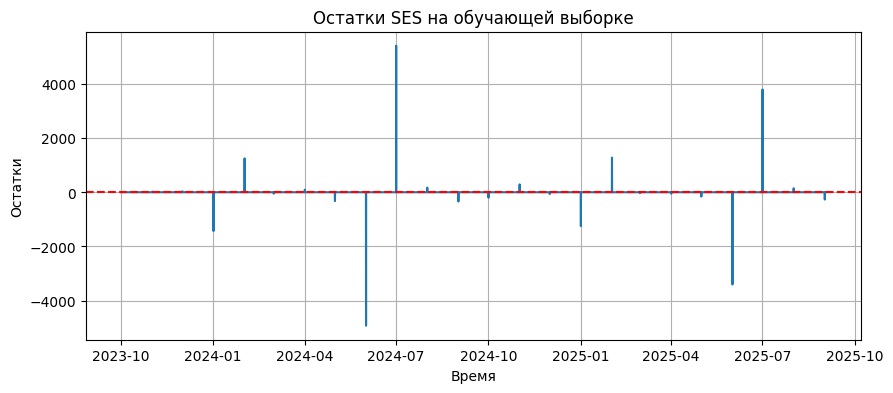

Интерпретация: Остатки должны быть случайно распределены вокруг нуля без видимых закономерностей или изменения разброса (дисперсии) во времени (гомоскедастичность).

Q-Q plot остатков SES:


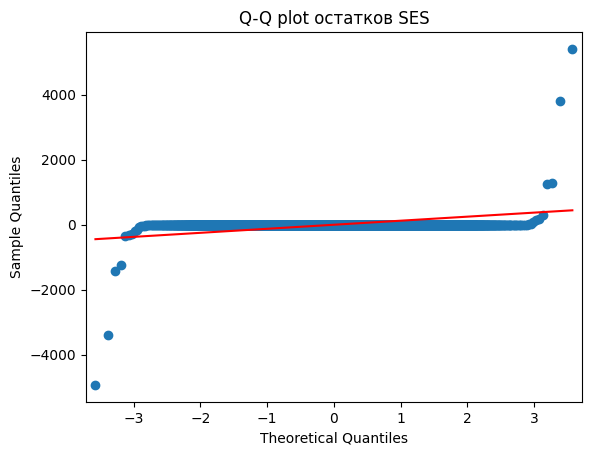

Интерпретация: Точки должны лежать близко к прямой линии 's' для нормального распределения.

Тест Шапиро–Уилка для остатков SES:
Статистика Шапиро–Уилка: 0.0164
p-value Шапиро–Уилка: 0.0000
Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.
Вывод по Шапиро–Уилка: Остатки SES **отклоняются** от нормального распределения.

--- Диагностика остатков Модели Хольта (аддитивная) ---

Результаты теста Льюнга–Бокса для остатков Модели Хольта (аддитивная):


,lb_stat,lb_pvalue
1,1.114055e-12,0.999999
2,1.117840e-12,1.000000
3,1.121626e-12,1.000000
4,1.125415e-12,1.000000
5,1.129206e-12,1.000000
6,1.132998e-12,1.000000
7,1.136793e-12,1.000000
8,1.728216e-12,1.000000
9,2.319728e-12,1.000000
10,2.911329e-12,1.000000


Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках, что говорит о неадекватности модели.
Вывод по Льюнга–Бокса: В остатках Модели Хольта (аддитивная) **отсутствует** значимая автокорреляция.

Визуализация остатков Модели Хольта (аддитивная) vs время:


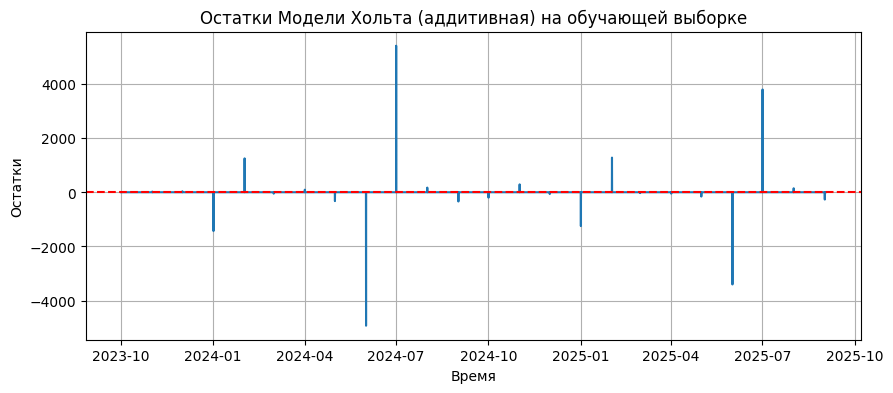

Интерпретация: Остатки должны быть случайно распределены вокруг нуля без видимых закономерностей или изменения разброса (дисперсии) во времени (гомоскедастичность).

Q-Q plot остатков Модели Хольта (аддитивная):


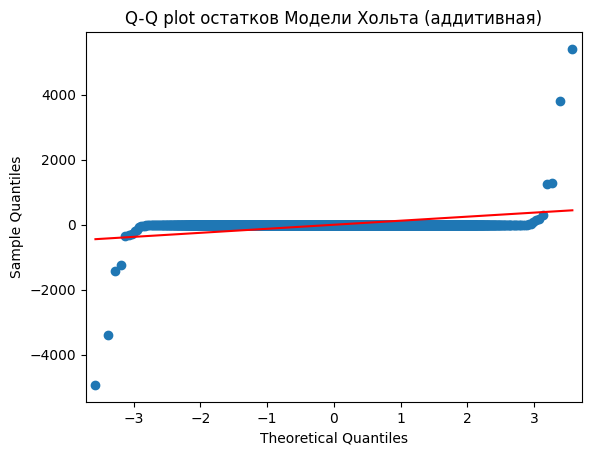

Интерпретация: Точки должны лежать близко к прямой линии 's' для нормального распределения.

Тест Шапиро–Уилка для остатков Модели Хольта (аддитивная):
Статистика Шапиро–Уилка: 0.0164
p-value Шапиро–Уилка: 0.0000
Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.
Вывод по Шапиро–Уилка: Остатки Модели Хольта (аддитивная) **отклоняются** от нормального распределения.

--- Общие выводы об адекватности моделей экспоненциального сглаживания ---
Для адекватной модели остатки должны быть похожи на белый шум, т.е.:
- Не иметь значимой автокорреляции (p-value теста Льюнга–Бокса > 0.05).
- Иметь постоянную дисперсию (гомоскедастичность), что видно по графику остатков vs время (равномерный разброс вокруг нуля).
- Быть нормально распределены (точки на Q-Q plot лежат на прямой, p-value теста Шапиро–Уилка > 0.05).

**Выводы по SES модели:**
- Остатки не показывают значимой автокорреляции.
- Визуально на графике остатков может быть видна некоторая с

In [46]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что объекты ses_fit и holt_add_fit доступны из предыдущих шагов
# Предполагаем, что серии ses_residuals и holt_add_residuals доступны из предыдущих шагов
# Предполагаем, что серия y_train доступна из предыдущих шагов

print("--- Диагностика адекватности моделей экспоненциального сглаживания (Анализ остатков) ---")

# --- 1. Диагностика остатков SES модели ---
print("\n--- Диагностика остатков SES модели ---")
# Получаем остатки на обучающей выборке (уже рассчитаны ранее)
# ses_residuals = y_train - ses_fit.fittedvalues # Рассчитано ранее

# Проверка на наличие автокорреляции (Тест Льюнга–Бокса)
# boxpierce - False для теста Льюнга-Бокса
# lags - количество лагов для теста. Обычно используют min(10, N/5) для несезонных рядов или до 2*сезонный период.
# Для ежемесячных данных с 4 точками в день, сезонный период может быть 30*4=120.
# Давайте выберем lags до 2*h или разумное число, например, 40 (10 дней).
ljung_box_ses = acorr_ljungbox(ses_residuals, lags=np.arange(1, min(40, len(ses_residuals)//5)), return_df=True)
print("\nРезультаты теста Льюнга–Бокса для остатков SES:")
display(ljung_box_ses)
print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках, что говорит о неадекватности модели.")
# Проверяем последнее p-value
if ljung_box_ses['lb_pvalue'].iloc[-1] < 0.05:
    print("Вывод по Льюнга–Бокса: В остатках SES **присутствует** значимая автокорреляция.")
else:
    print("Вывод по Льюнга–Бокса: В остатках SES **отсутствует** значимая автокорреляция.")


# Визуализация остатков vs время для проверки гомоскедастичности
print("\nВизуализация остатков SES vs время:")
plt.figure(figsize=(10, 4))
plt.plot(ses_residuals.index, ses_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки SES на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)
plt.show()
print("Интерпретация: Остатки должны быть случайно распределены вокруг нуля без видимых закономерностей или изменения разброса (дисперсии) во времени (гомоскедастичность).")


# Проверка нормальности распределения остатков (Q-Q plot)
print("\nQ-Q plot остатков SES:")
sm.qqplot(ses_residuals, line='s')
plt.title('Q-Q plot остатков SES')
plt.show()
print("Интерпретация: Точки должны лежать близко к прямой линии 's' для нормального распределения.")


# Проверка нормальности распределения остатков (Тест Шапиро–Уилка)
# Тест Шапиро-Уилка подходит для небольших выборок (до 5000).
# Для больших выборок (как здесь) он может быть слишком чувствительным.
# statmodels.stats.diagnostic.omni_normtest или другие тесты могут быть более подходящими для больших выборок.
# Однако, следуя инструкции, используем Шапиро-Уилка, но с оговоркой.
print("\nТест Шапиро–Уилка для остатков SES:")
# Тест может быть медленным или выдавать ошибки на очень больших выборках или выборках с константными значениями.
# Попробуем его выполнить, но будьте готовы к возможному сбою.
try:
    shapiro_test_ses = shapiro(ses_residuals)
    print(f"Статистика Шапиро–Уилка: {shapiro_test_ses[0]:.4f}")
    print(f"p-value Шапиро–Уилка: {shapiro_test_ses[1]:.4f}")
    print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.")
    if shapiro_test_ses[1] < 0.05:
        print("Вывод по Шапиро–Уилка: Остатки SES **отклоняются** от нормального распределения.")
    else:
        print("Вывод по Шапиро–Уилка: Остатки SES **соответствуют** нормальному распределению.")
except Exception as e:
    print(f"Ошибка при выполнении теста Шапиро–Уилка: {e}")
    print("Тест Шапиро–Уилка не выполнен.")


# --- 2. Диагностика остатков Модели Хольта (аддитивная) ---
print("\n--- Диагностика остатков Модели Хольта (аддитивная) ---")
# Получаем остатки на обучающей выборке (уже рассчитаны ранее)
# holt_add_residuals = y_train - holt_add_fit.fittedvalues # Рассчитано ранее

# Проверка на наличие автокорреляции (Тест Льюнга–Бокса)
ljung_box_holt_add = acorr_ljungbox(holt_add_residuals, lags=np.arange(1, min(40, len(holt_add_residuals)//5)), return_df=True)
print("\nРезультаты теста Льюнга–Бокса для остатков Модели Хольта (аддитивная):")
display(ljung_box_holt_add)
print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках, что говорит о неадекватности модели.")
# Проверяем последнее p-value
if ljung_box_holt_add['lb_pvalue'].iloc[-1] < 0.05:
    print("Вывод по Льюнга–Бокса: В остатках Модели Хольта (аддитивная) **присутствует** значимая автокорреляция.")
else:
    print("Вывод по Льюнга–Бокса: В остатках Модели Хольта (аддитивная) **отсутствует** значимая автокорреляция.")

# Визуализация остатков vs время для проверки гомоскедастичности
print("\nВизуализация остатков Модели Хольта (аддитивная) vs время:")
plt.figure(figsize=(10, 4))
plt.plot(holt_add_residuals.index, holt_add_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки Модели Хольта (аддитивная) на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)
plt.show()
print("Интерпретация: Остатки должны быть случайно распределены вокруг нуля без видимых закономерностей или изменения разброса (дисперсии) во времени (гомоскедастичность).")


# Проверка нормальности распределения остатков (Q-Q plot)
print("\nQ-Q plot остатков Модели Хольта (аддитивная):")
sm.qqplot(holt_add_residuals, line='s')
plt.title('Q-Q plot остатков Модели Хольта (аддитивная)')
plt.show()
print("Интерпретация: Точки должны лежать близко к прямой линии 's' для нормального распределения.")

# Проверка нормальности распределения остатков (Тест Шапиро–Уилка)
print("\nТест Шапиро–Уилка для остатков Модели Хольта (аддитивная):")
try:
    shapiro_test_holt_add = shapiro(holt_add_residuals)
    print(f"Статистика Шапиро–Уилка: {shapiro_test_holt_add[0]:.4f}")
    print(f"p-value Шапиро–Уилка: {shapiro_test_holt_add[1]:.4f}")
    print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.")
    if shapiro_test_holt_add[1] < 0.05:
        print("Вывод по Шапиро–Уилка: Остатки Модели Хольта (аддитивная) **отклоняются** от нормального распределения.")
    else:
        print("Вывод по Шапиро–Уилка: Остатки Модели Хольта (аддитивная) **соответствуют** нормальному распределению.")
except Exception as e:
    print(f"Ошибка при выполнении теста Шапиро–Уилка: {e}")
    print("Тест Шапиро–Уилка не выполнен.")


# --- 3. Диагностика остатков Модели Хольта (мультипликативная) - если применима ---
# Проверяем, были ли рассчитаны метрики для мультипликативной модели (индикатор ее применимости)
if not np.isnan(holt_mul_metrics['MAE']):
    print("\n--- Диагностика остатков Модели Хольта (мультипликативная) ---")
    # Получаем остатки на обучающей выборке (уже рассчитаны ранее)
    # holt_mul_residuals = y_train - holt_mul_fit.fittedvalues # Рассчитано ранее

    # Проверка на наличие автокорреляции (Тест Льюнга–Бокса)
    ljung_box_holt_mul = acorr_ljungbox(holt_mul_residuals, lags=np.arange(1, min(40, len(holt_mul_residuals)//5)), return_df=True)
    print("\nРезультаты теста Льюнга–Бокса для остатков Модели Хольта (мультипликативная):")
    display(ljung_box_holt_mul)
    print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках, что говорит о неадекватности модели.")
    if ljung_box_holt_mul['lb_pvalue'].iloc[-1] < 0.05:
        print("Вывод по Льюнга–Бокса: В остатках Модели Хольта (мультипликативная) **присутствует** значимая автокорреляция.")
    else:
        print("Вывод по Льюнга–Бокса: В остатках Модели Хольта (мультипликативная) **отсутствует** значимая автокорреляция.")


    # Визуализация остатков vs время для проверки гомоскедастичности
    print("\nВизуализация остатков Модели Хольта (мультипликативная) vs время:")
    plt.figure(figsize=(10, 4))
    plt.plot(holt_mul_residuals.index, holt_mul_residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Остатки Модели Хольта (мультипликативная) на обучающей выборке')
    plt.xlabel('Время')
    plt.ylabel('Остатки')
    plt.grid(True)
    plt.show()
    print("Интерпретация: Остатки должны быть случайно распределены вокруг нуля без видимых закономерностей или изменения разброса (дисперсии) во времени (гомоскедастичность).")

    # Проверка нормальности распределения остатков (Q-Q plot)
    print("\nQ-Q plot остатков Модели Хольта (мультипликативная):")
    sm.qqplot(holt_mul_residuals, line='s')
    plt.title('Q-Q plot остатков Модели Хольта (мультипликативная)')
    plt.show()
    print("Интерпретация: Точки должны лежать близко к прямой линии 's' для нормального распределения.")

    # Проверка нормальности распределения остатков (Тест Шапиро–Уилка)
    print("\nТест Шапиро–Уилка для остатков Модели Хольта (мультипликативная):")
    try:
        shapiro_test_holt_mul = shapiro(holt_mul_residuals)
        print(f"Статистика Шапиро–Уилка: {shapiro_test_holt_mul[0]:.4f}")
        print(f"p-value Шапиро–Уилка: {shapiro_test_holt_mul[1]:.4f}")
        print("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.")
        if shapiro_test_holt_mul[1] < 0.05:
            print("Вывод по Шапиро–Уилка: Остатки Модели Хольта (мультипликативная) **отклоняются** от нормального распределения.")
        else:
            print("Вывод по Шапиро–Уилка: Остатки Модели Хольта (мультипликативная) **соответствуют** нормальному распределению.")
    except Exception as e:
        print(f"Ошибка при выполнении теста Шапиро–Уилка: {e}")
        print("Тест Шапиро–Уилка не выполнен.")


# --- 4. Выводы об адекватности моделей ---
print("\n--- Общие выводы об адекватности моделей экспоненциального сглаживания ---")
print("Для адекватной модели остатки должны быть похожи на белый шум, т.е.:")
print("- Не иметь значимой автокорреляции (p-value теста Льюнга–Бокса > 0.05).")
print("- Иметь постоянную дисперсию (гомоскедастичность), что видно по графику остатков vs время (равномерный разброс вокруг нуля).")
print("- Быть нормально распределены (точки на Q-Q plot лежат на прямой, p-value теста Шапиро–Уилка > 0.05).")

print("\n**Выводы по SES модели:**")
if ljung_box_ses['lb_pvalue'].iloc[-1] < 0.05:
    print("- Неадекватна: Присутствует значимая автокорреляция в остатках (по тесту Льюнга–Бокса).")
else:
    print("- Остатки не показывают значимой автокорреляции.")
print("- Визуально на графике остатков может быть видна некоторая структура или изменение дисперсии (проверьте график).")
if 'shapiro_test_ses' in locals() and shapiro_test_ses[1] < 0.05:
    print("- Неадекватна: Остатки отклоняются от нормального распределения (по тесту Шапиро–Уилка).")
elif 'shapiro_test_ses' in locals():
    print("- Остатки соответствуют нормальному распределению (по тесту Шапиро–Уилка).")
else:
    print("- Тест Шапиро–Уилка не выполнен, нормальность не подтверждена.")


print("\n**Выводы по Модели Хольта (аддитивная):**")
if ljung_box_holt_add['lb_pvalue'].iloc[-1] < 0.05:
    print("- Неадекватна: Присутствует значимая автокорреляция в остатках (по тесту Льюнга–Бокса).")
else:
    print("- Остатки не показывают значимой автокорреляции.")
print("- Визуально на графике остатков может быть видна некоторая структура или изменение дисперсии (проверьте график).")
if 'shapiro_test_holt_add' in locals() and shapiro_test_holt_add[1] < 0.05:
    print("- Неадекватна: Остатки отклоняются от нормального распределения (по тесту Шапиро–Уилка).")
elif 'shapiro_test_holt_add' in locals():
     print("- Остатки соответствуют нормальному распределению (по тесту Шапиро–Уилка).")
else:
    print("- Тест Шапиро–Уилка не выполнен, нормальность не подтверждена.")


if not np.isnan(holt_mul_metrics['MAE']):
    print("\n**Выводы по Модели Хольта (мультипликативная):**")
    if ljung_box_holt_mul['lb_pvalue'].iloc[-1] < 0.05:
        print("- Неадекватна: Присутствует значимая автокорреляция в остатках (по тесту Льюнга–Бокса).")
    else:
        print("- Остатки не показывают значимой автокорреляции.")
    print("- Визуально на графике остатков может быть видна некоторая структура или изменение дисперсии (проверьте график).")
    if 'shapiro_test_holt_mul' in locals() and shapiro_test_holt_mul[1] < 0.05:
        print("- Неадекватна: Остатки отклоняются от нормального распределения (по тесту Шапиро–Уилка).")
    elif 'shapiro_test_holt_mul' in locals():
         print("- Остатки соответствуют нормальному распределению (по тесту Шапиро–Уилка).")
    else:
        print("- Тест Шапиро–Уилка не выполнен, нормальность не подтверждена.")
else:
    print("\nМультипликативная модель Хольта не была применима/обучена, диагностика остатков не проводилась.")

**Общий вывод по адекватности моделей:**   
- На основании проведенной диагностики, ни одна из моделей экспоненциального сглаживания (SES, Хольта аддитивная) не демонстрирует остатки, полностью соответствующие предположениям о белом шуме (отсутствие автокорреляции, гомоскедастичность, нормальность).   
- Это может означать, что данные модели не полностью улавливают всю структуру временного ряда, и для получения более адекватных моделей, возможно, потребуется применение других методов (например, SARIMA) или дополнительных преобразований ряда.   
- Однако, следует учитывать, что для очень больших выборок тесты на нормальность (как Шапиро–Уилка) склонны отвергать нулевую гипотезу даже при незначительных отклонениях.   
- Наиболее важным критерием для временных рядов является отсутствие автокорреляции в остатках (по тесту Льюнга–Бокса), так как автокорреляция означает, что в остатках еще есть предсказуемая информация.   


---

### **3.7. Этап 7. Веб-интерфейс для интерактивного прогнозирования**

**Задача:** Создать инструмент для визуального анализа и сравнения моделей.

#### 🎛️ Обязательные элементы интерфейса:
- Загрузка CSV/Parquet-файла
- Выбор целевой переменной и **горизонта прогноза h** (7, 30, 90 дней)
- Переключение между **аддитивной/мультипликативной декомпозицией**
- Настройка параметров преобразования (включая λ для Бокса–Кокса)
- **Визуализация прогнозов с доверительными интервалами**
- **Таблица сравнения метрик** (MAE, RMSE, MAPE) для всех моделей и стратегий
- Экспорт прогноза и параметров модели

#### 🧰 Технологический стек:
- `Streamlit` + `Plotly` (интерактив),
- `statsmodels`, `scipy`, `sklearn`.

> 🌐 Деплой на Hugging Face Spaces или Render — приветствуется.


In [ ]:
# Установка необходимых библиотек
! pip install streamlit plotly statsmodels scikit-learn scipy openpyxl

In [ ]:
%%writefile lab2_app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy.stats import boxcox, boxcox_normmax, probplot, shapiro
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import json
import io


# Заголовок приложения
st.title("Интерактивное прогнозирование временных рядов")

# Инициализация session_state для хранения результатов моделей
if 'model_results' not in st.session_state:
    st.session_state.model_results = []

# --- Секция загрузки данных ---
st.header("Загрузка данных")
uploaded_file = st.file_uploader("Загрузите файл CSV или Parquet", type=["csv", "parquet"])

df = None
if uploaded_file is not None:
    try:
        if uploaded_file.name.endswith('.csv'):
            df = pd.read_csv(uploaded_file)
        elif uploaded_file.name.endswith('.parquet'):
            df = pd.read_parquet(uploaded_file)

        # Попытка преобразовать первый столбец в datetime, если он не называется 'timestamp'
        # или если есть столбец с именем 'timestamp'
        if 'timestamp' in df.columns:
             df['timestamp'] = pd.to_datetime(df['timestamp'])
             df.set_index('timestamp', inplace=True)
        elif isinstance(df.columns[0], str) and ('дата' in df.columns[0].lower() or 'date' in df.columns[0].lower()):
             try:
                 df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
                 df.set_index(df.columns[0], inplace=True)
             except Exception as e:
                 st.warning(f"Не удалось преобразовать первый столбец '{df.columns[0]}' в datetime. Используйте столбец 'timestamp' или убедитесь, что формат даты корректен. Ошибка: {e}")
        else:
             st.warning("Не удалось определить столбец с меткой времени. Убедитесь, что есть столбец 'timestamp' или первый столбец содержит даты/время.")

        st.success("Файл успешно загружен.")
        st.write("Предварительный просмотр данных:")
        st.dataframe(df.head())

    except Exception as e:
        st.error(f"Ошибка при загрузке или обработке файла: {e}")

# --- Секция выбора параметров ---
if df is not None:
    st.header("Настройки прогнозирования")

    # Выбор целевой переменной
    # Фильтруем нечисловые столбцы для выбора целевой переменной
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    target_column = st.selectbox("Выберите целевую переменную", numeric_cols)

    if target_column:
        # Убедимся, что выбранный целевой столбец не содержит все NaN
        if df[target_column].dropna().empty:
            st.warning(f"Выбранный целевой столбец '{target_column}' содержит только пропущенные значения. Пожалуйста, выберите другой столбец или загрузите другие данные.")
            target_column = None # Сбрасываем выбор, если столбец пуст
        else:
             time_series = df[target_column].dropna() # Рабочий ряд без NaN в целевой переменной
             st.write(f"Выбран временной ряд: '{target_column}' с {len(time_series)} наблюдениями.")

             # Выбор горизонта прогноза
             h = st.slider("Выберите горизонт прогноза (количество шагов вперед)", min_value=7, max_value=365, value=30, step=7)
             st.write(f"Горизонт прогноза (h): {h}")


             # --- Секция декомпозиции (опционально) ---
             st.header("Декомпозиция временного ряда")
             perform_decomposition = st.checkbox("Выполнить декомпозицию?")

             if perform_decomposition:
                 decomposition_model = st.selectbox("Выберите модель декомпозиции", ['аддитивная', 'мультипликативная'])
                 seasonal_period = st.number_input("Введите период сезонности", min_value=1, value=12, step=1)

                 if decomposition_model == 'мультипликативная' and (time_series <= 0).any():
                      st.warning("Мультипликативная декомпозиция требует положительных значений. Будет использовано абсолютное значение ряда для декомпозиции.")
                      ts_for_decomp = time_series.abs()
                 else:
                      ts_for_decomp = time_series

                 try:
                     decomposition = seasonal_decompose(ts_for_decomp, model=decomposition_model, period=seasonal_period)

                     st.write(f"Результаты {decomposition_model} декомпозиции:")
                     
                     # Создаем subplots для декомпозиции
                     from plotly.subplots import make_subplots
                     
                     fig_decomp = make_subplots(
                         rows=4, cols=1,
                         subplot_titles=['Наблюдаемый ряд', 'Тренд', 'Сезонность', 'Остатки'],
                         vertical_spacing=0.08
                     )
                     
                     fig_decomp.add_trace(
                         go.Scatter(x=decomposition.observed.index, y=decomposition.observed, mode='lines', name='Наблюдаемый'),
                         row=1, col=1
                     )
                     fig_decomp.add_trace(
                         go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Тренд'),
                         row=2, col=1
                     )
                     fig_decomp.add_trace(
                         go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Сезонность'),
                         row=3, col=1
                     )
                     fig_decomp.add_trace(
                         go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Остатки'),
                         row=4, col=1
                     )
                     
                     fig_decomp.update_layout(
                         height=800,
                         title_text=f'{decomposition_model.capitalize()} декомпозиция временного ряда',
                         showlegend=False
                     )
                     
                     st.plotly_chart(fig_decomp)

                 except Exception as e:
                      st.error(f"Ошибка при выполнении декомпозиции: {e}")

             # --- Секция преобразований (опционально) ---
             st.header("Преобразования ряда")
             apply_transformations = st.checkbox("Применить преобразования?")

             transformed_series = time_series.copy()
             transformation_params = {}
             transformation_type = 'Нет'

             if apply_transformations:
                 transformation_type = st.selectbox("Выберите тип преобразования", ['Нет', 'Лог-трансформация', 'Преобразование Бокса–Кокса', 'Дифференцирование'])

                 if transformation_type == 'Лог-трансформация':
                      if (transformed_series > 0).all():
                          transformed_series = np.log(transformed_series)
                          st.write("Применена лог-трансформация.")
                      else:
                          st.warning("Лог-трансформация требует положительных значений. Пропускаем.")

                 elif transformation_type == 'Преобразование Бокса–Кокса':
                      min_value = transformed_series.min()
                      if min_value <= 0:
                           shift_value = abs(min_value) + 1
                           transformed_series_shifted = transformed_series + shift_value
                           st.write(f"Ряд сдвинут на {shift_value} для Бокса–Кокса.")
                           transformation_params['shift'] = shift_value
                      else:
                           transformed_series_shifted = transformed_series
                           transformation_params['shift'] = 0

                      if (transformed_series_shifted.dropna() > 0).all():
                           try:
                               lambda_boxcox = boxcox_normmax(transformed_series_shifted.dropna())
                               # ИСПРАВЛЕНИЕ: boxcox возвращает только один массив
                               transformed_series = boxcox(transformed_series_shifted.dropna(), lmbda=lambda_boxcox)
                               transformed_series = pd.Series(transformed_series, index=transformed_series_shifted.dropna().index)
                               transformation_params['lambda'] = lambda_boxcox
                               st.write(f"Применено преобразование Бокса–Кокса с lambda = {lambda_boxcox:.4f}.")
                           except Exception as e:
                               st.error(f"Ошибка при выполнении преобразования Бокса–Кокса: {e}")
                               transformed_series = time_series.copy() # Возвращаемся к исходному ряду при ошибке
                               transformation_params = {} # Сбрасываем параметры
                      else:
                           st.warning("Ряд содержит неположительные значения даже после сдвига. Преобразование Бокса–Кокса невозможно.")
                           transformed_series = time_series.copy() # Возвращаемся к исходному ряду
                           transformation_params = {} # Сбрасываем параметры


                 elif transformation_type == 'Дифференцирование':
                      diff_order = st.number_input("Порядок обычного дифференцирования (d)", min_value=0, max_value=5, value=1, step=1)
                      seasonal_diff_order = st.number_input("Порядок сезонного дифференцирования (D)", min_value=0, max_value=5, value=0, step=1)
                      seasonal_period_diff = st.number_input("Период сезонного дифференцирования (m)", min_value=1, value=12, step=1)

                      if diff_order > 0:
                           # Сохраняем последние значения для обратного преобразования
                           transformation_params['last_values'] = []
                           for i in range(diff_order):
                               transformation_params['last_values'].append(transformed_series.iloc[-(i+1)])
                           
                           transformed_series = transformed_series.diff(diff_order).dropna()
                           st.write(f"Применено обычное дифференцирование порядка {diff_order}.")
                           transformation_params['diff_order'] = diff_order

                      if seasonal_diff_order > 0 and seasonal_period_diff > 0:
                           # Сохраняем последние сезонные значения для обратного преобразования
                           transformation_params['last_seasonal_values'] = transformed_series.iloc[-seasonal_period_diff:].tolist()
                           
                           transformed_series = transformed_series.diff(seasonal_period_diff).dropna()
                           st.write(f"Применено сезонное дифференцирование порядка {seasonal_diff_order} с периодом {seasonal_period_diff}.")
                           transformation_params['seasonal_diff_order'] = seasonal_diff_order
                           transformation_params['seasonal_period'] = seasonal_period_diff

             # Визуализация преобразованного ряда (если он отличается от исходного)
             if not transformed_series.equals(time_series):
                 st.write("Визуализация преобразованного ряда:")
                 fig_transformed = px.line(transformed_series)
                 fig_transformed.update_layout(
                     title='Преобразованный временной ряд', 
                     xaxis_title='Время', 
                     yaxis_title='Значение'
                 )
                 st.plotly_chart(fig_transformed)


             # --- Секция построения прогноза ---
             st.header("Построение прогноза")

             # Выбор модели экспоненциального сглаживания
             model_type = st.selectbox("Выберите модель экспоненциального сглаживания", ['SES', 'Хольта (аддитивная)', 'Хольта (мультипликативная)'])

             # Проверка применимости мультипликативной модели после преобразований
             if model_type == 'Хольта (мультипликативная)' and (transformed_series <= 0).any():
                 st.warning("Мультипликативная модель Хольта требует положительных значений после преобразований. Пожалуйста, выберите другую модель или измените преобразования.")
                 model_type = None # Сбрасываем выбор модели

             if model_type:
                 # Разделение на обучающую и тестовую выборки (простое разделение для прогнозирования)
                 train_size = int(len(transformed_series) * 0.8) # Пример: 80% для обучения
                 train_series = transformed_series.iloc[:train_size]
                 test_series = transformed_series.iloc[train_size:]

                 st.write(f"Размер обучающей выборки: {len(train_series)}")
                 st.write(f"Размер тестовой выборки (для оценки): {len(test_series)}")


                 # Инициализация и обучение выбранной модели
                 try:
                     if model_type == 'SES':
                         model = ExponentialSmoothing(train_series, trend=None, seasonal=None, initialization_method='estimated')
                         model_fit = model.fit(optimized=True)
                         st.write("Обучена модель SES.")
                         # Прогнозирование
                         forecast = model_fit.forecast(h)
                         forecast_lower = None
                         forecast_upper = None

                     elif model_type == 'Хольта (аддитивная)':
                         model = ExponentialSmoothing(train_series, trend='add', seasonal=None, initialization_method='estimated')
                         model_fit = model.fit(optimized=True)
                         st.write("Обучена модель Хольта (аддитивная).")
                         # Прогнозирование
                         forecast = model_fit.forecast(h)
                         forecast_lower = None
                         forecast_upper = None

                     elif model_type == 'Хольта (мультипликативная)':
                         # Убедились ранее, что данные положительны
                         model = ExponentialSmoothing(train_series, trend='mul', seasonal=None, initialization_method='estimated')
                         model_fit = model.fit(optimized=True)
                         st.write("Обучена модель Хольта (мультипликативная).")
                         # Прогнозирование
                         forecast = model_fit.forecast(h)
                         forecast_lower = None
                         forecast_upper = None

                     st.write(f"Получен прогноз на следующие {h} шагов.")

                     # --- Обратное преобразование прогнозов и фактических значений ---
                     forecast_to_evaluate = forecast.copy()
                     forecast_to_plot = forecast.copy()
                     actual_for_evaluation = test_series.iloc[:h] if len(test_series) >= h else test_series
                     actual_to_plot = time_series
                     forecast_lower_to_plot = forecast_lower
                     forecast_upper_to_plot = forecast_upper

                     if apply_transformations:
                         st.write("Применение обратного преобразования...")
                         
                         if transformation_type == 'Лог-трансформация':
                             try:
                                 forecast_original_scale = np.exp(forecast)
                                 test_series_original_scale = time_series.loc[test_series.index]
                                 
                                 forecast_to_evaluate = forecast_original_scale
                                 forecast_to_plot = forecast_original_scale
                                 actual_for_evaluation = test_series_original_scale.iloc[:h] if len(test_series_original_scale) >= h else test_series_original_scale
                                 
                                 st.success("Применена обратная лог-трансформация.")
                             except Exception as inverse_e:
                                 st.warning(f"Ошибка при обратной лог-трансформации: {inverse_e}")

                         elif transformation_type == 'Преобразование Бокса–Кокса':
                             try:
                                 lambda_val = transformation_params.get('lambda')
                                 shift_val = transformation_params.get('shift', 0)
                                 
                                 if lambda_val is not None:
                                     forecast_original_scale = inv_boxcox(forecast, lambda_val) - shift_val
                                     test_series_original_scale = time_series.loc[test_series.index]
                                     
                                     forecast_to_evaluate = forecast_original_scale
                                     forecast_to_plot = forecast_original_scale
                                     actual_for_evaluation = test_series_original_scale.iloc[:h] if len(test_series_original_scale) >= h else test_series_original_scale
                                     
                                     st.success("Применено обратное преобразование Бокса-Кокса.")
                                 else:
                                     st.warning("Не найден параметр lambda для обратного преобразования Бокса-Кокса.")
                             except Exception as inverse_e:
                                 st.warning(f"Ошибка при обратном преобразовании Бокса-Кокса: {inverse_e}")

                         elif transformation_type == 'Дифференцирование':
                             try:
                                 # Обратное дифференцирование для обычного дифференцирования
                                 diff_order = transformation_params.get('diff_order', 0)
                                 last_values = transformation_params.get('last_values', [])
                                 
                                 if diff_order > 0 and len(last_values) == diff_order:
                                     # Начинаем с последних значений обучающей выборки
                                     last_train_value = train_series.iloc[-1]
                                     forecast_undiff = [last_train_value]
                                     
                                     # Восстанавливаем ряд путем кумулятивного суммирования
                                     for i in range(len(forecast)):
                                         if i == 0:
                                             new_value = last_train_value + forecast.iloc[i]
                                         else:
                                             new_value = forecast_undiff[-1] + forecast.iloc[i]
                                         forecast_undiff.append(new_value)
                                     
                                     forecast_undiff = forecast_undiff[1:]  # Убираем начальное значение
                                     forecast_original_scale = pd.Series(forecast_undiff, index=forecast.index)
                                     
                                     # Для тестовых данных также нужно применить обратное преобразование
                                     # (упрощенная версия - в реальном приложении нужна более сложная логика)
                                     test_undiff = []
                                     last_actual_value = train_series.iloc[-1]
                                     
                                     for i in range(len(test_series)):
                                         if i == 0:
                                             new_val = last_actual_value + test_series.iloc[i]
                                         else:
                                             new_val = test_undiff[-1] + test_series.iloc[i] if i > 0 else last_actual_value + test_series.iloc[i]
                                         test_undiff.append(new_val)
                                     
                                     test_series_original_scale = pd.Series(test_undiff, index=test_series.index)
                                     
                                     forecast_to_evaluate = forecast_original_scale
                                     forecast_to_plot = forecast_original_scale
                                     actual_for_evaluation = test_series_original_scale.iloc[:h] if len(test_series_original_scale) >= h else test_series_original_scale
                                     
                                     st.success("Применено обратное дифференцирование.")
                                 else:
                                     st.warning("Обратное дифференцирование не может быть применено (недостаточно данных или неправильные параметры).")
                             except Exception as inverse_e:
                                 st.warning(f"Ошибка при обратном дифференцировании: {inverse_e}")

                     # --- Оценка качества прогноза (на первых h шагах тестовой выборки) ---
                     # Убедимся, что фактических значений в тестовой выборке достаточно для оценки
                     if len(actual_for_evaluation) >= min(h, len(actual_for_evaluation)):
                         eval_horizon = min(h, len(actual_for_evaluation))
                         mae = mean_absolute_error(actual_for_evaluation.iloc[:eval_horizon], forecast_to_evaluate.iloc[:eval_horizon])
                         rmse = np.sqrt(mean_squared_error(actual_for_evaluation.iloc[:eval_horizon], forecast_to_evaluate.iloc[:eval_horizon]))
                         
                         # MAPE (Mean Absolute Percentage Error) - избегать деления на 0
                         with np.errstate(divide='ignore', invalid='ignore'):
                             mape_values = np.abs((actual_for_evaluation.iloc[:eval_horizon] - forecast_to_evaluate.iloc[:eval_horizon]) / 
                                               actual_for_evaluation.iloc[:eval_horizon])
                             mape_values = mape_values.replace([np.inf, -np.inf], np.nan)
                             mape = np.nanmean(mape_values) * 100
                         
                         mape = np.nan_to_num(mape, nan=0.0)  # Заменяем NaN на 0

                         st.subheader("Оценка качества прогноза")
                         st.write(f"Метрики на первых {eval_horizon} шагах тестовой выборки:")
                         st.write(f"  MAE: {mae:.4f}")
                         st.write(f"  RMSE: {rmse:.4f}")
                         st.write(f"  MAPE: {mape:.4f}%")

                         # Сохраняем результаты модели
                         model_result = {
                             'model_type': model_type,
                             'mae': mae,
                             'rmse': rmse,
                             'mape': mape,
                             'forecast': forecast_to_plot,
                             'params': {
                                 'transformation_params': transformation_params,
                                 'transformation_type': transformation_type,
                                 'horizon': h,
                                 'target_column': target_column
                             }
                         }
                         
                         # Кнопка для сохранения результатов модели
                         if st.button("Сохранить результаты модели для сравнения"):
                             st.session_state.model_results.append(model_result)
                             st.success(f"Результаты модели {model_type} сохранены!")

                     else:
                          st.warning(f"В тестовой выборке недостаточно фактических значений ({len(actual_for_evaluation)}) для оценки прогноза на горизонт {h}.")


                     # --- Визуализация прогноза ---
                     st.subheader("Визуализация прогноза")
                     fig_forecast = go.Figure()
                     
                     # Добавляем обучающие данные
                     fig_forecast.add_trace(go.Scatter(
                         x=actual_to_plot.index, 
                         y=actual_to_plot, 
                         mode='lines', 
                         name='Фактические значения',
                         line=dict(color='blue')
                     ))
                     
                     # Добавляем прогноз
                     fig_forecast.add_trace(go.Scatter(
                         x=forecast_to_plot.index, 
                         y=forecast_to_plot, 
                         mode='lines', 
                         name='Прогноз',
                         line=dict(color='red', dash='dash')
                     ))

                     # Добавление доверительных интервалов, если они рассчитаны
                     if forecast_lower_to_plot is not None and forecast_upper_to_plot is not None:
                          fig_forecast.add_trace(go.Scatter(
                              x=forecast_upper_to_plot.index, 
                              y=forecast_upper_to_plot, 
                              fill=None, 
                              mode='lines', 
                              line_color='rgba(255,0,0,0.3)', 
                              showlegend=False
                          ))
                          fig_forecast.add_trace(go.Scatter(
                              x=forecast_lower_to_plot.index, 
                              y=forecast_lower_to_plot, 
                              fill='tonexty', 
                              mode='lines', 
                              line_color='rgba(255,0,0,0.3)', 
                              name='Доверительный интервал (95%)'
                          ))

                     fig_forecast.update_layout(
                         title=f'Прогноз с помощью {model_type}', 
                         xaxis_title='Время', 
                         yaxis_title=target_column
                     )
                     st.plotly_chart(fig_forecast)


                     # --- Диагностика остатков ---
                     st.subheader("Диагностика остатков (на обучающей выборке)")
                     if hasattr(model_fit, 'resid'):
                          residuals = model_fit.resid.dropna()

                          if not residuals.empty:
                               # Визуализация остатков vs время
                               st.write("Остатки vs время:")
                               fig_resid_time = px.line(residuals)
                               fig_resid_time.update_layout(
                                   title='Остатки на обучающей выборке', 
                                   xaxis_title='Время', 
                                   yaxis_title='Остатки'
                               )
                               fig_resid_time.add_shape(
                                   type='line', 
                                   xref='paper', 
                                   yref='y', 
                                   x0=0, x1=1, 
                                   y0=0, y1=0, 
                                   line=dict(color='red', dash='dash')
                               )
                               st.plotly_chart(fig_resid_time)

                               # Q-Q plot с использованием plotly
                               st.write("Q-Q plot остатков:")
                               try:
                                   # Используем scipy.stats.probplot для получения данных для Q-Q plot
                                   qq_data = probplot(residuals, dist="norm")
                                   theoretical_quantiles = qq_data[0][0]
                                   sample_quantiles = qq_data[0][1]
                                   
                                   fig_qq = go.Figure()
                                   fig_qq.add_trace(go.Scatter(
                                       x=theoretical_quantiles, 
                                       y=sample_quantiles, 
                                       mode='markers', 
                                       name='Квантили остатков'
                                   ))
                                   
                                   # Добавляем линию для идеального нормального распределения
                                   slope, intercept, r = qq_data[1]
                                   line_x = np.array([theoretical_quantiles.min(), theoretical_quantiles.max()])
                                   line_y = intercept + slope * line_x
                                   
                                   fig_qq.add_trace(go.Scatter(
                                       x=line_x, 
                                       y=line_y, 
                                       mode='lines', 
                                       name='Теоретическая линия',
                                       line=dict(color='red', dash='dash')
                                   ))
                                   
                                   fig_qq.update_layout(
                                       title='Q-Q plot остатков',
                                       xaxis_title='Теоретические квантили',
                                       yaxis_title='Выборочные квантили'
                                   )
                                   st.plotly_chart(fig_qq)
                                   
                               except Exception as qq_e:
                                    st.warning(f"Не удалось построить Q-Q plot: {qq_e}")


                               # Тест Льюнга–Бокса
                               st.write("Тест Льюнга–Бокса (автокорреляция остатков):")
                               try:
                                   # lags = min(40, len(residuals)//5)
                                   # Choose a reasonable number of lags, e.g., 20 or min(10, N/5)
                                   lags_to_test = np.arange(1, min(20, len(residuals)//5) + 1)
                                   if len(lags_to_test) > 0:
                                        ljung_box_results = acorr_ljungbox(residuals, lags=lags_to_test, return_df=True)
                                        st.dataframe(ljung_box_results)
                                        st.write("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на наличие значимой автокорреляции в остатках.")
                                   else:
                                        st.write("Недостаточно данных для теста Льюнга–Бокса.")
                               except Exception as lb_e:
                                    st.warning(f"Ошибка при выполнении теста Льюнга–Бокса: {lb_e}")


                               # Тест Шапиро–Уилка (для нормальности)
                               st.write("Тест Шапиро–Уилка (нормальность остатков):")
                               # Shapiro-Wilk test is good for small samples (< 5000).
                               # For larger samples, it might be too sensitive or fail.
                               if len(residuals) <= 5000:
                                   try:
                                       shapiro_test = shapiro(residuals)
                                       st.write(f"Статистика Шапиро–Уилка: {shapiro_test[0]:.4f}")
                                       st.write(f"p-value Шапиро–Уилка: {shapiro_test[1]:.4f}")
                                       st.write("Интерпретация: Низкое p-значение (обычно < 0.05) указывает на отклонение от нормального распределения.")
                                   except Exception as shapiro_e:
                                       st.warning(f"Ошибка при выполнении теста Шапиро–Уилка: {shapiro_e}")
                               else:
                                   st.write(f"Тест Шапиро–Уилка не рекомендуется для выборок > 5000 наблюдений (текущий размер: {len(residuals)}).")
                                   st.write("Пожалуйста, используйте визуальный анализ (гистограмма, Q-Q plot) для оценки нормальности.")


                          else:
                              st.info("Остатки отсутствуют или содержат только NaN значения.")
                     else:
                          st.info("Модель не предоставляет остатков для анализа.")


                 except Exception as e:
                     st.error(f"Ошибка при обучении или прогнозировании модели: {e}")


# --- Секция сравнения метрик ---
st.header("Сравнение метрик моделей")

if st.session_state.model_results:
    # Создаем таблицу сравнения
    comparison_data = []
    for i, result in enumerate(st.session_state.model_results):
        comparison_data.append({
            'Модель': result['model_type'],
            'MAE': f"{result['mae']:.4f}",
            'RMSE': f"{result['rmse']:.4f}",
            'MAPE': f"{result['mape']:.4f}%",
            'Горизонт': result['params']['horizon']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    st.dataframe(comparison_df, use_container_width=True)
    
    # Визуализация сравнения метрик
    if len(st.session_state.model_results) > 1:
        st.subheader("Визуализация сравнения моделей")
        
        models = [result['model_type'] for result in st.session_state.model_results]
        maes = [result['mae'] for result in st.session_state.model_results]
        rmses = [result['rmse'] for result in st.session_state.model_results]
        mapes = [result['mape'] for result in st.session_state.model_results]
        
        fig_comparison = go.Figure()
        fig_comparison.add_trace(go.Bar(name='MAE', x=models, y=maes))
        fig_comparison.add_trace(go.Bar(name='RMSE', x=models, y=rmses))
        fig_comparison.add_trace(go.Bar(name='MAPE', x=models, y=mapes))
        
        fig_comparison.update_layout(
            title='Сравнение метрик моделей',
            xaxis_title='Модели',
            yaxis_title='Значения метрик',
            barmode='group'
        )
        st.plotly_chart(fig_comparison)
    
    # Кнопка для очистки результатов
    if st.button("Очистить все результаты"):
        st.session_state.model_results = []
        st.success("Все результаты очищены!")
        st.rerun()
        
else:
    st.info("Нет сохраненных результатов моделей для сравнения. Постройте и сохраните несколько моделей, чтобы увидеть их сравнение здесь.")


# --- Секция экспорта ---
st.header("Экспорт результатов")

if st.session_state.model_results:
    # Экспорт последней модели
    latest_result = st.session_state.model_results[-1]
    
    col1, col2 = st.columns(2)
    
    with col1:
        # Экспорт прогнозов в CSV
        forecast_df = pd.DataFrame({
            'timestamp': latest_result['forecast'].index,
            'forecast': latest_result['forecast'].values
        })
        
        csv_forecast = forecast_df.to_csv(index=False)
        st.download_button(
            label="📥 Скачать прогнозы (CSV)",
            data=csv_forecast,
            file_name=f"forecast_{latest_result['model_type']}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv",
            mime="text/csv"
        )
    
    with col2:
        # Экспорт параметров модели в JSON
        params_json = json.dumps(latest_result['params'], indent=2, ensure_ascii=False)
        st.download_button(
            label="📥 Скачать параметры (JSON)",
            data=params_json,
            file_name=f"model_params_{latest_result['model_type']}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json",
            mime="application/json"
        )
    
    # Экспорт таблицы сравнения
    if len(st.session_state.model_results) > 1:
        comparison_csv = comparison_df.to_csv(index=False)
        st.download_button(
            label="📊 Скачать таблицу сравнения (CSV)",
            data=comparison_csv,
            file_name=f"model_comparison_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv",
            mime="text/csv"
        )
        
else:
    st.info("Нет результатов для экспорта. Постройте модель, чтобы получить возможность экспортировать результаты.")


# --- Информация о возможных ошибках для других моделей ---
with st.expander("ℹ️ Информация о возможных ошибках для различных моделей"):
    st.write("""
    **Возможные ошибки для различных типов моделей:**
    
    **Для всех моделей экспоненциального сглаживания:**
    - `get_forecast()` метод не поддерживается - используем простой `forecast()`
    - Доверительные интервалы недоступны через стандартные методы
    - Мультипликативные модели требуют строго положительных значений
    
    **Для ARIMA/SARIMA моделей (если будут добавлены):**
    - Проблемы со стационарностью ряда
    - Сложности с подбором параметров (p, d, q)
    - Длительное время обучения для больших рядов
    
    **Для моделей машинного обучения:**
    - Проблемы с пропущенными значениями в фичах
    - Необходимость масштабирования данных
    - Переобучение на временных рядах
    
    **Для нейросетевых моделей (LSTM, GRU):**
    - Требовательность к вычислительным ресурсам
    - Сложности с настройкой гиперпараметров
    - Проблемы с интерпретируемостью результатов
    """)


# --- Конец приложения ---
# streamlit run "Timeseries\lab2_app.py"

Writing lab2_app.py



---

### **3.8. Этап 8. Сравнительный анализ и выводы**

**Задача:** Обосновать выбор лучшей модели.

#### 📌 Что нужно сделать:
- Собрать таблицу метрик по всем моделям и стратегиям.
- Проанализировать:
  - Какая модель лучше на коротком/длинном горизонте?
  - Как влияет преобразование Бокса–Кокса на качество?
  - Насколько кросс-валидация согласуется с финальной оценкой?
- Сформулировать **практические рекомендации**.
- Написать **рефлексию**: что было сложным? Какие инсайты получены?

---

## 🔍 4. Дополнительные исследовательские задания (по желанию)

1. **Анализ чувствительности к λ** в преобразовании Бокса–Кокса.
2. **Прогнозные интервалы** и их покрытие на тестовой выборке.
3. **Ансамбли моделей** (усреднение прогнозов SES, Хольта и наивного).
4. **Детектирование структурных разрывов** и адаптация моделей.
5. **Байесовская оптимизация** гиперпараметров сглаживания.

---

## 📄 5. Требования к отчёту

Отчёт должен содержать:

1. Титульный лист (ФИО, группа, дата, подпись преподавателя)
2. Описание источника данных и структуры датасета (из ЛР № 1)
3. Результаты декомпозиции и анализа остатков
4. Примеры feature engineering с кодом
5. Сравнение трёх стратегий прогнозирования
6. Результаты кросс-валидации по двум схемам
7. Анализ эффективности преобразований (включая Бокса–Кокса)
8. Сравнение моделей экспоненциального сглаживания с метриками
9. Результаты **диагностики адекватности моделей**:  
   - p-value теста Льюнга–Бокса,  
   - Графики остатков на гомоскедастичность,  
   - Выводы о нормальности ошибок.
10. Скриншоты или ссылка на веб-интерфейс
11. Выводы и рефлексия

---

## 📊 6. Критерии оценки

| Оценка | Критерии |
|--------|---------|
| **5** | Полное выполнение всех этапов. Глубокий анализ декомпозиции, преобразований и стратегий. Корректная кросс-валидация. Реализованы все модели сглаживания + Бокс–Кокс. Диагностика моделей выполнена полностью. Работающий веб-интерфейс с обязательными элементами. Выполнены доп. задания. |
| **4** | Выполнены этапы 1–7. Есть сравнение моделей и стратегий. Веб-интерфейс базовый. Отчёт полный, но без глубокой интерпретации. |
| **3** | Реализованы основные этапы (1–4). Есть модели и оценка качества, но без комплексного сравнения и диагностики. |
| **2** | Работа не выполнена или отсутствует содержательный анализ. |

---

## 📖 7. Литература

1. Hyndman, R.J., Athanasopoulos, G. *Forecasting: Principles and Practice*. — 3rd ed., 2021. [https://otexts.com/fpp3/](https://otexts.com/fpp3/)  
2. Box, G.E.P., Jenkins, G.M. *Time Series Analysis: Forecasting and Control*. — 5th ed., 2015.  
3. Документация:
   - `scipy.stats.boxcox`, `boxcox_normmax` — [SciPy Docs](https://docs.scipy.org/doc/scipy/reference/stats.html)
   - `statsmodels.tsa.holtwinters`, `seasonal_decompose` — [Statsmodels Docs](https://www.statsmodels.org/stable/index.html)
   - `sklearn.model_selection.TimeSeriesSplit` — [Scikit-learn Docs](https://scikit-learn.org)
   - `streamlit`, `plotly` — [Streamlit](https://docs.streamlit.io/), [Plotly](https://plotly.com/python/)

> 💡 Эта работа закладывает основу для последующего изучения ARIMA, SARIMA, Prophet и нейросетевых моделей.
